In [1]:
import numpy as np
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from utilities import dLambda
from solver_1d import false_transient_one_iteration_python
import global_parameters as gp
from supportfunctions import finiteDiff
import matplotlib.pyplot as plt
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d

import SolveLinSys
import time
from supportfunctions import PDESolver_2d, finiteDiff
import global_parameters as gp
from utilities import dLambda, ddLambda, weightOfPi, relativeEntropy, weightPI, damageDrift, zDrift

In [2]:
@njit
def derivative_1d(data, order, h_data, upwind=False):
    num, = data.shape
    ddata = np.zeros_like(data)
    if order == 1:
        for i in range(num):
            if i == 0:
                ddata[i] = (data[i+1]-data[i])/h_data
            elif i == num-1:
                ddata[i] = (data[i]-data[i-1])/h_data
            else: 
                if upwind == True:
                    ddata[i] = (data[i]-data[i-1])/h_data
                else:
                    ddata[i] = (data[i+1]-data[i-1])/(2*h_data)
    elif order == 2:
        for i in range(num):
            if i == 0:
                ddata[i] = (data[i+2]-2*data[i+1] + data[i])/(h_data**2)
            elif i == num -1:
                ddata[i] = (data[i]-2*data[i-1] + data[i-2])/(h_data**2)
            else:
                ddata[i] = (data[i+1]- 2*data[i] + data[i-1])/(h_data**2)
    
    return ddata

In [3]:
@njit
def get_coeff(A, Bx, Cxx, D, x_grid, ϕ_prev, ϵ, boundspec):
    dx = x_grid[1] - x_grid[0]
    numx = len(x_grid)
    LHS = np.zeros((numx, numx))
    RHS = -1/ϵ*ϕ_prev - D
    for i in range(numx):
        LHS[i,i] += - 1/ϵ + A[i]
        if i == 0:
            LHS[i,i] += - 1/dx*Bx[i]
            LHS[i,i+1] += 1/dx*Bx[i]
        elif i == numx-1:
            if boundspec[0] == True:
                LHS[i,i] = 1
                RHS[i] = boundspec[1]
            else:
                LHS[i,i] += 1/dx*Bx[i]
                LHS[i,i-1] += -1/dx*Bx[i]
        else:
            LHS[i,i+1] += Bx[i]*(1./dx)*(Bx[i]>0) + Cxx[i]/(dx**2)
            LHS[i,i] += Bx[i]*((-1/dx)*(Bx[i]>0) + (1/dx)*(Bx[i]<0)) - 2*Cxx[i]/(dx**2)
            LHS[i,i-1] += Bx[i]*(-1/dx)*(Bx[i]<0) + Cxx[i]/(dx**2)
    return LHS, RHS

In [4]:
def solve_ode( A, By, Cyy, D, y_grid, ϕ_prev, ϵ, boundspec):
    LHS, RHS = get_coeff( A, By, Cyy, D, y_grid, ϕ_prev, ϵ, boundspec)
    phi_grid, exit_code = bicg(csc_matrix(LHS), RHS)
#     phi_grid = np.linalg.solve(LHS, RHS)
    return phi_grid

In [5]:
def false_transient_1d(
    y_grid, z, 
    dmg_params, model_params, bounded=False, bound_var=0, 
    epsilon=0.5, tol = 1e-8, max_iter=10_000,
):
    gamma_1, gamma_2, gamma2pList, gamma_bar, dmg_weights = dmg_params
    delta, eta, mu2, sigma2, rho, v_n = model_params
    numy, = y_grid.shape
    hy = y_grid[1] - y_grid[0]
    dlambda = gamma_1 + gamma_2*y_grid\
    + np.sum(gamma2pList*dmg_weights,axis=0)*(y_grid-gamma_bar)*(y_grid>gamma_bar)
    # initiate v and control
    ems = -delta*eta/((eta-1)*dlambda*z)
    error = 1
    episode = 0
    v0 = - delta*eta*y_grid
    
    while error > tol and episode < max_iter:
        v0_old = v0.copy()
        v0_dy = derivative_1d(v0,1,hy, upwind=True)
        # control
        ems_new = -delta*eta/(v0_dy*z + v_n*dlambda*z)
        ems_new[ems_new<=0] = 1e-15
        ems = ems_new*.5 + ems*.5
        A = -delta*np.ones(y_grid.shape)
        By = z*ems
        Cyy = np.zeros(y_grid.shape)
        D = delta*eta*np.log(ems) + v_n*dlambda*z*ems
        # solve for ODE
        phi_grid = solve_ode(y_grid, A, By, Cyy, D, v0, bound_var, bounded, epsilon)
        phi_grid2 = false_transient_one_iteration_python(
            A, By, Cyy, D, v0, epsilon, hy, (0,bound_var), (False, bounded))
        diff = np.max(abs(phi_grid - phi_grid2))
        rhs = A*phi_grid + By*v0_dy + D
        rhs_error = np.max(abs(rhs))
        error = np.max(abs((phi_grid-v0)/epsilon))
        v0 = phi_grid
        episode += 1
        print('Episode: {:d}\t lhs error: {:.12f}\t rhs error: {:.12f}\t diff: {:.12f}'.format(episode,error,rhs_error,diff))
    return v0, ems

In [6]:
δ = 0.01
η = 0.032
μ = 1.86/1000
ȳ = 2

numy_bar = 100
y_min = 0
y_max = 4
hy = (ȳ - y_min)/numy_bar
y_grid = np.arange(y_min, y_max+hy, hy)

γ1 = 0.00017675
γ2 = 2*0.0022
γ2p = np.array([0, 2*0.0197])
γbar = 2
dmg_weight = np.array([1, 0])
dΛ = γ1 + γ2*y_grid + np.average(γ2p, weights=dmg_weight)*(y_grid - γbar)*(y_grid>γbar)

tol = 1e-8
ϵ = .3
lhs_error = 1

In [ ]:
ϕ = - δ*η*y_grid
dy = y_grid[1] - y_grid[0]
ems = -δ*η
episode = 0
while lhs_error > tol:
    ϕ_old = ϕ.copy()
    dϕdy = derivative_1d(ϕ, 1, dy, True)
    dϕdyy = derivative_1d(ϕ, 2, dy, True)
    ems = -δ*η/(dϕdy*μ + (η-1)*dΛ*μ)
    A = -δ*np.ones(y_grid.shape)
    By = μ*ems
    Cyy = np.zeros(y_grid.shape)
    D = δ*η*np.log(ems) + (η-1)*dΛ*μ*ems
    ϕ_new = solve_ode(A, By, Cyy, D, y_grid, ϕ,  ϵ, (False,0))
    rhs = A*ϕ_new + By*dϕdy + Cyy*dϕdyy + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
    ϕ = ϕ_new
    episode += 1
    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))

In [ ]:
ϕ_low = ϕ
plt.plot(ϕ_low)

In [ ]:
plt.plot(ems)

In [ ]:
dmg_weight = np.array([0, 1])
dΛ = γ1 + γ2*y_grid + np.average(γ2p, weights=dmg_weight)*(y_grid - ȳ)*(y_grid > ȳ)

tol = 1e-8
ϵ = .3
lhs_error = 1

ϕ = - δ*η*y_grid
dy = y_grid[1] - y_grid[0]
ems = -δ*η
episode = 0
while lhs_error > tol:
    ϕ_old = ϕ.copy()
    dϕdy = derivative_1d(ϕ, 1, dy, True)
    dϕdyy = derivative_1d(ϕ, 2, dy, True)
    ems = -δ*η/(dϕdy*μ + (η-1)*dΛ*μ)
    A = -δ*np.ones(y_grid.shape)
    By = μ*ems
    Cyy = np.zeros(y_grid.shape)
    D = δ*η*np.log(ems) + (η-1)*dΛ*μ*ems
    ϕ_new = solve_ode(A, By, Cyy, D, y_grid, ϕ,  ϵ, (False,0))
    rhs = A*ϕ_new + By*dϕdy + Cyy*dϕdyy + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
    ϕ = ϕ_new
    episode += 1
    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))

In [ ]:
ϕ_high = ϕ

In [ ]:
plt.plot(y_grid, ϕ_low)
plt.plot(y_grid, ϕ_high)
# plt.plot(y_grid, v_dict[2])

In [ ]:
bd = (ϕ_low[numy_bar]+ϕ_high[numy_bar])/2
bd

In [ ]:
dmg_weight = np.array([0.5, 0.5])
y_grid_cap = np.linspace(0,2,100)
dΛ = γ1 + γ2*y_grid_cap + np.average(γ2p, weights=dmg_weight)*(y_grid_cap - γbar)*(y_grid_cap > ȳ)

tol = 1e-8
ϵ = .3
lhs_error = 1

ϕ = - δ*η*y_grid_cap
dy = y_grid_cap[1] - y_grid_cap[0]
ems = δ*η
ems_old = ems
episode = 0
while lhs_error > tol:
    ϕ_old = ϕ.copy()
    dϕdy = derivative_1d(ϕ, 1, dy, True)
    dϕdyy = derivative_1d(ϕ, 2, dy, True)
    ems = -δ*η/(dϕdy*μ + (η-1)*dΛ*μ)
    ems[ems<=0] = 1e-15
    ems = ems*0.5 + ems_old*0.5
    A = -δ*np.ones(y_grid_cap.shape)
    By = μ*ems
    Cyy = np.zeros(y_grid_cap.shape)
    D = δ*η*np.log(ems) + (η-1)*dΛ*μ*ems
    ϕ_new = solve_ode(A, By, Cyy, D, y_grid_cap, ϕ,  ϵ, (True,bd))
    rhs = A*ϕ_new + By*dϕdy + Cyy*dϕdyy + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
    ϕ = ϕ_new
    ems_old = ems
    episode += 1
    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))

In [ ]:
ϕ_pre = ϕ
plt.plot(y_grid_cap, ϕ_pre)

In [ ]:
ϕ_pre[-1]

In [ ]:
plt.plot(y_grid_cap,ϕ_pre)
plt.plot(y_grid[numy_bar:], (ϕ_low[numy_bar:] + ϕ_high[numy_bar:])/2)
plt.vlines(2, ymin=-.04, ymax=.1, color="black", linestyle="dashed")

# Jump of damage
$$
0 = -\delta \phi + \frac{\partial \phi }{\partial y} \mu_2 e + \delta\eta\log (e) + (\eta-1)(\tau_1 + \tau_2 y) \mu_2 e +\frac{\exp\{\rho( y - \bar y)\}}{1 - \exp\{\rho( y -\bar y)\}} \cdot \left(\sum_{j=2}^{n}\pi_j\tilde \phi(y) - \phi(y)\right) \quad y \in [0, \bar y)
$$
where
$$
    e = -\frac{ \delta\eta}{\frac{\partial \phi }{\partial y} \mu_2 +  (\eta-1)(\tau_1 + \tau_2 y) \mu_2 }
$$

$$
\phi(\bar y) = \sum_{j=2}^{n} \pi_j \phi_j(\bar y)
$$

$$
\text{Jump intensity} = \frac{1}{\sqrt{2\pi}\sigma}\exp\{ - \frac{(y - \bar  y)^2}{2\sigma^2}\}
$$

Try
$$
\sigma = \bar y/10, \quad \bar y/50, \quad \bar y/100
$$

In [ ]:
y_dense = np.arange(0,2,1/20000)
def get_intensity(y_grid, σ, γbar=2):
    temp = 1/(np.sqrt(np.pi*2)*σ)*np.exp(-(y_grid - γbar)**2/(2*σ**2))
#     temp *= v_bar - v_new
    return temp

In [ ]:
dmg_weight = np.array([0.5, 0.5])
y_grid_cap = y_grid[:numy_bar+1]
dΛ = γ1 + γ2*y_grid_cap + np.average(γ2p, weights=dmg_weight)*(y_grid_cap - γbar)*(y_grid_cap>γbar)


ϕ_average = np.average([ϕ_low[:numy_bar+1], ϕ_high[:numy_bar+1]], axis=0, weights=dmg_weight)
tol = 1e-8


ϕ = - δ*η*y_grid_cap
dy = y_grid_cap[1] - y_grid_cap[0]
ems = δ*η
episode = 0

ϕ_dict = dict()
for σ in [γbar/10, γbar/50, γbar/100]:
    ϕ = - δ*η*y_grid_cap
    dy = y_grid_cap[1] - y_grid_cap[0]
    ems = δ*η
    ems_old = ems
    episode = 0
    ϵ = .3
    lhs_error = 1
    while lhs_error > tol:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, dy, True)
        dϕdyy = derivative_1d(ϕ, 2, dy, True)
        ems = -δ*η/(dϕdy*μ + (η-1)*dΛ*μ)
        ems[ems<=0] = 1e-15
        ems = 0.5*ems + 0.5*ems_old
        A = -δ*np.ones(y_grid_cap.shape) - get_intensity(y_grid_cap, σ)
        By = μ*ems
        Cyy = np.zeros(y_grid_cap.shape)
        D = δ*η*np.log(ems) + (η-1)*dΛ*μ*ems + get_intensity(y_grid_cap, σ)*ϕ_average
        ϕ_new = solve_ode(A, By, Cyy, D, y_grid_cap, ϕ, ϵ, (True, bd))
        rhs = -δ*ϕ_new + By*dϕdy + Cyy*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        episode += 1
        ems_old = ems
        print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))
    ϕ_dict[σ] = ϕ

In [ ]:
for σ in [γbar/10, γbar/50, γbar/100]:
    plt.plot(y_grid_cap,ϕ_dict[σ], label=σ)
plt.legend()
plt.plot(y_grid_cap, ϕ_average)
plt.plot(y_grid[numy_bar:], (ϕ_low[numy_bar:] + ϕ_high[numy_bar:])/2)
plt.vlines(2, ymin=-.04, ymax=.1, color="black", linestyle="dashed")

In [ ]:
plt.plot(ϕ_average)

# new setup
$$
\begin{aligned}
0 = \max_{\tilde e}\min_h & - \delta \phi(y) + \delta\eta \log\tilde e \\
                           &  + \frac{\xi_m}{2} h'h + \frac{d\phi(y)}{dy} \tilde e (\theta + \sigma_y h) + \frac{1}{2}\frac{d^2\phi(y)}{dy^2}|\sigma_y|^2(\tilde e)^2\\
                           & + (\eta -1 )\cdot(\gamma_1 + \gamma_2 y)\cdot\tilde e\cdot (\theta + \sigma_y h)
\end{aligned}
$$

$$
\begin{aligned}
0 = \min_h & - \delta \psi(z_2) - \delta \eta \log(z_2) + \frac{\xi_m}{2} h'h\\
 & + \frac{d\psi(z_2)}{dz_2}\left[ - \rho(z_2 - \mu_2) + \sqrt{z_2}\sigma_2 h \right] + \frac{z_2|\sigma_2|^2}{2}\frac{d^2\psi(z_2)}{dz_2^2}
\end{aligned}
$$

$$
    h^* = -\frac{\frac{d\psi(z_2)}{dz_2} \sqrt{z_2}\sigma_2}{\xi_m}
$$

In [ ]:
# z2 grid
ρ = 0.9
ξₘ = 1/10000
σz = 0.42/1000
σ2 = np.sqrt(2*ρ*σz**2/μ)
num_z = 100
z2_min = μ - 4*σz
z2_max = μ + 4*σz
z2_grid = np.linspace(z2_min, z2_max, num_z)
hz = z2_grid[1] - z2_grid[0]
# ODE for z_2
episode = 0
ϵ = .3
tol = 1e-8
lhs_error = 1
ψ = δ*z2_grid
h_star = -δ*np.sqrt(z2_grid)*σ2/ξₘ
while lhs_error > tol:
    ψ_old = ψ.copy()
    dψdz = derivative_1d(ψ, 1, hz)
    dψdzz = derivative_1d(ψ, 2, hz)
    h_star = - dψdz*np.sqrt(z2_grid)*σz/ξₘ*0.5 + h_star*0.5
    A = -δ*np.ones(z2_grid.shape)
    B = - ρ*(z2_grid - μ) + np.sqrt(z2_grid)*σ2*h_star
    C = z2_grid*σ2**2/2
    D = - δ*η*np.log(z2_grid) + 1/2*ξₘ*h_star**2
    ψ_new = solve_ode(A, B, C, D, z2_grid, ψ, ϵ, (False, 0))
    rhs = -δ*ψ_new + B*dψdz + C*dψdzz + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((ψ_new - ψ_old)/ϵ))
    ψ = ψ_new
    episode += 1
    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(z2_grid, ψ)
plt.title("$\\psi(z)$")
plt.subplot(122)
plt.plot(z2_grid, h_star)
plt.title("$h_z$")

## ODE for y
$$
\begin{aligned}
0 = \max_{\tilde e}\min_h & - \delta \phi(y) + \delta\eta \log\tilde e \\
&  + \frac{\xi_m}{2} h'h + \frac{d\phi(y)}{dy} \tilde e (\theta + \sigma_y h) + \frac{1}{2}\frac{d^2\phi(y)}{dy^2}|\sigma_y|^2(\tilde e)^2\\
                           & + (\eta -1 )\cdot(\gamma_1 + \gamma_2 y)\cdot\tilde e\cdot (\theta + \sigma_y h)
\end{aligned}
$$

$$
h^* = - \frac{\frac{d\phi(y)}{dy}\tilde e \sigma_y + (\eta - 1)(\gamma_1 + \gamma_2 y)\tilde e \sigma_y}{\xi_m}
$$
Plug it  back to the HJB:
$$
\begin{aligned}
 0 = \max_{\tilde e} \quad - & \delta\phi(y) + \delta\eta \log\tilde e \\
 & + \frac{d\phi(y)}{dy}\tilde e \theta +  (\eta -1 )(\gamma_1 + \gamma_2 y)\tilde e \theta \\ 
 & + \left[- \frac{1}{2\xi_m}\left( \frac{d\phi(y)}{dy}  + (\eta -1)(\gamma_1 + \gamma_2 y) \right)^2 + \frac{1}{2}\frac{d^2\phi(y)}{dy^2}\right] \cdot (\tilde e)^2 |\sigma_y|^2
\end{aligned}
$$

First order condition for $\tilde e ^*$:
$$
  \left[- \frac{1}{\xi_m}\left( \frac{d\phi(y)}{dy}  + (\eta -1)(\gamma_1 + \gamma_2 y) \right)^2 + \frac{d^2\phi(y)}{dy^2}\right] \cdot|\sigma_y|^2\cdot(\tilde e)^2 + \left[\frac{d\phi(y)}{dy} + (\eta - 1)(\gamma_1 + \gamma_2 y)\right]\theta\tilde e + \delta\eta = 0
$$

$$
A = \left[- \frac{1}{\xi_m}\left( \frac{d\phi(y)}{dy}  + (\eta -1)(\gamma_1 + \gamma_2 y) \right)^2 + \frac{d^2\phi(y)}{dy^2}\right] \cdot|\sigma_y|^2
$$

$$
B = \left[\frac{d\phi(y)}{dy} + (\eta - 1)(\gamma_1 + \gamma_2 y)\right]\theta
$$

$$
C = \delta\eta
$$

$$
\tilde e^* = \cfrac{-B - \sqrt{B^2  - 4AC}}{2A}
$$

In [7]:
# y grid
ξₘ = 1/400
μ = 1.86/1000
θ = μ
σy = 1.2*θ
num_y = 50
y_min = 1e-10
y_max = 10
y_grid = np.linspace(y_min, y_max, num_y)
hy = y_grid[1] - y_grid[0]
ϵ = .3
tol = 1e-8
# ODE for z_2
ϕ_dict = dict()
ems_dict = dict()

episode = 0
lhs_error = 1
dΛ = γ1 + γ2*y_grid
ϕ =  - δ*η*y_grid**2
ems = - δ*η/((η-1)*dΛ*θ)
ems_old = ems
h_star = 0
while lhs_error > tol:
    ϕ_old = ϕ.copy()
    dϕdy = derivative_1d(ϕ, 1, hy)
    dϕdyy = derivative_1d(ϕ, 2, hy)

    a = dϕdyy*σy**2 - (dϕdy + (η-1)*dΛ)**2*σy**2/ξₘ 
    b = (dϕdy + (η-1)*dΛ)*θ
    c = δ*η
    Δ = b**2 - 4*a*c
    ems_new = (-b - np.sqrt(Δ))/(2*a)
    ems_new[ems_new <= 1e-15] = 1e-15    
    ems = ems_new*1 + ems_old*0
    # coefficients
    temp = dϕdy + (η-1)*dΛ
    A = -δ*np.ones(y_grid.shape)
    B = ems*θ
    C = σy**2*ems**2/2
    D = δ*η*np.log(ems) + (η-1)*dΛ*ems*θ - 1/(2*ξₘ)*temp**2*ems**2*σy**2

    ϕ_new = solve_ode(A, B, C, D, y_grid, ϕ, ϵ, (False, 0))
    rhs = -δ*ϕ_new + B*dϕdy + C*dϕdyy + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
    ϕ = ϕ_new
    ems_old = ems
    episode += 1
    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))

episode: 1,	 ode error: 0.001549459465232909,	 ft error: 0.0014598107565560886
episode: 2,	 ode error: 0.0014598044218516752,	 ft error: 0.0013095612615074412
episode: 3,	 ode error: 0.0013578868298829982,	 ft error: 0.0012444127635687506
episode: 4,	 ode error: 0.0012836973118932216,	 ft error: 0.001198519231622334
episode: 5,	 ode error: 0.0012275384063450939,	 ft error: 0.0011599347392913183
episode: 6,	 ode error: 0.0011827833825027803,	 ft error: 0.0011280676572833356
episode: 7,	 ode error: 0.0011457386408333426,	 ft error: 0.0010990541238574331
episode: 8,	 ode error: 0.0011142188036281525,	 ft error: 0.0010735513276237786
episode: 9,	 ode error: 0.0010868059791909533,	 ft error: 0.0010507952735728326
episode: 10,	 ode error: 0.0010625501844424706,	 ft error: 0.0010302417762989332
episode: 11,	 ode error: 0.0010407884745624826,	 ft error: 0.0010114899424961059
episode: 12,	 ode error: 0.0010210422919509356,	 ft error: 0.0009942368049297328
episode: 13,	 ode error: 0.001002956195

episode: 261,	 ode error: 0.00024301904286983065,	 ft error: 0.000241610080423324
episode: 262,	 ode error: 0.00024201345708991758,	 ft error: 0.00024060739198574396
episode: 263,	 ode error: 0.00024101286539540256,	 ft error: 0.00023960968067060495
episode: 264,	 ode error: 0.0002400172364389109,	 ft error: 0.00023861691530379278
episode: 265,	 ode error: 0.00023902653907208811,	 ft error: 0.00023762906490316926
episode: 266,	 ode error: 0.00023804074234900748,	 ft error: 0.0002366460986828282
episode: 267,	 ode error: 0.0002370598155291097,	 ft error: 0.00023566798605603273
episode: 268,	 ode error: 0.00023608372807975393,	 ft error: 0.00023469469663840725
episode: 269,	 ode error: 0.00023511244967835162,	 ft error: 0.00023372620025031987
episode: 270,	 ode error: 0.00023414595021416414,	 ft error: 0.00023276246691914898
episode: 271,	 ode error: 0.00023318419978977348,	 ft error: 0.00023180346688097173
episode: 272,	 ode error: 0.00023222716872224895,	 ft error: 0.000230849170581975

episode: 541,	 ode error: 8.355831550419088e-05,	 ft error: 8.256124671421802e-05
episode: 542,	 ode error: 8.326057770666109e-05,	 ft error: 8.226412806932223e-05
episode: 543,	 ode error: 8.29640119080963e-05,	 ft error: 8.196817813448573e-05
episode: 544,	 ode error: 8.266861294045928e-05,	 ft error: 8.167339176003152e-05
episode: 545,	 ode error: 8.237437566215597e-05,	 ft error: 8.137976382285861e-05
episode: 546,	 ode error: 8.208129495785113e-05,	 ft error: 8.108728922574804e-05
episode: 547,	 ode error: 8.178936573832523e-05,	 ft error: 8.079596289766364e-05
episode: 548,	 ode error: 8.149858294030372e-05,	 ft error: 8.050577979342814e-05
episode: 549,	 ode error: 8.120894152629566e-05,	 ft error: 8.021673489344572e-05
episode: 550,	 ode error: 8.092043648443795e-05,	 ft error: 7.992882320363252e-05
episode: 551,	 ode error: 8.063306282833768e-05,	 ft error: 7.964203975539356e-05
episode: 552,	 ode error: 8.034681559691739e-05,	 ft error: 7.935637960509076e-05
episode: 553,	 od

episode: 823,	 ode error: 3.641952063670731e-05,	 ft error: 3.6509169287025335e-05
episode: 824,	 ode error: 3.631565585628464e-05,	 ft error: 3.640500906847029e-05
episode: 825,	 ode error: 3.621208560713105e-05,	 ft error: 3.630114450923691e-05
episode: 826,	 ode error: 3.6108809058934215e-05,	 ft error: 3.619757477393733e-05
episode: 827,	 ode error: 3.6005825383710996e-05,	 ft error: 3.6094299029539964e-05
episode: 828,	 ode error: 3.590313375580014e-05,	 ft error: 3.599131644536381e-05
episode: 829,	 ode error: 3.580073335185644e-05,	 ft error: 3.588862619306975e-05
episode: 830,	 ode error: 3.5698623350843486e-05,	 ft error: 3.578622744665761e-05
episode: 831,	 ode error: 3.5596802934027923e-05,	 ft error: 3.568411938244312e-05
episode: 832,	 ode error: 3.549527128497228e-05,	 ft error: 3.558230117908963e-05
episode: 833,	 ode error: 3.539402758952937e-05,	 ft error: 3.5480772017553244e-05
episode: 834,	 ode error: 3.529307103583523e-05,	 ft error: 3.5379531081114586e-05
episode:

episode: 1105,	 ode error: 1.6246876564519693e-05,	 ft error: 1.6284356179639116e-05
episode: 1106,	 ode error: 1.6200333830951625e-05,	 ft error: 1.6237704722373014e-05
episode: 1107,	 ode error: 1.6153923711108328e-05,	 ft error: 1.6191186240707932e-05
episode: 1108,	 ode error: 1.6107645829349025e-05,	 ft error: 1.6144800357679782e-05
episode: 1109,	 ode error: 1.6061499811089903e-05,	 ft error: 1.609854669739133e-05
episode: 1110,	 ode error: 1.601548528280148e-05,	 ft error: 1.605242488500932e-05
episode: 1111,	 ode error: 1.5969601872006033e-05,	 ft error: 1.60064345467442e-05
episode: 1112,	 ode error: 1.592384920727388e-05,	 ft error: 1.596057530985883e-05
episode: 1113,	 ode error: 1.58782269182208e-05,	 ft error: 1.5914846802697384e-05
episode: 1114,	 ode error: 1.5832734635505335e-05,	 ft error: 1.5869248654604384e-05
episode: 1115,	 ode error: 1.578737199082561e-05,	 ft error: 1.582378049600567e-05
episode: 1116,	 ode error: 1.57421386169165e-05,	 ft error: 1.57784419583621

episode: 1389,	 ode error: 7.180714066339555e-06,	 ft error: 7.198015703448307e-06
episode: 1390,	 ode error: 7.160055316347673e-06,	 ft error: 7.1773133451946925e-06
episode: 1391,	 ode error: 7.139455698912118e-06,	 ft error: 7.156670255694178e-06
episode: 1392,	 ode error: 7.118915045680648e-06,	 ft error: 7.1360862661697345e-06
episode: 1393,	 ode error: 7.09843318877766e-06,	 ft error: 7.115561208286686e-06
episode: 1394,	 ode error: 7.078009960802259e-06,	 ft error: 7.095094914207646e-06
episode: 1395,	 ode error: 7.057645194827371e-06,	 ft error: 7.07468721656071e-06
episode: 1396,	 ode error: 7.037338724398296e-06,	 ft error: 7.05433794846259e-06
episode: 1397,	 ode error: 7.0170903835313925e-06,	 ft error: 7.034046943486805e-06
episode: 1398,	 ode error: 6.996900006712696e-06,	 ft error: 7.013814035675253e-06
episode: 1399,	 ode error: 6.976767428896712e-06,	 ft error: 6.9936390595613336e-06
episode: 1400,	 ode error: 6.956692485505047e-06,	 ft error: 6.973521850132369e-06
epi

episode: 1670,	 ode error: 3.1903950078571e-06,	 ft error: 3.1994998084579574e-06
episode: 1671,	 ode error: 3.1811785763566597e-06,	 ft error: 3.19026502111341e-06
episode: 1672,	 ode error: 3.1719886337120193e-06,	 ft error: 3.181056778374496e-06
episode: 1673,	 ode error: 3.1628251041553637e-06,	 ft error: 3.1718750043036965e-06
episode: 1674,	 ode error: 3.1536879121347284e-06,	 ft error: 3.1627196231774394e-06
episode: 1675,	 ode error: 3.1445769823124417e-06,	 ft error: 3.153590559491886e-06
episode: 1676,	 ode error: 3.135492239566073e-06,	 ft error: 3.144487737945581e-06
episode: 1677,	 ode error: 3.126433608986089e-06,	 ft error: 3.1354110834683666e-06
episode: 1678,	 ode error: 3.1174010158765156e-06,	 ft error: 3.126360521183795e-06
episode: 1679,	 ode error: 3.1083943857538026e-06,	 ft error: 3.1173359764496054e-06
episode: 1680,	 ode error: 3.0994136443461843e-06,	 ft error: 3.1083373748143584e-06
episode: 1681,	 ode error: 3.09045871759322e-06,	 ft error: 3.09936464204634

episode: 1950,	 ode error: 3.328170496293549e-06,	 ft error: 1.4224081439749802e-06
episode: 1951,	 ode error: 3.3310075182665802e-06,	 ft error: 1.4182895841733287e-06
episode: 1952,	 ode error: 3.3338361668990707e-06,	 ft error: 1.414182905605521e-06
episode: 1953,	 ode error: 3.3366564675795657e-06,	 ft error: 1.4100880741495468e-06
episode: 1954,	 ode error: 3.3394684456194155e-06,	 ft error: 1.4060050557614576e-06
episode: 1955,	 ode error: 3.342272126248655e-06,	 ft error: 1.4019338165042797e-06
episode: 1956,	 ode error: 3.345067534618498e-06,	 ft error: 1.3978743225509054e-06
episode: 1957,	 ode error: 3.3478546958013366e-06,	 ft error: 1.3938265401522896e-06
episode: 1958,	 ode error: 3.350633634790958e-06,	 ft error: 1.3897904356547966e-06
episode: 1959,	 ode error: 3.3534043765030873e-06,	 ft error: 1.3857659755204393e-06
episode: 1960,	 ode error: 3.3561669457730014e-06,	 ft error: 1.3817531262950758e-06
episode: 1961,	 ode error: 3.3589213673596496e-06,	 ft error: 1.377751

episode: 2230,	 ode error: 3.870504818565316e-06,	 ft error: 6.308205342259409e-07
episode: 2231,	 ode error: 3.871755294299452e-06,	 ft error: 6.289888027088963e-07
episode: 2232,	 ode error: 3.873002150482424e-06,	 ft error: 6.271623724721e-07
episode: 2233,	 ode error: 3.874245397804572e-06,	 ft error: 6.253412282384204e-07
episode: 2234,	 ode error: 3.875485046925557e-06,	 ft error: 6.235253547654206e-07
episode: 2235,	 ode error: 3.876721108470992e-06,	 ft error: 6.217147368482492e-07
episode: 2236,	 ode error: 3.877953593038196e-06,	 ft error: 6.199093593398791e-07
episode: 2237,	 ode error: 3.879182511188164e-06,	 ft error: 6.181092071395426e-07
episode: 2238,	 ode error: 3.8804078734517525e-06,	 ft error: 6.163142651551453e-07
episode: 2239,	 ode error: 3.881629690327183e-06,	 ft error: 6.145245183871116e-07
episode: 2240,	 ode error: 3.8828479722837275e-06,	 ft error: 6.127399518474307e-07
episode: 2241,	 ode error: 3.88406272975564e-06,	 ft error: 6.109605505914597e-07
episod

episode: 2510,	 ode error: 4.111050770231228e-06,	 ft error: 2.7914660511348577e-07
episode: 2511,	 ode error: 4.11160953352641e-06,	 ft error: 2.7833396452787523e-07
episode: 2512,	 ode error: 4.1121667024794206e-06,	 ft error: 2.77523682645775e-07
episode: 2513,	 ode error: 4.112722281708636e-06,	 ft error: 2.767157526497218e-07
episode: 2514,	 ode error: 4.113276275814325e-06,	 ft error: 2.759101677511644e-07
episode: 2515,	 ode error: 4.1138286893883024e-06,	 ft error: 2.751069211499868e-07
episode: 2516,	 ode error: 4.114379527004708e-06,	 ft error: 2.7430600607498506e-07
episode: 2517,	 ode error: 4.1149287932296585e-06,	 ft error: 2.7350741579543203e-07
episode: 2518,	 ode error: 4.115476492609648e-06,	 ft error: 2.7271114358060067e-07
episode: 2519,	 ode error: 4.11602262967816e-06,	 ft error: 2.7191718272289356e-07
episode: 2520,	 ode error: 4.116567208961954e-06,	 ft error: 2.711255265436252e-07
episode: 2521,	 ode error: 4.1171102349666505e-06,	 ft error: 2.703361683756752e-

episode: 2790,	 ode error: 4.219016122907339e-06,	 ft error: 1.2328118532967114e-07
episode: 2791,	 ode error: 4.21926817953291e-06,	 ft error: 1.22921465783854e-07
episode: 2792,	 ode error: 4.2195195234406195e-06,	 ft error: 1.2256279305691842e-07
episode: 2793,	 ode error: 4.219770156660202e-06,	 ft error: 1.2220516410153354e-07
episode: 2794,	 ode error: 4.2200200812175966e-06,	 ft error: 1.2184857589928044e-07
episode: 2795,	 ode error: 4.220269299132998e-06,	 ft error: 1.2149302542017554e-07
episode: 2796,	 ode error: 4.220517812415217e-06,	 ft error: 1.2113850965158232e-07
episode: 2797,	 ode error: 4.220765623073495e-06,	 ft error: 1.2078502561555887e-07
episode: 2798,	 ode error: 4.221012733108729e-06,	 ft error: 1.2043257028790388e-07
episode: 2799,	 ode error: 4.221259144516392e-06,	 ft error: 1.2008114069067544e-07
episode: 2800,	 ode error: 4.22150485928567e-06,	 ft error: 1.197307338690612e-07
episode: 2801,	 ode error: 4.221749879399135e-06,	 ft error: 1.1938134682777196

episode: 3070,	 ode error: 4.267839030233167e-06,	 ft error: 5.4347661151514057e-08
episode: 3071,	 ode error: 4.267953270988044e-06,	 ft error: 5.418875024046366e-08
episode: 3072,	 ode error: 4.268067189614638e-06,	 ft error: 5.403030286487328e-08
episode: 3073,	 ode error: 4.268180787022485e-06,	 ft error: 5.3872317671658606e-08
episode: 3074,	 ode error: 4.268294064114944e-06,	 ft error: 5.371479330195291e-08
episode: 3075,	 ode error: 4.2684070217969975e-06,	 ft error: 5.355772843158395e-08
episode: 3076,	 ode error: 4.2685196609651725e-06,	 ft error: 5.340112171903222e-08
episode: 3077,	 ode error: 4.268631982521959e-06,	 ft error: 5.3244971840125485e-08
episode: 3078,	 ode error: 4.268743987358571e-06,	 ft error: 5.308927744756183e-08
episode: 3079,	 ode error: 4.2688556763707764e-06,	 ft error: 5.2934037222951424e-08
episode: 3080,	 ode error: 4.268967050448922e-06,	 ft error: 5.277924985368684e-08
episode: 3081,	 ode error: 4.269078110479235e-06,	 ft error: 5.262491402137822e-

episode: 3349,	 ode error: 4.289923398443957e-06,	 ft error: 2.3990011117682362e-08
episode: 3350,	 ode error: 4.289975327351745e-06,	 ft error: 2.3919732635574453e-08
episode: 3351,	 ode error: 4.290027109515046e-06,	 ft error: 2.384965957363816e-08
episode: 3352,	 ode error: 4.290078745347375e-06,	 ft error: 2.3779791336285088e-08
episode: 3353,	 ode error: 4.290130235260945e-06,	 ft error: 2.3710127339491665e-08
episode: 3354,	 ode error: 4.2901815796653675e-06,	 ft error: 2.3640666976104674e-08
episode: 3355,	 ode error: 4.290232778968953e-06,	 ft error: 2.3571409650535724e-08
episode: 3356,	 ode error: 4.290283833581639e-06,	 ft error: 2.3502354778761246e-08
episode: 3357,	 ode error: 4.290334743909784e-06,	 ft error: 2.3433501765192842e-08
episode: 3358,	 ode error: 4.290385510358121e-06,	 ft error: 2.3364850025806943e-08
episode: 3359,	 ode error: 4.29043613333084e-06,	 ft error: 2.329639897079757e-08
episode: 3360,	 ode error: 4.2904866132350596e-06,	 ft error: 2.32281480219235

episode: 3629,	 ode error: 4.299974950797104e-06,	 ft error: 1.0542964528024539e-08
episode: 3630,	 ode error: 4.299998422954048e-06,	 ft error: 1.051202572904808e-08
episode: 3631,	 ode error: 4.3000218284835155e-06,	 ft error: 1.0481177546243597e-08
episode: 3632,	 ode error: 4.300045167573616e-06,	 ft error: 1.045041970783774e-08
episode: 3633,	 ode error: 4.300068440412459e-06,	 ft error: 1.0419751959404404e-08
episode: 3634,	 ode error: 4.300091647187285e-06,	 ft error: 1.0389174023387831e-08
episode: 3635,	 ode error: 4.300114788085554e-06,	 ft error: 1.0358685639579498e-08
episode: 3636,	 ode error: 4.300137863291254e-06,	 ft error: 1.0328286547770887e-08
episode: 3637,	 ode error: 4.300160872989676e-06,	 ft error: 1.0297976499318295e-08
episode: 3638,	 ode error: 4.300183817365893e-06,	 ft error: 1.026775521088356e-08
episode: 3639,	 ode error: 4.30020669660346e-06,	 ft error: 1.0237622439605392e-08
episode: 3640,	 ode error: 4.300229510887125e-06,	 ft error: 1.0207577919492857

Text(0.5, 1.0, '$\\tilde e(y)$')

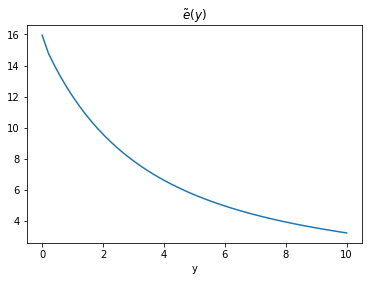

In [9]:
ems_1d = ems
plt.plot(y_grid, ems_1d)
plt.xlabel('y')
plt.title("$\\tilde e(y)$")

Text(0.5, 1.0, 'ϕ(y)')

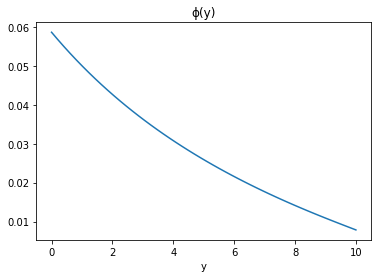

In [10]:
ϕ_1d = ϕ
plt.plot(y_grid, ϕ_1d)
plt.xlabel('y')
plt.title('ϕ(y)')

In [13]:
# compute hˢ
def compute_h_star(ϕ, ems, y_grid, args=(η, σy, γ1, γ2, ξₘ)):
    η, σy, γ1, γ2, ξₘ = args
    dy = y_grid[1] - y_grid[0]
    dϕdy = derivative_1d(ϕ, 1, dy)
    dΛ = γ1 + γ2*y_grid
    h_star = dϕdy + (η-1)*dΛ
    h_star *= ems*σy
    h_star *= - 1/ξₘ
    return h_star

In [14]:
args = (η, σy, γ1, γ2, ξₘ)
h_1d = compute_h_star(ϕ_1d, ems_1d, y_grid, args)

Text(0.5, 1.0, 'h')

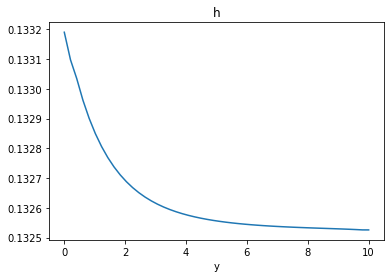

In [15]:
plt.plot(y_grid, h_1d)
plt.xlabel('y')
plt.title("h")

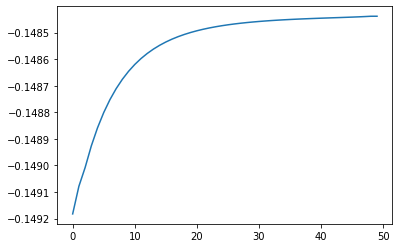

In [16]:
plt.plot( (dϕdy + (η-1)*(γ1 + γ2*y_grid))*ems_1d)

In [17]:
ems_1d

array([15.95051733, 14.79703068, 13.99084553, 13.25770438, 12.58424642,
       11.96446228, 11.39293194, 10.8648747 , 10.37606907,  9.92277782,
        9.50168447,  9.10983921,  8.74461266,  8.40365617,  8.08486766,
        7.78636209,  7.50644586,  7.24359462,  6.9964339 ,  6.76372224,
        6.54433647,  6.33725869,  6.14156498,  5.95641537,  5.78104504,
        5.61475653,  5.45691282,  5.30693128,  5.1642782 ,  5.02846393,
        4.89903862,  4.7755883 ,  4.65773142,  4.54511572,  4.43741535,
        4.33432829,  4.23557394,  4.14089086,  4.05003464,  3.96277582,
        3.87889782,  3.79819483,  3.72046952,  3.64553054,  3.57318964,
        3.50325823,  3.43554315,  3.36984136,  3.30593308,  3.24360813])

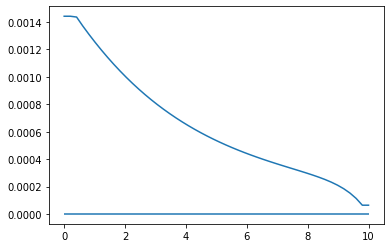

In [18]:
plt.plot(y_grid, dϕdyy)
plt.hlines(y=0, xmin=0, xmax=10)

# With reserve constraint
$$
\begin{aligned}
0 = \max_{\tilde e}\min_h & \quad b \delta\eta \log\tilde e \\
&  + b \frac{\xi_m}{2} h'h + \frac{dV}{dy} \tilde e (\theta + \sigma_y h) - \delta b \frac{dV}{db} + \frac{1}{2}\frac{d^2V}{dy^2}|\sigma_y|^2(\tilde e)^2\\
                           & + b(\eta -1 )\cdot(\gamma_1 + \gamma_2 y)\cdot\tilde e\cdot (\theta + \sigma_y h) - \ell \tilde e
\end{aligned}
$$

$$
h^* = - \frac{\frac{dV}{dy} + b(\eta-1)(\gamma_1 + \gamma_2 y)}{b \xi_m} \cdot \tilde e \sigma_y
$$
Plug back into the HJB:
$$
\begin{aligned}
0 = \max_{\tilde e } \quad & b \delta\eta \log \tilde e + \frac{dV}{dy} \tilde e \theta - \delta b \frac{dV}{db} + \frac{1}{2}\frac{d^2V}{dy^2}|\sigma_y|^2(\tilde e)^2 \\ 
& +  b(\eta -1 )\cdot(\gamma_1 + \gamma_2 y)\cdot\tilde e\cdot \theta - \ell \tilde e \\
& -\frac{1}{2b\xi_m}\left(\frac{dV}{dy} + b(\eta-1)(\gamma_1 + \gamma_2 y)\right)^2 (\tilde e)^2 |\sigma_y|^2
\end{aligned}
$$
First order condition for $\tilde e ^*$:
$$
  \left[- \frac{1}{b\xi_m}\left( \frac{dV}{dy}  + b(\eta -1)(\gamma_1 + \gamma_2 y) \right)^2 + \frac{d^2V}{dy^2}\right] \cdot|\sigma_y|^2\cdot(\tilde e)^2 + \left[\frac{dV}{dy}\theta + b(\eta - 1)(\gamma_1 + \gamma_2 y)\theta - \ell \right]\tilde e + b \delta\eta = 0
$$

$$
A =  \left[- \frac{1}{b\xi_m}\left( \frac{dV}{dy}  + b(\eta -1)(\gamma_1 + \gamma_2 y) \right)^2 + \frac{d^2V}{dy^2}\right] \cdot|\sigma_y|^2
$$

$$
B = \left[\frac{dV}{dy} + b(\eta - 1)(\gamma_1 + \gamma_2 y)\right]\theta - \ell
$$ 

$$
C = b \delta\eta
$$
And
$$
\tilde e^* = \frac{-B -  \sqrt{B^2 - 4AC}}{2A}
$$

In [89]:
b_grid = np.linspace(1e-10, 1, 100)
y_grid = np.linspace(1e-10, 10, 100)
# mesh grid and construct state space
(y_mat, b_mat) = np.meshgrid(y_grid, b_grid, indexing = 'ij')
stateSpace = np.hstack([y_mat.reshape(-1,1, order='F'), b_mat.reshape(-1,1,order='F')])
hb = b_grid[1] - b_grid[0]
hy = y_grid[1] - y_grid[0]

In [21]:
# 2 state HJB with constraints
θ = μ
δ = 0.01
η = 0.032

ϵ = 0.3
# ℓ = 1e-12
ξₘ = 1/400
σy = 1.2*θ

tol = 1e-8
dΛ = γ1 + γ2*y_mat


v_dict = dict()
ems_dict = dict()
ℓ_step = 1e-16

for ℓ in [1e-12, 1e-5]:
    episode = 0
    lhs_error = 1
    ems = - δ*η/(b_mat*(η-1)*dΛ*θ)
    ems_old = ems
    while lhs_error > tol:
        if episode ==0:
            v0 =  - δ*η*y_mat**2
        else:
            vold = v0.copy()
        v0_dy = derivatives_2d(v0,0,1,hy)
        v0_dyy = derivatives_2d(v0,0,2,hy)
        v0_db = derivatives_2d(v0,1,1,hb)
        # updating controls

        print(np.min(ems))
        temp = v0_dy + b_mat*(η-1)*dΛ
        a = v0_dyy*σy**2 - temp**2/(b_mat*ξₘ)*σy**2
        b = temp*θ  - ℓ
        c = δ*η*b_mat
        Δ = b**2 - 4*c*a
        Δ[Δ<0] = 0
        ems_new =  -b/(2*a) - np.sqrt(Δ)/(2*a)
        ems_new[ems_new <= 0] = 1e-15
        ems = ems_new
        # HJB coefficient
        A =  np.zeros(y_mat.shape)
        B_y =  ems*θ
        B_b = - δ*b_mat
        C_yy = ems**2*σy**2/2
        C_bb = np.zeros(y_mat.shape)
        D = b_mat*δ*η*np.log(ems) + b_mat*(η-1)*dΛ*ems*θ - ℓ*ems - temp**2*ems**2*σy**2/(2*b_mat*ξₘ)
        # PDE solver
        solve_start = time.time()
        out = PDESolver_2d(stateSpace, A, B_y, B_b, C_yy, C_bb, D, v0, ϵ, solverType = 'False Transient')
        out_comp = out[2].reshape(v0.shape,order = "F")
        rhs = A*v0 + B_y*v0_dy + B_b*v0_db + C_yy*v0_dyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((out_comp - v0)))
        #     if episode % 1 == 0:
        print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode,
              rhs_error, lhs_error, out[0], out[1]))
        episode += 1
        v0 = out_comp
        ems_old = ems
        print("End of PDE solver, takes time: {}".format(time.time() - solve_start))
    
    v_dict[ℓ] = v0
    ems_dict[ℓ] = ems

4.023165647291287
Episode 0: PDE Error: 0.001570491698; False Transient Error: 0.000473047417; Iterations: 330; CG Error: 0.000000000082
End of PDE solver, takes time: 0.041060686111450195
2.331103050065163e-09
Episode 1: PDE Error: 0.001425143088; False Transient Error: 0.000811705856; Iterations: 834; CG Error: 0.000000000070
End of PDE solver, takes time: 0.09346294403076172
2.3311030500726075e-09
Episode 2: PDE Error: 0.001952751715; False Transient Error: 0.000480379355; Iterations: 249; CG Error: 0.000000000055
End of PDE solver, takes time: 0.028951168060302734
2.3311030500674525e-09
Episode 3: PDE Error: 0.001681436271; False Transient Error: 0.000423184475; Iterations: 113; CG Error: 0.000000000075
End of PDE solver, takes time: 0.014397859573364258
2.3311030500610402e-09
Episode 4: PDE Error: 0.001459975175; False Transient Error: 0.000374731641; Iterations: 48; CG Error: 0.000000000090
End of PDE solver, takes time: 0.007290363311767578
2.3311030500581964e-09
Episode 5: PDE 

Episode 57: PDE Error: 0.000643065480; False Transient Error: 0.000191704129; Iterations: 15; CG Error: 0.000000000069
End of PDE solver, takes time: 0.004099845886230469
2.331103050061846e-09
Episode 58: PDE Error: 0.000638686789; False Transient Error: 0.000190406402; Iterations: 15; CG Error: 0.000000000066
End of PDE solver, takes time: 0.0038819313049316406
2.3311030500628236e-09
Episode 59: PDE Error: 0.000634367255; False Transient Error: 0.000189125962; Iterations: 15; CG Error: 0.000000000063
End of PDE solver, takes time: 0.004009723663330078
2.331103050063731e-09
Episode 60: PDE Error: 0.000630105139; False Transient Error: 0.000187862309; Iterations: 15; CG Error: 0.000000000060
End of PDE solver, takes time: 0.003784656524658203
2.331103050064559e-09
Episode 61: PDE Error: 0.000625898787; False Transient Error: 0.000186614969; Iterations: 15; CG Error: 0.000000000057
End of PDE solver, takes time: 0.003942251205444336
2.3311030500653895e-09
Episode 62: PDE Error: 0.0006217

2.33110305007711e-09
Episode 113: PDE Error: 0.000459212375; False Transient Error: 0.000137056844; Iterations: 14; CG Error: 0.000000000040
End of PDE solver, takes time: 0.003832578659057617
2.3311030500771355e-09
Episode 114: PDE Error: 0.000456710017; False Transient Error: 0.000136311439; Iterations: 14; CG Error: 0.000000000039
End of PDE solver, takes time: 0.0037381649017333984
2.33110305007711e-09
Episode 115: PDE Error: 0.000454226952; False Transient Error: 0.000135571750; Iterations: 14; CG Error: 0.000000000039
End of PDE solver, takes time: 0.003836393356323242
2.3311030500771843e-09
Episode 116: PDE Error: 0.000451762912; False Transient Error: 0.000134837698; Iterations: 14; CG Error: 0.000000000038
End of PDE solver, takes time: 0.0036716461181640625
2.3311030500772364e-09
Episode 117: PDE Error: 0.000449317636; False Transient Error: 0.000134109208; Iterations: 14; CG Error: 0.000000000037
End of PDE solver, takes time: 0.0037708282470703125
2.331103050077286e-09
Epis

2.331103050029102e-09
Episode 169: PDE Error: 0.000343089228; False Transient Error: 0.000102438382; Iterations: 13; CG Error: 0.000000000058
End of PDE solver, takes time: 0.003696918487548828
2.33110305002802e-09
Episode 170: PDE Error: 0.000341375722; False Transient Error: 0.000101927202; Iterations: 13; CG Error: 0.000000000058
End of PDE solver, takes time: 0.003638744354248047
2.331103050026862e-09
Episode 171: PDE Error: 0.000339672497; False Transient Error: 0.000101419080; Iterations: 13; CG Error: 0.000000000057
End of PDE solver, takes time: 0.0036847591400146484
2.331103050025756e-09
Episode 172: PDE Error: 0.000337979457; False Transient Error: 0.000100913989; Iterations: 13; CG Error: 0.000000000056
End of PDE solver, takes time: 0.003550291061401367
2.331103050024751e-09
Episode 173: PDE Error: 0.000336296511; False Transient Error: 0.000100411901; Iterations: 13; CG Error: 0.000000000055
End of PDE solver, takes time: 0.0036821365356445312
2.331103050023694e-09
Episode

2.3311030499796854e-09
Episode 226: PDE Error: 0.000259523534; False Transient Error: 0.000077499963; Iterations: 13; CG Error: 0.000000000031
End of PDE solver, takes time: 0.0036008358001708984
2.3311030499790062e-09
Episode 227: PDE Error: 0.000258277509; False Transient Error: 0.000077127994; Iterations: 13; CG Error: 0.000000000031
End of PDE solver, takes time: 0.003773927688598633
2.331103049978428e-09
Episode 228: PDE Error: 0.000257037992; False Transient Error: 0.000076757964; Iterations: 13; CG Error: 0.000000000030
End of PDE solver, takes time: 0.003595113754272461
2.331103049977749e-09
Episode 229: PDE Error: 0.000255804937; False Transient Error: 0.000076389860; Iterations: 13; CG Error: 0.000000000030
End of PDE solver, takes time: 0.003702878952026367
2.331103049977146e-09
Episode 230: PDE Error: 0.000254578298; False Transient Error: 0.000076023669; Iterations: 13; CG Error: 0.000000000030
End of PDE solver, takes time: 0.0035448074340820312
2.3311030499765173e-09
Epi

2.3311030499407566e-09
Episode 282: PDE Error: 0.000198652288; False Transient Error: 0.000059325080; Iterations: 12; CG Error: 0.000000000069
End of PDE solver, takes time: 0.0036499500274658203
2.3311030499401015e-09
Episode 283: PDE Error: 0.000197711360; False Transient Error: 0.000059044090; Iterations: 12; CG Error: 0.000000000069
End of PDE solver, takes time: 0.0037038326263427734
2.3311030499394223e-09
Episode 284: PDE Error: 0.000196774960; False Transient Error: 0.000058764451; Iterations: 12; CG Error: 0.000000000068
End of PDE solver, takes time: 0.003659963607788086
2.331103049938768e-09
Episode 285: PDE Error: 0.000195843062; False Transient Error: 0.000058486155; Iterations: 12; CG Error: 0.000000000068
End of PDE solver, takes time: 0.00357818603515625
2.3311030499381402e-09
Episode 286: PDE Error: 0.000194915638; False Transient Error: 0.000058209195; Iterations: 12; CG Error: 0.000000000067
End of PDE solver, takes time: 0.0037217140197753906
2.3311030499375107e-09
E

2.3311030499086173e-09
Episode 338: PDE Error: 0.000152261662; False Transient Error: 0.000045469962; Iterations: 12; CG Error: 0.000000000046
End of PDE solver, takes time: 0.0038614273071289062
2.3311030499080887e-09
Episode 339: PDE Error: 0.000151538275; False Transient Error: 0.000045253892; Iterations: 12; CG Error: 0.000000000045
End of PDE solver, takes time: 0.003763914108276367
2.331103049907586e-09
Episode 340: PDE Error: 0.000150818195; False Transient Error: 0.000045038810; Iterations: 12; CG Error: 0.000000000045
End of PDE solver, takes time: 0.003699064254760742
2.331103049907159e-09
Episode 341: PDE Error: 0.000150101405; False Transient Error: 0.000044824709; Iterations: 12; CG Error: 0.000000000045
End of PDE solver, takes time: 0.003988504409790039
2.33110304990668e-09
Episode 342: PDE Error: 0.000149387886; False Transient Error: 0.000044611585; Iterations: 12; CG Error: 0.000000000044
End of PDE solver, takes time: 0.0036339759826660156
2.3311030499062276e-09
Epis

2.331103049883318e-09
Episode 394: PDE Error: 0.000116400935; False Transient Error: 0.000034757979; Iterations: 12; CG Error: 0.000000000031
End of PDE solver, takes time: 0.003449678421020508
2.3311030498829416e-09
Episode 395: PDE Error: 0.000115838826; False Transient Error: 0.000034590062; Iterations: 12; CG Error: 0.000000000031
End of PDE solver, takes time: 0.0035834312438964844
2.331103049882562e-09
Episode 396: PDE Error: 0.000115279206; False Transient Error: 0.000034422887; Iterations: 12; CG Error: 0.000000000031
End of PDE solver, takes time: 0.0035505294799804688
2.331103049882112e-09
Episode 397: PDE Error: 0.000114722062; False Transient Error: 0.000034256452; Iterations: 12; CG Error: 0.000000000031
End of PDE solver, takes time: 0.0035614967346191406
2.331103049881709e-09
Episode 398: PDE Error: 0.000114167383; False Transient Error: 0.000034090753; Iterations: 12; CG Error: 0.000000000031
End of PDE solver, takes time: 0.0034761428833007812
2.331103049881279e-09
Epi

2.331103049917645e-09
Episode 451: PDE Error: 0.000088006000; False Transient Error: 0.000026275320; Iterations: 11; CG Error: 0.000000000085
End of PDE solver, takes time: 0.003457307815551758
2.3311030499193037e-09
Episode 452: PDE Error: 0.000087568411; False Transient Error: 0.000026144592; Iterations: 11; CG Error: 0.000000000085
End of PDE solver, takes time: 0.003414154052734375
2.331103049920939e-09
Episode 453: PDE Error: 0.000087132724; False Transient Error: 0.000026014432; Iterations: 11; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0034940242767333984
2.331103049922599e-09
Episode 454: PDE Error: 0.000086698932; False Transient Error: 0.000025884837; Iterations: 11; CG Error: 0.000000000084
End of PDE solver, takes time: 0.003375530242919922
2.331103049924233e-09
Episode 455: PDE Error: 0.000086267024; False Transient Error: 0.000025755806; Iterations: 11; CG Error: 0.000000000084
End of PDE solver, takes time: 0.0035505294799804688
2.331103049925894e-09
Episo

2.3311030500001324e-09
Episode 508: PDE Error: 0.000065863891; False Transient Error: 0.000019660357; Iterations: 11; CG Error: 0.000000000063
End of PDE solver, takes time: 0.003434896469116211
2.3311030500014146e-09
Episode 509: PDE Error: 0.000065522193; False Transient Error: 0.000019558273; Iterations: 11; CG Error: 0.000000000063
End of PDE solver, takes time: 0.003679037094116211
2.3311030500026967e-09
Episode 510: PDE Error: 0.000065181971; False Transient Error: 0.000019456631; Iterations: 11; CG Error: 0.000000000062
End of PDE solver, takes time: 0.003371715545654297
2.331103050003877e-09
Episode 511: PDE Error: 0.000064843218; False Transient Error: 0.000019355428; Iterations: 11; CG Error: 0.000000000062
End of PDE solver, takes time: 0.0034646987915039062
2.3311030500050856e-09
Episode 512: PDE Error: 0.000064505928; False Transient Error: 0.000019254662; Iterations: 11; CG Error: 0.000000000062
End of PDE solver, takes time: 0.0033469200134277344
2.331103050006343e-09
Ep

2.3311030500613413e-09
Episode 565: PDE Error: 0.000048567395; False Transient Error: 0.000014493033; Iterations: 11; CG Error: 0.000000000048
End of PDE solver, takes time: 0.003536701202392578
2.3311030500621966e-09
Episode 566: PDE Error: 0.000048300480; False Transient Error: 0.000014413293; Iterations: 11; CG Error: 0.000000000048
End of PDE solver, takes time: 0.0033957958221435547
2.3311030500631504e-09
Episode 567: PDE Error: 0.000048034722; False Transient Error: 0.000014333900; Iterations: 11; CG Error: 0.000000000047
End of PDE solver, takes time: 0.0034198760986328125
2.3311030500640578e-09
Episode 568: PDE Error: 0.000047770117; False Transient Error: 0.000014254850; Iterations: 11; CG Error: 0.000000000047
End of PDE solver, takes time: 0.0033974647521972656
2.331103050064961e-09
Episode 569: PDE Error: 0.000047506660; False Transient Error: 0.000014176144; Iterations: 11; CG Error: 0.000000000047
End of PDE solver, takes time: 0.003421783447265625
2.3311030500658685e-09


2.331103050106206e-09
Episode 622: PDE Error: 0.000035066925; False Transient Error: 0.000010459938; Iterations: 11; CG Error: 0.000000000037
End of PDE solver, takes time: 0.0034046173095703125
2.3311030501068594e-09
Episode 623: PDE Error: 0.000034858860; False Transient Error: 0.000010397784; Iterations: 11; CG Error: 0.000000000037
End of PDE solver, takes time: 0.003445148468017578
2.3311030501074633e-09
Episode 624: PDE Error: 0.000034651709; False Transient Error: 0.000010335902; Iterations: 11; CG Error: 0.000000000037
End of PDE solver, takes time: 0.0033540725708007812
2.331103050108091e-09
Episode 625: PDE Error: 0.000034445469; False Transient Error: 0.000010274293; Iterations: 11; CG Error: 0.000000000037
End of PDE solver, takes time: 0.0034637451171875
2.331103050108771e-09
Episode 626: PDE Error: 0.000034240135; False Transient Error: 0.000010212955; Iterations: 11; CG Error: 0.000000000037
End of PDE solver, takes time: 0.0034232139587402344
2.33110305010945e-09
Episod

2.3311030501389234e-09
Episode 679: PDE Error: 0.000024563198; False Transient Error: 0.000007322337; Iterations: 11; CG Error: 0.000000000029
End of PDE solver, takes time: 0.0034346580505371094
2.331103050139452e-09
Episode 680: PDE Error: 0.000024401738; False Transient Error: 0.000007274110; Iterations: 11; CG Error: 0.000000000029
End of PDE solver, takes time: 0.0034639835357666016
2.3311030501399045e-09
Episode 681: PDE Error: 0.000024241003; False Transient Error: 0.000007226099; Iterations: 11; CG Error: 0.000000000029
End of PDE solver, takes time: 0.003493070602416992
2.331103050140408e-09
Episode 682: PDE Error: 0.000024080991; False Transient Error: 0.000007178304; Iterations: 11; CG Error: 0.000000000029
End of PDE solver, takes time: 0.003328084945678711
2.3311030501408855e-09
Episode 683: PDE Error: 0.000023921699; False Transient Error: 0.000007130723; Iterations: 10; CG Error: 0.000000000100
End of PDE solver, takes time: 0.0034151077270507812
2.331103050141338e-09
Ep

2.3311030502355174e-09
Episode 737: PDE Error: 0.000020218978; False Transient Error: 0.000006064306; Iterations: 10; CG Error: 0.000000000080
End of PDE solver, takes time: 0.003381490707397461
2.3311030502371015e-09
Episode 738: PDE Error: 0.000020214729; False Transient Error: 0.000006063002; Iterations: 10; CG Error: 0.000000000079
End of PDE solver, takes time: 0.003240823745727539
2.3311030502386103e-09
Episode 739: PDE Error: 0.000020210381; False Transient Error: 0.000006061668; Iterations: 10; CG Error: 0.000000000079
End of PDE solver, takes time: 0.0033948421478271484
2.331103050240168e-09
Episode 740: PDE Error: 0.000020205934; False Transient Error: 0.000006060305; Iterations: 10; CG Error: 0.000000000079
End of PDE solver, takes time: 0.0034177303314208984
2.331103050241703e-09
Episode 741: PDE Error: 0.000020201388; False Transient Error: 0.000006058912; Iterations: 10; CG Error: 0.000000000078
End of PDE solver, takes time: 0.00341033935546875
2.3311030502432383e-09
Epi

Episode 794: PDE Error: 0.000019829414; False Transient Error: 0.000005945942; Iterations: 10; CG Error: 0.000000000067
End of PDE solver, takes time: 0.003242969512939453
2.3311030503165935e-09
Episode 795: PDE Error: 0.000019820102; False Transient Error: 0.000005943126; Iterations: 10; CG Error: 0.000000000067
End of PDE solver, takes time: 0.0033516883850097656
2.3311030503178517e-09
Episode 796: PDE Error: 0.000019810711; False Transient Error: 0.000005940285; Iterations: 10; CG Error: 0.000000000067
End of PDE solver, takes time: 0.0032706260681152344
2.331103050319109e-09
Episode 797: PDE Error: 0.000019801243; False Transient Error: 0.000005937422; Iterations: 10; CG Error: 0.000000000067
End of PDE solver, takes time: 0.0033822059631347656
2.3311030503203167e-09
Episode 798: PDE Error: 0.000019791696; False Transient Error: 0.000005934535; Iterations: 10; CG Error: 0.000000000067
End of PDE solver, takes time: 0.003362417221069336
2.3311030503214987e-09
Episode 799: PDE Error:

2.3311030503817787e-09
Episode 853: PDE Error: 0.000019156150; False Transient Error: 0.000005742757; Iterations: 10; CG Error: 0.000000000059
End of PDE solver, takes time: 0.0033981800079345703
2.3311030503827845e-09
Episode 854: PDE Error: 0.000019142751; False Transient Error: 0.000005738720; Iterations: 10; CG Error: 0.000000000059
End of PDE solver, takes time: 0.003231048583984375
2.3311030503837912e-09
Episode 855: PDE Error: 0.000019129292; False Transient Error: 0.000005734665; Iterations: 10; CG Error: 0.000000000058
End of PDE solver, takes time: 0.003421306610107422
2.3311030503847458e-09
Episode 856: PDE Error: 0.000019115773; False Transient Error: 0.000005730591; Iterations: 10; CG Error: 0.000000000058
End of PDE solver, takes time: 0.003223419189453125
2.331103050385701e-09
Episode 857: PDE Error: 0.000019102195; False Transient Error: 0.000005726500; Iterations: 10; CG Error: 0.000000000058
End of PDE solver, takes time: 0.0033669471740722656
2.3311030503866582e-09
E

Episode 911: PDE Error: 0.000018288154; False Transient Error: 0.000005481464; Iterations: 10; CG Error: 0.000000000041
End of PDE solver, takes time: 0.003601551055908203
2.3311030504235257e-09
Episode 912: PDE Error: 0.000018271719; False Transient Error: 0.000005476521; Iterations: 10; CG Error: 0.000000000041
End of PDE solver, takes time: 0.0032918453216552734
2.3311030504240278e-09
Episode 913: PDE Error: 0.000018255240; False Transient Error: 0.000005471564; Iterations: 10; CG Error: 0.000000000041
End of PDE solver, takes time: 0.0034055709838867188
2.331103050424557e-09
Episode 914: PDE Error: 0.000018238716; False Transient Error: 0.000005466594; Iterations: 10; CG Error: 0.000000000041
End of PDE solver, takes time: 0.0032415390014648438
2.3311030504250857e-09
Episode 915: PDE Error: 0.000018222148; False Transient Error: 0.000005461610; Iterations: 10; CG Error: 0.000000000041
End of PDE solver, takes time: 0.0033693313598632812
2.3311030504256126e-09
Episode 916: PDE Error

2.331103050456292e-09
Episode 970: PDE Error: 0.000017249821; False Transient Error: 0.000005169305; Iterations: 10; CG Error: 0.000000000051
End of PDE solver, takes time: 0.003292560577392578
2.3311030504569214e-09
Episode 971: PDE Error: 0.000017231153; False Transient Error: 0.000005163695; Iterations: 10; CG Error: 0.000000000051
End of PDE solver, takes time: 0.0033483505249023438
2.331103050457526e-09
Episode 972: PDE Error: 0.000017212453; False Transient Error: 0.000005158076; Iterations: 10; CG Error: 0.000000000051
End of PDE solver, takes time: 0.0032739639282226562
2.3311030504581035e-09
Episode 973: PDE Error: 0.000017193723; False Transient Error: 0.000005152448; Iterations: 10; CG Error: 0.000000000051
End of PDE solver, takes time: 0.003353595733642578
2.331103050458732e-09
Episode 974: PDE Error: 0.000017174962; False Transient Error: 0.000005146811; Iterations: 10; CG Error: 0.000000000051
End of PDE solver, takes time: 0.0032596588134765625
2.331103050459311e-09
Epi

2.3311030504917027e-09
Episode 1028: PDE Error: 0.000016121833; False Transient Error: 0.000004830475; Iterations: 10; CG Error: 0.000000000053
End of PDE solver, takes time: 0.00325775146484375
2.3311030504923305e-09
Episode 1029: PDE Error: 0.000016101690; False Transient Error: 0.000004824426; Iterations: 10; CG Error: 0.000000000053
End of PDE solver, takes time: 0.0033745765686035156
2.3311030504929336e-09
Episode 1030: PDE Error: 0.000016081526; False Transient Error: 0.000004818371; Iterations: 10; CG Error: 0.000000000053
End of PDE solver, takes time: 0.0032999515533447266
2.3311030504935366e-09
Episode 1031: PDE Error: 0.000016061344; False Transient Error: 0.000004812311; Iterations: 10; CG Error: 0.000000000053
End of PDE solver, takes time: 0.0035309791564941406
2.3311030504941173e-09
Episode 1032: PDE Error: 0.000016041142; False Transient Error: 0.000004806244; Iterations: 10; CG Error: 0.000000000053
End of PDE solver, takes time: 0.0033600330352783203
2.331103050494743

Episode 1085: PDE Error: 0.000014947251; False Transient Error: 0.000004477852; Iterations: 10; CG Error: 0.000000000052
End of PDE solver, takes time: 0.003699779510498047
2.3311030505246195e-09
Episode 1086: PDE Error: 0.000014926258; False Transient Error: 0.000004471551; Iterations: 10; CG Error: 0.000000000052
End of PDE solver, takes time: 0.003272533416748047
2.331103050525149e-09
Episode 1087: PDE Error: 0.000014905255; False Transient Error: 0.000004465247; Iterations: 10; CG Error: 0.000000000052
End of PDE solver, takes time: 0.0034677982330322266
2.3311030505257007e-09
Episode 1088: PDE Error: 0.000014884242; False Transient Error: 0.000004458941; Iterations: 10; CG Error: 0.000000000052
End of PDE solver, takes time: 0.003378152847290039
2.3311030505262557e-09
Episode 1089: PDE Error: 0.000014863220; False Transient Error: 0.000004452631; Iterations: 10; CG Error: 0.000000000052
End of PDE solver, takes time: 0.0034394264221191406
2.331103050526733e-09
Episode 1090: PDE Er

2.3311030505522077e-09
Episode 1142: PDE Error: 0.000013739078; False Transient Error: 0.000004115306; Iterations: 10; CG Error: 0.000000000049
End of PDE solver, takes time: 0.0032575130462646484
2.331103050552685e-09
Episode 1143: PDE Error: 0.000013717753; False Transient Error: 0.000004108908; Iterations: 10; CG Error: 0.000000000049
End of PDE solver, takes time: 0.003392457962036133
2.3311030505531126e-09
Episode 1144: PDE Error: 0.000013696427; False Transient Error: 0.000004102510; Iterations: 10; CG Error: 0.000000000049
End of PDE solver, takes time: 0.0033376216888427734
2.33110305055359e-09
Episode 1145: PDE Error: 0.000013675099; False Transient Error: 0.000004096111; Iterations: 10; CG Error: 0.000000000049
End of PDE solver, takes time: 0.0033349990844726562
2.3311030505540184e-09
Episode 1146: PDE Error: 0.000013653770; False Transient Error: 0.000004089712; Iterations: 10; CG Error: 0.000000000049
End of PDE solver, takes time: 0.0032312870025634766
2.3311030505544956e

2.33110305057655e-09
Episode 1200: PDE Error: 0.000012505212; False Transient Error: 0.000003744733; Iterations: 10; CG Error: 0.000000000046
End of PDE solver, takes time: 0.0032494068145751953
2.3311030505769792e-09
Episode 1201: PDE Error: 0.000012484087; False Transient Error: 0.000003738374; Iterations: 10; CG Error: 0.000000000046
End of PDE solver, takes time: 0.003377676010131836
2.331103050577406e-09
Episode 1202: PDE Error: 0.000012462966; False Transient Error: 0.000003732018; Iterations: 10; CG Error: 0.000000000046
End of PDE solver, takes time: 0.003232240676879883
2.3311030505778337e-09
Episode 1203: PDE Error: 0.000012441852; False Transient Error: 0.000003725663; Iterations: 10; CG Error: 0.000000000046
End of PDE solver, takes time: 0.0033071041107177734
2.3311030505782374e-09
Episode 1204: PDE Error: 0.000012420743; False Transient Error: 0.000003719310; Iterations: 10; CG Error: 0.000000000046
End of PDE solver, takes time: 0.0033082962036132812
2.331103050578589e-0

Episode 1258: PDE Error: 0.000011294781; False Transient Error: 0.000003379945; Iterations: 10; CG Error: 0.000000000042
End of PDE solver, takes time: 0.003504037857055664
2.3311030505979772e-09
Episode 1259: PDE Error: 0.000011274272; False Transient Error: 0.000003373745; Iterations: 10; CG Error: 0.000000000042
End of PDE solver, takes time: 0.0033812522888183594
2.331103050598304e-09
Episode 1260: PDE Error: 0.000011253775; False Transient Error: 0.000003367549; Iterations: 10; CG Error: 0.000000000042
End of PDE solver, takes time: 0.003253459930419922
2.3311030505986547e-09
Episode 1261: PDE Error: 0.000011233289; False Transient Error: 0.000003361357; Iterations: 10; CG Error: 0.000000000042
End of PDE solver, takes time: 0.0033311843872070312
2.331103050599007e-09
Episode 1262: PDE Error: 0.000011212814; False Transient Error: 0.000003355168; Iterations: 10; CG Error: 0.000000000042
End of PDE solver, takes time: 0.003283262252807617
2.3311030505993106e-09
Episode 1263: PDE Er

2.331103050615079e-09
Episode 1316: PDE Error: 0.000010128057; False Transient Error: 0.000003027280; Iterations: 10; CG Error: 0.000000000039
End of PDE solver, takes time: 0.003288745880126953
2.3311030506153795e-09
Episode 1317: PDE Error: 0.000010108402; False Transient Error: 0.000003021337; Iterations: 10; CG Error: 0.000000000038
End of PDE solver, takes time: 0.003355741500854492
2.331103050615682e-09
Episode 1318: PDE Error: 0.000010088763; False Transient Error: 0.000003015400; Iterations: 10; CG Error: 0.000000000038
End of PDE solver, takes time: 0.0033571720123291016
2.3311030506159337e-09
Episode 1319: PDE Error: 0.000010069140; False Transient Error: 0.000003009469; Iterations: 10; CG Error: 0.000000000038
End of PDE solver, takes time: 0.0034193992614746094
2.331103050616234e-09
Episode 1320: PDE Error: 0.000010049534; False Transient Error: 0.000003003542; Iterations: 10; CG Error: 0.000000000038
End of PDE solver, takes time: 0.003243684768676758
2.331103050616435e-09

Episode 1374: PDE Error: 0.000009019126; False Transient Error: 0.000002691860; Iterations: 10; CG Error: 0.000000000035
End of PDE solver, takes time: 0.003482341766357422
2.331103050629564e-09
Episode 1375: PDE Error: 0.000009000601; False Transient Error: 0.000002686253; Iterations: 10; CG Error: 0.000000000035
End of PDE solver, takes time: 0.0033500194549560547
2.331103050629789e-09
Episode 1376: PDE Error: 0.000008982101; False Transient Error: 0.000002680652; Iterations: 10; CG Error: 0.000000000034
End of PDE solver, takes time: 0.0032825469970703125
2.3311030506299908e-09
Episode 1377: PDE Error: 0.000008963621; False Transient Error: 0.000002675058; Iterations: 10; CG Error: 0.000000000034
End of PDE solver, takes time: 0.0033140182495117188
2.3311030506301934e-09
Episode 1378: PDE Error: 0.000008945161; False Transient Error: 0.000002669470; Iterations: 10; CG Error: 0.000000000034
End of PDE solver, takes time: 0.0032317638397216797
2.3311030506304192e-09
Episode 1379: PDE 

2.3311030506420105e-09
Episode 1433: PDE Error: 0.000007962592; False Transient Error: 0.000002372348; Iterations: 10; CG Error: 0.000000000031
End of PDE solver, takes time: 0.003346681594848633
2.3311030506421867e-09
Episode 1434: PDE Error: 0.000007945348; False Transient Error: 0.000002367139; Iterations: 10; CG Error: 0.000000000031
End of PDE solver, takes time: 0.0032265186309814453
2.331103050642338e-09
Episode 1435: PDE Error: 0.000007928127; False Transient Error: 0.000002361937; Iterations: 10; CG Error: 0.000000000031
End of PDE solver, takes time: 0.0033218860626220703
2.3311030506425408e-09
Episode 1436: PDE Error: 0.000007910929; False Transient Error: 0.000002356742; Iterations: 10; CG Error: 0.000000000031
End of PDE solver, takes time: 0.0032274723052978516
2.331103050642716e-09
Episode 1437: PDE Error: 0.000007893754; False Transient Error: 0.000002351554; Iterations: 10; CG Error: 0.000000000030
End of PDE solver, takes time: 0.0033736228942871094
2.331103050642918e

Episode 1491: PDE Error: 0.000007417913; False Transient Error: 0.000002082244; Iterations: 10; CG Error: 0.000000000027
End of PDE solver, takes time: 0.003709554672241211
2.33110305065192e-09
Episode 1492: PDE Error: 0.000007411329; False Transient Error: 0.000002077461; Iterations: 10; CG Error: 0.000000000027
End of PDE solver, takes time: 0.003264904022216797
2.3311030506520715e-09
Episode 1493: PDE Error: 0.000007404740; False Transient Error: 0.000002072686; Iterations: 10; CG Error: 0.000000000027
End of PDE solver, takes time: 0.0033674240112304688
2.3311030506522725e-09
Episode 1494: PDE Error: 0.000007398146; False Transient Error: 0.000002067918; Iterations: 10; CG Error: 0.000000000027
End of PDE solver, takes time: 0.0032453536987304688
2.331103050652424e-09
Episode 1495: PDE Error: 0.000007391548; False Transient Error: 0.000002063158; Iterations: 10; CG Error: 0.000000000027
End of PDE solver, takes time: 0.0032966136932373047
2.3311030506525984e-09
Episode 1496: PDE Er

2.3311030506423637e-09
Episode 1550: PDE Error: 0.000007024209; False Transient Error: 0.000001813067; Iterations: 9; CG Error: 0.000000000093
End of PDE solver, takes time: 0.0032384395599365234
2.331103050641835e-09
Episode 1551: PDE Error: 0.000007017503; False Transient Error: 0.000001808734; Iterations: 9; CG Error: 0.000000000093
End of PDE solver, takes time: 0.0033731460571289062
2.3311030506413314e-09
Episode 1552: PDE Error: 0.000007010797; False Transient Error: 0.000001804408; Iterations: 9; CG Error: 0.000000000093
End of PDE solver, takes time: 0.003213167190551758
2.3311030506408566e-09
Episode 1553: PDE Error: 0.000007004093; False Transient Error: 0.000001800091; Iterations: 9; CG Error: 0.000000000093
End of PDE solver, takes time: 0.003297567367553711
2.3311030506403272e-09
Episode 1554: PDE Error: 0.000006997389; False Transient Error: 0.000001795781; Iterations: 9; CG Error: 0.000000000092
End of PDE solver, takes time: 0.0031554698944091797
2.331103050639849e-09
E

Episode 1607: PDE Error: 0.000006645254; False Transient Error: 0.000001578291; Iterations: 9; CG Error: 0.000000000081
End of PDE solver, takes time: 0.0035140514373779297
2.3311030506160834e-09
Episode 1608: PDE Error: 0.000006638703; False Transient Error: 0.000001574393; Iterations: 9; CG Error: 0.000000000081
End of PDE solver, takes time: 0.0038826465606689453
2.3311030506156334e-09
Episode 1609: PDE Error: 0.000006632156; False Transient Error: 0.000001570502; Iterations: 9; CG Error: 0.000000000081
End of PDE solver, takes time: 0.003237485885620117
2.3311030506152297e-09
Episode 1610: PDE Error: 0.000006625614; False Transient Error: 0.000001566619; Iterations: 9; CG Error: 0.000000000081
End of PDE solver, takes time: 0.0033330917358398438
2.331103050614803e-09
Episode 1611: PDE Error: 0.000006619077; False Transient Error: 0.000001562743; Iterations: 9; CG Error: 0.000000000080
End of PDE solver, takes time: 0.003827810287475586
2.331103050614424e-09
Episode 1612: PDE Error:

Episode 1664: PDE Error: 0.000006280547; False Transient Error: 0.000001367985; Iterations: 9; CG Error: 0.000000000071
End of PDE solver, takes time: 0.003549814224243164
2.3311030505942053e-09
Episode 1665: PDE Error: 0.000006274331; False Transient Error: 0.000001364509; Iterations: 9; CG Error: 0.000000000070
End of PDE solver, takes time: 0.003356456756591797
2.331103050593853e-09
Episode 1666: PDE Error: 0.000006268122; False Transient Error: 0.000001361040; Iterations: 9; CG Error: 0.000000000070
End of PDE solver, takes time: 0.003171205520629883
2.3311030505935005e-09
Episode 1667: PDE Error: 0.000006261920; False Transient Error: 0.000001357578; Iterations: 9; CG Error: 0.000000000070
End of PDE solver, takes time: 0.003306150436401367
2.331103050593148e-09
Episode 1668: PDE Error: 0.000006255725; False Transient Error: 0.000001354123; Iterations: 9; CG Error: 0.000000000070
End of PDE solver, takes time: 0.003214120864868164
2.3311030505928222e-09
Episode 1669: PDE Error: 0.

2.331103050575797e-09
Episode 1723: PDE Error: 0.000005926802; False Transient Error: 0.000001175023; Iterations: 9; CG Error: 0.000000000061
End of PDE solver, takes time: 0.003232240676879883
2.3311030505754953e-09
Episode 1724: PDE Error: 0.000005921049; False Transient Error: 0.000001171960; Iterations: 9; CG Error: 0.000000000060
End of PDE solver, takes time: 0.003117084503173828
2.331103050575242e-09
Episode 1725: PDE Error: 0.000005915305; False Transient Error: 0.000001168905; Iterations: 9; CG Error: 0.000000000060
End of PDE solver, takes time: 0.003309488296508789
2.3311030505749675e-09
Episode 1726: PDE Error: 0.000005909569; False Transient Error: 0.000001165856; Iterations: 9; CG Error: 0.000000000060
End of PDE solver, takes time: 0.0031363964080810547
2.3311030505746656e-09
Episode 1727: PDE Error: 0.000005903841; False Transient Error: 0.000001162814; Iterations: 9; CG Error: 0.000000000060
End of PDE solver, takes time: 0.0032515525817871094
2.3311030505743885e-09
Ep

2.3311030505597516e-09
Episode 1782: PDE Error: 0.000005602371; False Transient Error: 0.000001005661; Iterations: 9; CG Error: 0.000000000052
End of PDE solver, takes time: 0.003161191940307617
2.3311030505595e-09
Episode 1783: PDE Error: 0.000005597142; False Transient Error: 0.000001002983; Iterations: 9; CG Error: 0.000000000052
End of PDE solver, takes time: 0.003211498260498047
2.331103050559275e-09
Episode 1784: PDE Error: 0.000005591922; False Transient Error: 0.000001000312; Iterations: 9; CG Error: 0.000000000052
End of PDE solver, takes time: 0.0031287670135498047
2.3311030505590493e-09
Episode 1785: PDE Error: 0.000005586710; False Transient Error: 0.000000997647; Iterations: 9; CG Error: 0.000000000051
End of PDE solver, takes time: 0.0032477378845214844
2.3311030505587953e-09
Episode 1786: PDE Error: 0.000005581509; False Transient Error: 0.000000994988; Iterations: 9; CG Error: 0.000000000051
End of PDE solver, takes time: 0.0031280517578125
2.331103050558571e-09
Episode

Episode 1840: PDE Error: 0.000005314275; False Transient Error: 0.000000860364; Iterations: 9; CG Error: 0.000000000044
End of PDE solver, takes time: 0.00341033935546875
2.3311030505465498e-09
Episode 1841: PDE Error: 0.000005309580; False Transient Error: 0.000000858031; Iterations: 9; CG Error: 0.000000000044
End of PDE solver, takes time: 0.003211498260498047
2.331103050546323e-09
Episode 1842: PDE Error: 0.000005304894; False Transient Error: 0.000000855705; Iterations: 9; CG Error: 0.000000000044
End of PDE solver, takes time: 0.0031380653381347656
2.331103050546147e-09
Episode 1843: PDE Error: 0.000005300217; False Transient Error: 0.000000853384; Iterations: 9; CG Error: 0.000000000044
End of PDE solver, takes time: 0.0032248497009277344
2.331103050545946e-09
Episode 1844: PDE Error: 0.000005295549; False Transient Error: 0.000000851069; Iterations: 9; CG Error: 0.000000000044
End of PDE solver, takes time: 0.003132343292236328
2.331103050545744e-09
Episode 1845: PDE Error: 0.0

Episode 1899: PDE Error: 0.000005052869; False Transient Error: 0.000000732121; Iterations: 9; CG Error: 0.000000000038
End of PDE solver, takes time: 0.0035059452056884766
2.331103050535333e-09
Episode 1900: PDE Error: 0.000005048709; False Transient Error: 0.000000730105; Iterations: 9; CG Error: 0.000000000038
End of PDE solver, takes time: 0.003155946731567383
2.331103050535157e-09
Episode 1901: PDE Error: 0.000005044558; False Transient Error: 0.000000728095; Iterations: 9; CG Error: 0.000000000038
End of PDE solver, takes time: 0.0032422542572021484
2.3311030505350313e-09
Episode 1902: PDE Error: 0.000005040415; False Transient Error: 0.000000726089; Iterations: 9; CG Error: 0.000000000038
End of PDE solver, takes time: 0.0031235218048095703
2.3311030505348303e-09
Episode 1903: PDE Error: 0.000005036282; False Transient Error: 0.000000724089; Iterations: 9; CG Error: 0.000000000037
End of PDE solver, takes time: 0.003243684768676758
2.3311030505346044e-09
Episode 1904: PDE Error:

2.3311030505262797e-09
Episode 1958: PDE Error: 0.000004822320; False Transient Error: 0.000000621549; Iterations: 9; CG Error: 0.000000000032
End of PDE solver, takes time: 0.003163576126098633
2.3311030505261275e-09
Episode 1959: PDE Error: 0.000004818668; False Transient Error: 0.000000619815; Iterations: 9; CG Error: 0.000000000032
End of PDE solver, takes time: 0.0032341480255126953
2.3311030505259546e-09
Episode 1960: PDE Error: 0.000004815024; False Transient Error: 0.000000618086; Iterations: 9; CG Error: 0.000000000032
End of PDE solver, takes time: 0.0031485557556152344
2.3311030505258032e-09
Episode 1961: PDE Error: 0.000004811389; False Transient Error: 0.000000616361; Iterations: 9; CG Error: 0.000000000032
End of PDE solver, takes time: 0.003275156021118164
2.3311030505256022e-09
Episode 1962: PDE Error: 0.000004807762; False Transient Error: 0.000000614641; Iterations: 9; CG Error: 0.000000000032
End of PDE solver, takes time: 0.0031576156616210938
2.331103050525426e-09


Episode 2016: PDE Error: 0.000004623881; False Transient Error: 0.000000528116; Iterations: 9; CG Error: 0.000000000027
End of PDE solver, takes time: 0.0033626556396484375
2.3311030505182825e-09
Episode 2017: PDE Error: 0.000004620692; False Transient Error: 0.000000526627; Iterations: 9; CG Error: 0.000000000027
End of PDE solver, takes time: 0.0032351016998291016
2.3311030505181816e-09
Episode 2018: PDE Error: 0.000004617510; False Transient Error: 0.000000525142; Iterations: 9; CG Error: 0.000000000027
End of PDE solver, takes time: 0.003143787384033203
2.3311030505180327e-09
Episode 2019: PDE Error: 0.000004614336; False Transient Error: 0.000000523660; Iterations: 9; CG Error: 0.000000000027
End of PDE solver, takes time: 0.0032994747161865234
2.3311030505178557e-09
Episode 2020: PDE Error: 0.000004611170; False Transient Error: 0.000000522183; Iterations: 9; CG Error: 0.000000000027
End of PDE solver, takes time: 0.0031604766845703125
2.331103050517782e-09
Episode 2021: PDE Erro

2.3311030505084515e-09
Episode 2074: PDE Error: 0.000004451081; False Transient Error: 0.000000447990; Iterations: 8; CG Error: 0.000000000094
End of PDE solver, takes time: 0.0030155181884765625
2.331103050508225e-09
Episode 2075: PDE Error: 0.000004448312; False Transient Error: 0.000000446715; Iterations: 8; CG Error: 0.000000000093
End of PDE solver, takes time: 0.003445863723754883
2.3311030505079212e-09
Episode 2076: PDE Error: 0.000004445551; False Transient Error: 0.000000445444; Iterations: 8; CG Error: 0.000000000093
End of PDE solver, takes time: 0.003047466278076172
2.3311030505076698e-09
Episode 2077: PDE Error: 0.000004442796; False Transient Error: 0.000000444175; Iterations: 8; CG Error: 0.000000000093
End of PDE solver, takes time: 0.003133535385131836
2.3311030505074183e-09
Episode 2078: PDE Error: 0.000004440049; False Transient Error: 0.000000442911; Iterations: 8; CG Error: 0.000000000093
End of PDE solver, takes time: 0.003014087677001953
2.3311030505071933e-09
Ep

2.331103050495046e-09
Episode 2134: PDE Error: 0.000004296707; False Transient Error: 0.000000377311; Iterations: 8; CG Error: 0.000000000079
End of PDE solver, takes time: 0.0030193328857421875
2.3311030504948204e-09
Episode 2135: PDE Error: 0.000004294328; False Transient Error: 0.000000376229; Iterations: 8; CG Error: 0.000000000079
End of PDE solver, takes time: 0.0031855106353759766
2.331103050494645e-09
Episode 2136: PDE Error: 0.000004291955; False Transient Error: 0.000000375149; Iterations: 8; CG Error: 0.000000000079
End of PDE solver, takes time: 0.0030183792114257812
2.331103050494443e-09
Episode 2137: PDE Error: 0.000004289588; False Transient Error: 0.000000374073; Iterations: 8; CG Error: 0.000000000078
End of PDE solver, takes time: 0.003175497055053711
2.3311030504942413e-09
Episode 2138: PDE Error: 0.000004287227; False Transient Error: 0.000000372999; Iterations: 8; CG Error: 0.000000000078
End of PDE solver, takes time: 0.0030100345611572266
2.33110305049409e-09
Epi

2.33110305048398e-09
Episode 2194: PDE Error: 0.000004164320; False Transient Error: 0.000000317381; Iterations: 8; CG Error: 0.000000000066
End of PDE solver, takes time: 0.003027200698852539
2.3311030504838296e-09
Episode 2195: PDE Error: 0.000004162285; False Transient Error: 0.000000316464; Iterations: 8; CG Error: 0.000000000066
End of PDE solver, takes time: 0.0031783580780029297
2.3311030504836286e-09
Episode 2196: PDE Error: 0.000004160255; False Transient Error: 0.000000315550; Iterations: 8; CG Error: 0.000000000066
End of PDE solver, takes time: 0.003034830093383789
2.3311030504834772e-09
Episode 2197: PDE Error: 0.000004158230; False Transient Error: 0.000000314639; Iterations: 8; CG Error: 0.000000000066
End of PDE solver, takes time: 0.0031278133392333984
2.3311030504833027e-09
Episode 2198: PDE Error: 0.000004156210; False Transient Error: 0.000000313730; Iterations: 8; CG Error: 0.000000000066
End of PDE solver, takes time: 0.0030372142791748047
2.3311030504831505e-09
E

2.3311030504750044e-09
Episode 2254: PDE Error: 0.000004051266; False Transient Error: 0.000000266682; Iterations: 8; CG Error: 0.000000000056
End of PDE solver, takes time: 0.0030264854431152344
2.331103050474878e-09
Episode 2255: PDE Error: 0.000004049531; False Transient Error: 0.000000265907; Iterations: 8; CG Error: 0.000000000056
End of PDE solver, takes time: 0.0032033920288085938
2.3311030504747025e-09
Episode 2256: PDE Error: 0.000004047800; False Transient Error: 0.000000265134; Iterations: 8; CG Error: 0.000000000056
End of PDE solver, takes time: 0.0030303001403808594
2.331103050474575e-09
Episode 2257: PDE Error: 0.000004046074; False Transient Error: 0.000000264364; Iterations: 8; CG Error: 0.000000000055
End of PDE solver, takes time: 0.0031130313873291016
2.3311030504744494e-09
Episode 2258: PDE Error: 0.000004044353; False Transient Error: 0.000000263596; Iterations: 8; CG Error: 0.000000000055
End of PDE solver, takes time: 0.0030100345611572266
2.331103050474298e-09


2.3311030504670312e-09
Episode 2314: PDE Error: 0.000003955040; False Transient Error: 0.000000223875; Iterations: 8; CG Error: 0.000000000047
End of PDE solver, takes time: 0.0030252933502197266
2.331103050466932e-09
Episode 2315: PDE Error: 0.000003953565; False Transient Error: 0.000000223222; Iterations: 8; CG Error: 0.000000000047
End of PDE solver, takes time: 0.0032148361206054688
2.3311030504667798e-09
Episode 2316: PDE Error: 0.000003952095; False Transient Error: 0.000000222570; Iterations: 8; CG Error: 0.000000000047
End of PDE solver, takes time: 0.003031492233276367
2.3311030504667045e-09
Episode 2317: PDE Error: 0.000003950628; False Transient Error: 0.000000221921; Iterations: 8; CG Error: 0.000000000047
End of PDE solver, takes time: 0.0031096935272216797
2.3311030504666027e-09
Episode 2318: PDE Error: 0.000003949166; False Transient Error: 0.000000221273; Iterations: 8; CG Error: 0.000000000046
End of PDE solver, takes time: 0.003009796142578125
2.3311030504665027e-09


2.331103050460744e-09
Episode 2374: PDE Error: 0.000003873360; False Transient Error: 0.000000187796; Iterations: 8; CG Error: 0.000000000039
End of PDE solver, takes time: 0.0030176639556884766
2.3311030504606694e-09
Episode 2375: PDE Error: 0.000003872110; False Transient Error: 0.000000187245; Iterations: 8; CG Error: 0.000000000039
End of PDE solver, takes time: 0.0032181739807128906
2.3311030504605925e-09
Episode 2376: PDE Error: 0.000003870864; False Transient Error: 0.000000186697; Iterations: 8; CG Error: 0.000000000039
End of PDE solver, takes time: 0.003022909164428711
2.331103050460494e-09
Episode 2377: PDE Error: 0.000003869621; False Transient Error: 0.000000186149; Iterations: 8; CG Error: 0.000000000039
End of PDE solver, takes time: 0.0031118392944335938
2.3311030504603923e-09
Episode 2378: PDE Error: 0.000003868381; False Transient Error: 0.000000185604; Iterations: 8; CG Error: 0.000000000039
End of PDE solver, takes time: 0.003010272979736328
2.3311030504602914e-09
E

2.3311030504556633e-09
Episode 2434: PDE Error: 0.000003804188; False Transient Error: 0.000000157430; Iterations: 8; CG Error: 0.000000000033
End of PDE solver, takes time: 0.0030214786529541016
2.331103050455613e-09
Episode 2435: PDE Error: 0.000003803130; False Transient Error: 0.000000156967; Iterations: 8; CG Error: 0.000000000033
End of PDE solver, takes time: 0.0031387805938720703
2.331103050455563e-09
Episode 2436: PDE Error: 0.000003802076; False Transient Error: 0.000000156505; Iterations: 8; CG Error: 0.000000000033
End of PDE solver, takes time: 0.003092050552368164
2.3311030504554887e-09
Episode 2437: PDE Error: 0.000003801024; False Transient Error: 0.000000156045; Iterations: 8; CG Error: 0.000000000033
End of PDE solver, takes time: 0.0031414031982421875
2.331103050455388e-09
Episode 2438: PDE Error: 0.000003799976; False Transient Error: 0.000000155586; Iterations: 8; CG Error: 0.000000000033
End of PDE solver, takes time: 0.003005504608154297
2.3311030504553134e-09
Ep

2.33110305045164e-09
Episode 2493: PDE Error: 0.000003746616; False Transient Error: 0.000000132293; Iterations: 8; CG Error: 0.000000000028
End of PDE solver, takes time: 0.0031261444091796875
2.3311030504515423e-09
Episode 2494: PDE Error: 0.000003745720; False Transient Error: 0.000000131903; Iterations: 8; CG Error: 0.000000000028
End of PDE solver, takes time: 0.003427743911743164
2.3311030504514877e-09
Episode 2495: PDE Error: 0.000003744827; False Transient Error: 0.000000131514; Iterations: 8; CG Error: 0.000000000028
End of PDE solver, takes time: 0.0032014846801757812
2.3311030504513644e-09
Episode 2496: PDE Error: 0.000003743937; False Transient Error: 0.000000131127; Iterations: 8; CG Error: 0.000000000028
End of PDE solver, takes time: 0.0030164718627929688
2.331103050451313e-09
Episode 2497: PDE Error: 0.000003743049; False Transient Error: 0.000000130740; Iterations: 8; CG Error: 0.000000000027
End of PDE solver, takes time: 0.003101348876953125
2.331103050451262e-09
Epi

2.3311030504566435e-09
Episode 2553: PDE Error: 0.000003697121; False Transient Error: 0.000000110795; Iterations: 7; CG Error: 0.000000000093
End of PDE solver, takes time: 0.003020763397216797
2.3311030504569214e-09
Episode 2554: PDE Error: 0.000003696366; False Transient Error: 0.000000110468; Iterations: 7; CG Error: 0.000000000092
End of PDE solver, takes time: 0.003373861312866211
2.3311030504571737e-09
Episode 2555: PDE Error: 0.000003695613; False Transient Error: 0.000000110141; Iterations: 7; CG Error: 0.000000000092
End of PDE solver, takes time: 0.0030853748321533203
2.331103050457475e-09
Episode 2556: PDE Error: 0.000003694862; False Transient Error: 0.000000109816; Iterations: 7; CG Error: 0.000000000092
End of PDE solver, takes time: 0.0029296875
2.3311030504577503e-09
Episode 2557: PDE Error: 0.000003694114; False Transient Error: 0.000000109491; Iterations: 7; CG Error: 0.000000000091
End of PDE solver, takes time: 0.003061056137084961
2.3311030504580025e-09
Episode 25

2.331103050472513e-09
Episode 2613: PDE Error: 0.000003655439; False Transient Error: 0.000000092752; Iterations: 7; CG Error: 0.000000000077
End of PDE solver, takes time: 0.003058195114135742
2.3311030504727652e-09
Episode 2614: PDE Error: 0.000003654803; False Transient Error: 0.000000092477; Iterations: 7; CG Error: 0.000000000077
End of PDE solver, takes time: 0.003160238265991211
2.3311030504729654e-09
Episode 2615: PDE Error: 0.000003654169; False Transient Error: 0.000000092204; Iterations: 7; CG Error: 0.000000000077
End of PDE solver, takes time: 0.003117084503173828
2.331103050473193e-09
Episode 2616: PDE Error: 0.000003653536; False Transient Error: 0.000000091931; Iterations: 7; CG Error: 0.000000000077
End of PDE solver, takes time: 0.002952098846435547
2.3311030504734435e-09
Episode 2617: PDE Error: 0.000003652906; False Transient Error: 0.000000091658; Iterations: 7; CG Error: 0.000000000077
End of PDE solver, takes time: 0.003043651580810547
2.3311030504736454e-09
Epis

2.3311030504859422e-09
Episode 2673: PDE Error: 0.000003620331; False Transient Error: 0.000000077625; Iterations: 7; CG Error: 0.000000000065
End of PDE solver, takes time: 0.0030438899993896484
2.331103050486144e-09
Episode 2674: PDE Error: 0.000003619796; False Transient Error: 0.000000077395; Iterations: 7; CG Error: 0.000000000065
End of PDE solver, takes time: 0.0029137134552001953
2.3311030504863707e-09
Episode 2675: PDE Error: 0.000003619262; False Transient Error: 0.000000077166; Iterations: 7; CG Error: 0.000000000065
End of PDE solver, takes time: 0.0030455589294433594
2.3311030504865452e-09
Episode 2676: PDE Error: 0.000003618730; False Transient Error: 0.000000076937; Iterations: 7; CG Error: 0.000000000064
End of PDE solver, takes time: 0.002921581268310547
2.3311030504867223e-09
Episode 2677: PDE Error: 0.000003618199; False Transient Error: 0.000000076709; Iterations: 7; CG Error: 0.000000000064
End of PDE solver, takes time: 0.003109455108642578
2.3311030504869233e-09


2.331103050496656e-09
Episode 2733: PDE Error: 0.000003590805; False Transient Error: 0.000000064949; Iterations: 7; CG Error: 0.000000000054
End of PDE solver, takes time: 0.0030167102813720703
2.3311030504968312e-09
Episode 2734: PDE Error: 0.000003590355; False Transient Error: 0.000000064756; Iterations: 7; CG Error: 0.000000000054
End of PDE solver, takes time: 0.0029172897338867188
2.331103050497033e-09
Episode 2735: PDE Error: 0.000003589906; False Transient Error: 0.000000064564; Iterations: 7; CG Error: 0.000000000054
End of PDE solver, takes time: 0.002971649169921875
2.331103050497159e-09
Episode 2736: PDE Error: 0.000003589459; False Transient Error: 0.000000064372; Iterations: 7; CG Error: 0.000000000054
End of PDE solver, takes time: 0.002930164337158203
2.3311030504972845e-09
Episode 2737: PDE Error: 0.000003589013; False Transient Error: 0.000000064181; Iterations: 7; CG Error: 0.000000000054
End of PDE solver, takes time: 0.003016948699951172
2.331103050497459e-09
Epis

2.331103050505784e-09
Episode 2793: PDE Error: 0.000003565993; False Transient Error: 0.000000054330; Iterations: 7; CG Error: 0.000000000045
End of PDE solver, takes time: 0.0030858516693115234
2.331103050505935e-09
Episode 2794: PDE Error: 0.000003565615; False Transient Error: 0.000000054168; Iterations: 7; CG Error: 0.000000000045
End of PDE solver, takes time: 0.002908945083618164
2.3311030505060857e-09
Episode 2795: PDE Error: 0.000003565238; False Transient Error: 0.000000054007; Iterations: 7; CG Error: 0.000000000045
End of PDE solver, takes time: 0.003038167953491211
2.3311030505062106e-09
Episode 2796: PDE Error: 0.000003564863; False Transient Error: 0.000000053847; Iterations: 7; CG Error: 0.000000000045
End of PDE solver, takes time: 0.0029184818267822266
2.3311030505063877e-09
Episode 2797: PDE Error: 0.000003564488; False Transient Error: 0.000000053686; Iterations: 7; CG Error: 0.000000000045
End of PDE solver, takes time: 0.0030460357666015625
2.3311030505066135e-09
E

2.3311030505136553e-09
Episode 2853: PDE Error: 0.000003545155; False Transient Error: 0.000000045436; Iterations: 7; CG Error: 0.000000000038
End of PDE solver, takes time: 0.0030333995819091797
2.331103050513805e-09
Episode 2854: PDE Error: 0.000003544838; False Transient Error: 0.000000045301; Iterations: 7; CG Error: 0.000000000038
End of PDE solver, takes time: 0.0029184818267822266
2.3311030505139076e-09
Episode 2855: PDE Error: 0.000003544521; False Transient Error: 0.000000045166; Iterations: 7; CG Error: 0.000000000038
End of PDE solver, takes time: 0.0030298233032226562
2.3311030505140076e-09
Episode 2856: PDE Error: 0.000003544206; False Transient Error: 0.000000045032; Iterations: 7; CG Error: 0.000000000038
End of PDE solver, takes time: 0.0029430389404296875
2.331103050514134e-09
Episode 2857: PDE Error: 0.000003543891; False Transient Error: 0.000000044898; Iterations: 7; CG Error: 0.000000000038
End of PDE solver, takes time: 0.002944469451904297
2.3311030505142847e-09


2.3311030505205225e-09
Episode 2913: PDE Error: 0.000003527661; False Transient Error: 0.000000037992; Iterations: 7; CG Error: 0.000000000032
End of PDE solver, takes time: 0.0030705928802490234
2.3311030505206482e-09
Episode 2914: PDE Error: 0.000003527395; False Transient Error: 0.000000037879; Iterations: 7; CG Error: 0.000000000032
End of PDE solver, takes time: 0.0029261112213134766
2.3311030505207227e-09
Episode 2915: PDE Error: 0.000003527129; False Transient Error: 0.000000037766; Iterations: 7; CG Error: 0.000000000032
End of PDE solver, takes time: 0.0030663013458251953
2.331103050520821e-09
Episode 2916: PDE Error: 0.000003526865; False Transient Error: 0.000000037653; Iterations: 7; CG Error: 0.000000000032
End of PDE solver, takes time: 0.0029320716857910156
2.3311030505209493e-09
Episode 2917: PDE Error: 0.000003526601; False Transient Error: 0.000000037541; Iterations: 7; CG Error: 0.000000000031
End of PDE solver, takes time: 0.0030634403228759766
2.3311030505211015e-0

2.3311030505261275e-09
Episode 2973: PDE Error: 0.000003512982; False Transient Error: 0.000000031762; Iterations: 7; CG Error: 0.000000000027
End of PDE solver, takes time: 0.0029838085174560547
2.3311030505262044e-09
Episode 2974: PDE Error: 0.000003512759; False Transient Error: 0.000000031668; Iterations: 7; CG Error: 0.000000000027
End of PDE solver, takes time: 0.0029268264770507812
2.33110305052633e-09
Episode 2975: PDE Error: 0.000003512536; False Transient Error: 0.000000031573; Iterations: 7; CG Error: 0.000000000027
End of PDE solver, takes time: 0.0029706954956054688
2.331103050526407e-09
Episode 2976: PDE Error: 0.000003512314; False Transient Error: 0.000000031479; Iterations: 7; CG Error: 0.000000000026
End of PDE solver, takes time: 0.002920866012573242
2.331103050526557e-09
Episode 2977: PDE Error: 0.000003512092; False Transient Error: 0.000000031385; Iterations: 7; CG Error: 0.000000000026
End of PDE solver, takes time: 0.0029969215393066406
2.331103050526632e-09
Epi

2.3311030505310335e-09
Episode 3033: PDE Error: 0.000003500658; False Transient Error: 0.000000026553; Iterations: 6; CG Error: 0.000000000090
End of PDE solver, takes time: 0.002927064895629883
2.3311030505311088e-09
Episode 3034: PDE Error: 0.000003500472; False Transient Error: 0.000000026474; Iterations: 6; CG Error: 0.000000000090
End of PDE solver, takes time: 0.002834320068359375
2.3311030505311592e-09
Episode 3035: PDE Error: 0.000003500285; False Transient Error: 0.000000026395; Iterations: 6; CG Error: 0.000000000090
End of PDE solver, takes time: 0.002899646759033203
2.3311030505312585e-09
Episode 3036: PDE Error: 0.000003500099; False Transient Error: 0.000000026316; Iterations: 6; CG Error: 0.000000000089
End of PDE solver, takes time: 0.0028183460235595703
2.3311030505313098e-09
Episode 3037: PDE Error: 0.000003499914; False Transient Error: 0.000000026238; Iterations: 6; CG Error: 0.000000000089
End of PDE solver, takes time: 0.002910614013671875
2.3311030505313842e-09
E

2.331103050535333e-09
Episode 3093: PDE Error: 0.000003490352; False Transient Error: 0.000000022193; Iterations: 6; CG Error: 0.000000000076
End of PDE solver, takes time: 0.002922534942626953
2.331103050535434e-09
Episode 3094: PDE Error: 0.000003490195; False Transient Error: 0.000000022127; Iterations: 6; CG Error: 0.000000000075
End of PDE solver, takes time: 0.0029113292694091797
2.331103050535536e-09
Episode 3095: PDE Error: 0.000003490038; False Transient Error: 0.000000022061; Iterations: 6; CG Error: 0.000000000075
End of PDE solver, takes time: 0.0033049583435058594
2.331103050535636e-09
Episode 3096: PDE Error: 0.000003489882; False Transient Error: 0.000000021995; Iterations: 6; CG Error: 0.000000000075
End of PDE solver, takes time: 0.003029346466064453
2.3311030505357095e-09
Episode 3097: PDE Error: 0.000003489726; False Transient Error: 0.000000021930; Iterations: 6; CG Error: 0.000000000075
End of PDE solver, takes time: 0.002991914749145508
2.331103050535784e-09
Episo

2.3311030505390547e-09
Episode 3152: PDE Error: 0.000003481829; False Transient Error: 0.000000018605; Iterations: 6; CG Error: 0.000000000063
End of PDE solver, takes time: 0.002825498580932617
2.331103050539106e-09
Episode 3153: PDE Error: 0.000003481697; False Transient Error: 0.000000018550; Iterations: 6; CG Error: 0.000000000063
End of PDE solver, takes time: 0.0031745433807373047
2.331103050539106e-09
Episode 3154: PDE Error: 0.000003481565; False Transient Error: 0.000000018494; Iterations: 6; CG Error: 0.000000000063
End of PDE solver, takes time: 0.0028274059295654297
2.3311030505391548e-09
Episode 3155: PDE Error: 0.000003481434; False Transient Error: 0.000000018439; Iterations: 6; CG Error: 0.000000000063
End of PDE solver, takes time: 0.003042936325073242
2.3311030505392317e-09
Episode 3156: PDE Error: 0.000003481303; False Transient Error: 0.000000018384; Iterations: 6; CG Error: 0.000000000063
End of PDE solver, takes time: 0.0029702186584472656
2.3311030505393078e-09
E

2.331103050542251e-09
Episode 3212: PDE Error: 0.000003474554; False Transient Error: 0.000000015552; Iterations: 6; CG Error: 0.000000000053
End of PDE solver, takes time: 0.00279998779296875
2.3311030505423005e-09
Episode 3213: PDE Error: 0.000003474444; False Transient Error: 0.000000015505; Iterations: 6; CG Error: 0.000000000053
End of PDE solver, takes time: 0.0029113292694091797
2.3311030505423253e-09
Episode 3214: PDE Error: 0.000003474333; False Transient Error: 0.000000015459; Iterations: 6; CG Error: 0.000000000053
End of PDE solver, takes time: 0.002878427505493164
2.3311030505423485e-09
Episode 3215: PDE Error: 0.000003474223; False Transient Error: 0.000000015413; Iterations: 6; CG Error: 0.000000000053
End of PDE solver, takes time: 0.0029604434967041016
2.3311030505424006e-09
Episode 3216: PDE Error: 0.000003474114; False Transient Error: 0.000000015367; Iterations: 6; CG Error: 0.000000000052
End of PDE solver, takes time: 0.0028192996978759766
2.3311030505425015e-09
E

2.3311030505448913e-09
Episode 3272: PDE Error: 0.000003468462; False Transient Error: 0.000000012999; Iterations: 6; CG Error: 0.000000000044
End of PDE solver, takes time: 0.0028040409088134766
2.331103050544965e-09
Episode 3273: PDE Error: 0.000003468369; False Transient Error: 0.000000012960; Iterations: 6; CG Error: 0.000000000044
End of PDE solver, takes time: 0.002967357635498047
2.3311030505450153e-09
Episode 3274: PDE Error: 0.000003468277; False Transient Error: 0.000000012922; Iterations: 6; CG Error: 0.000000000044
End of PDE solver, takes time: 0.0028922557830810547
2.3311030505450666e-09
Episode 3275: PDE Error: 0.000003468185; False Transient Error: 0.000000012883; Iterations: 6; CG Error: 0.000000000044
End of PDE solver, takes time: 0.0029478073120117188
2.3311030505451402e-09
Episode 3276: PDE Error: 0.000003468093; False Transient Error: 0.000000012845; Iterations: 6; CG Error: 0.000000000044
End of PDE solver, takes time: 0.0028276443481445312
2.3311030505451402e-09

Episode 3332: PDE Error: 0.000003463360; False Transient Error: 0.000000010865; Iterations: 6; CG Error: 0.000000000037
End of PDE solver, takes time: 0.002996683120727539
2.33110305054743e-09
Episode 3333: PDE Error: 0.000003463282; False Transient Error: 0.000000010832; Iterations: 6; CG Error: 0.000000000037
End of PDE solver, takes time: 0.002979278564453125
2.3311030505474547e-09
Episode 3334: PDE Error: 0.000003463205; False Transient Error: 0.000000010800; Iterations: 6; CG Error: 0.000000000037
End of PDE solver, takes time: 0.002910614013671875
2.331103050547505e-09
Episode 3335: PDE Error: 0.000003463127; False Transient Error: 0.000000010768; Iterations: 6; CG Error: 0.000000000037
End of PDE solver, takes time: 0.0029053688049316406
2.3311030505475564e-09
Episode 3336: PDE Error: 0.000003463050; False Transient Error: 0.000000010735; Iterations: 6; CG Error: 0.000000000037
End of PDE solver, takes time: 0.002804994583129883
2.3311030505476077e-09
Episode 3337: PDE Error: 0.

Episode 29: PDE Error: 0.000609507897; False Transient Error: 0.000181557976; Iterations: 14; CG Error: 0.000000000039
End of PDE solver, takes time: 0.003957509994506836
1.3931493060714934e-09
Episode 30: PDE Error: 0.000605103689; False Transient Error: 0.000180254479; Iterations: 14; CG Error: 0.000000000038
End of PDE solver, takes time: 0.0038089752197265625
1.393149306071485e-09
Episode 31: PDE Error: 0.000600758875; False Transient Error: 0.000178968271; Iterations: 14; CG Error: 0.000000000037
End of PDE solver, takes time: 0.003771066665649414
1.3931493060714768e-09
Episode 32: PDE Error: 0.000596471739; False Transient Error: 0.000177698862; Iterations: 14; CG Error: 0.000000000036
End of PDE solver, takes time: 0.0037736892700195312
1.3931493060714768e-09
Episode 33: PDE Error: 0.000592240642; False Transient Error: 0.000176445785; Iterations: 14; CG Error: 0.000000000035
End of PDE solver, takes time: 0.003674030303955078
1.393149306071457e-09
Episode 34: PDE Error: 0.00058

1.3931493060576811e-09
Episode 86: PDE Error: 0.000422054264; False Transient Error: 0.000125885155; Iterations: 13; CG Error: 0.000000000045
End of PDE solver, takes time: 0.003612995147705078
1.393149306057461e-09
Episode 87: PDE Error: 0.000419556513; False Transient Error: 0.000125141438; Iterations: 13; CG Error: 0.000000000044
End of PDE solver, takes time: 0.003876209259033203
1.3931493060572328e-09
Episode 88: PDE Error: 0.000417077930; False Transient Error: 0.000124403395; Iterations: 13; CG Error: 0.000000000043
End of PDE solver, takes time: 0.003701925277709961
1.3931493060570127e-09
Episode 89: PDE Error: 0.000414618256; False Transient Error: 0.000123670950; Iterations: 13; CG Error: 0.000000000043
End of PDE solver, takes time: 0.003578662872314453
1.3931493060567927e-09
Episode 90: PDE Error: 0.000412177237; False Transient Error: 0.000122944028; Iterations: 13; CG Error: 0.000000000042
End of PDE solver, takes time: 0.003647327423095703
1.3931493060565545e-09
Episode 

1.3931493060470436e-09
Episode 143: PDE Error: 0.000304437504; False Transient Error: 0.000090833744; Iterations: 12; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0034630298614501953
1.3931493060468665e-09
Episode 144: PDE Error: 0.000302739424; False Transient Error: 0.000090327321; Iterations: 12; CG Error: 0.000000000084
End of PDE solver, takes time: 0.0038421154022216797
1.3931493060466746e-09
Episode 145: PDE Error: 0.000301051624; False Transient Error: 0.000089823956; Iterations: 12; CG Error: 0.000000000084
End of PDE solver, takes time: 0.0035309791564941406
1.3931493060464827e-09
Episode 146: PDE Error: 0.000299374013; False Transient Error: 0.000089323621; Iterations: 12; CG Error: 0.000000000083
End of PDE solver, takes time: 0.0035696029663085938
1.393149306046314e-09
Episode 147: PDE Error: 0.000297706502; False Transient Error: 0.000088826291; Iterations: 12; CG Error: 0.000000000082
End of PDE solver, takes time: 0.0034613609313964844
1.3931493060461386e-0

1.3931493060379595e-09
Episode 200: PDE Error: 0.000221815821; False Transient Error: 0.000066184698; Iterations: 12; CG Error: 0.000000000051
End of PDE solver, takes time: 0.0035049915313720703
1.3931493060378288e-09
Episode 201: PDE Error: 0.000220588387; False Transient Error: 0.000065818396; Iterations: 12; CG Error: 0.000000000051
End of PDE solver, takes time: 0.0036721229553222656
1.3931493060376815e-09
Episode 202: PDE Error: 0.000219367551; False Transient Error: 0.000065454060; Iterations: 12; CG Error: 0.000000000051
End of PDE solver, takes time: 0.0035982131958007812
1.3931493060375227e-09
Episode 203: PDE Error: 0.000218153267; False Transient Error: 0.000065091677; Iterations: 12; CG Error: 0.000000000050
End of PDE solver, takes time: 0.0034635066986083984
1.3931493060373655e-09
Episode 204: PDE Error: 0.000216945491; False Transient Error: 0.000064731234; Iterations: 12; CG Error: 0.000000000050
End of PDE solver, takes time: 0.003509521484375
1.393149306037225e-09
Ep

1.3931493060305148e-09
Episode 257: PDE Error: 0.000161218375; False Transient Error: 0.000048097681; Iterations: 12; CG Error: 0.000000000033
End of PDE solver, takes time: 0.0034401416778564453
1.393149306030399e-09
Episode 258: PDE Error: 0.000160306209; False Transient Error: 0.000047825379; Iterations: 12; CG Error: 0.000000000033
End of PDE solver, takes time: 0.004083871841430664
1.393149306030275e-09
Episode 259: PDE Error: 0.000159398645; False Transient Error: 0.000047554449; Iterations: 12; CG Error: 0.000000000033
End of PDE solver, takes time: 0.003482341766357422
1.3931493060301426e-09
Episode 260: PDE Error: 0.000158495658; False Transient Error: 0.000047284885; Iterations: 12; CG Error: 0.000000000032
End of PDE solver, takes time: 0.003582477569580078
1.393149306030007e-09
Episode 261: PDE Error: 0.000157597220; False Transient Error: 0.000047016678; Iterations: 12; CG Error: 0.000000000032
End of PDE solver, takes time: 0.0034470558166503906
1.393149306029873e-09
Epis

1.3931493060338203e-09
Episode 314: PDE Error: 0.000115863338; False Transient Error: 0.000034557117; Iterations: 11; CG Error: 0.000000000087
End of PDE solver, takes time: 0.003481149673461914
1.3931493060341892e-09
Episode 315: PDE Error: 0.000115176254; False Transient Error: 0.000034351977; Iterations: 11; CG Error: 0.000000000087
End of PDE solver, takes time: 0.003377199172973633
1.3931493060345416e-09
Episode 316: PDE Error: 0.000114492530; False Transient Error: 0.000034147840; Iterations: 11; CG Error: 0.000000000086
End of PDE solver, takes time: 0.003482341766357422
1.393149306034899e-09
Episode 317: PDE Error: 0.000113812148; False Transient Error: 0.000033944701; Iterations: 11; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0034067630767822266
1.3931493060352711e-09
Episode 318: PDE Error: 0.000113135092; False Transient Error: 0.000033742554; Iterations: 11; CG Error: 0.000000000085
End of PDE solver, takes time: 0.003425121307373047
1.3931493060356235e-09
Ep

1.3931493060509098e-09
Episode 371: PDE Error: 0.000081591195; False Transient Error: 0.000024324360; Iterations: 11; CG Error: 0.000000000062
End of PDE solver, takes time: 0.003347158432006836
1.3931493060511596e-09
Episode 372: PDE Error: 0.000081070693; False Transient Error: 0.000024168950; Iterations: 11; CG Error: 0.000000000061
End of PDE solver, takes time: 0.0038704872131347656
1.3931493060513962e-09
Episode 373: PDE Error: 0.000080552711; False Transient Error: 0.000024014292; Iterations: 11; CG Error: 0.000000000061
End of PDE solver, takes time: 0.0034008026123046875
1.393149306051641e-09
Episode 374: PDE Error: 0.000080037237; False Transient Error: 0.000023860382; Iterations: 11; CG Error: 0.000000000061
End of PDE solver, takes time: 0.0034143924713134766
1.3931493060518941e-09
Episode 375: PDE Error: 0.000079524259; False Transient Error: 0.000023707219; Iterations: 11; CG Error: 0.000000000060
End of PDE solver, takes time: 0.003335714340209961
1.3931493060521357e-09


1.3931493060628857e-09
Episode 428: PDE Error: 0.000055612890; False Transient Error: 0.000016567898; Iterations: 11; CG Error: 0.000000000045
End of PDE solver, takes time: 0.003506183624267578
1.3931493060630627e-09
Episode 429: PDE Error: 0.000055218403; False Transient Error: 0.000016450117; Iterations: 11; CG Error: 0.000000000045
End of PDE solver, takes time: 0.0037512779235839844
1.3931493060632315e-09
Episode 430: PDE Error: 0.000054825838; False Transient Error: 0.000016332911; Iterations: 11; CG Error: 0.000000000045
End of PDE solver, takes time: 0.003485441207885742
1.393149306063397e-09
Episode 431: PDE Error: 0.000054435187; False Transient Error: 0.000016216275; Iterations: 11; CG Error: 0.000000000045
End of PDE solver, takes time: 0.003354787826538086
1.393149306063579e-09
Episode 432: PDE Error: 0.000054046440; False Transient Error: 0.000016100209; Iterations: 11; CG Error: 0.000000000044
End of PDE solver, takes time: 0.0034275054931640625
1.3931493060637427e-09
Ep

1.3931493060715827e-09
Episode 485: PDE Error: 0.000035952301; False Transient Error: 0.000010698149; Iterations: 11; CG Error: 0.000000000034
End of PDE solver, takes time: 0.003361225128173828
1.3931493060717051e-09
Episode 486: PDE Error: 0.000035654451; False Transient Error: 0.000010609230; Iterations: 11; CG Error: 0.000000000034
End of PDE solver, takes time: 0.003802061080932617
1.3931493060718292e-09
Episode 487: PDE Error: 0.000035358083; False Transient Error: 0.000010520754; Iterations: 11; CG Error: 0.000000000034
End of PDE solver, takes time: 0.0034132003784179688
1.3931493060719483e-09
Episode 488: PDE Error: 0.000035063190; False Transient Error: 0.000010432718; Iterations: 11; CG Error: 0.000000000033
End of PDE solver, takes time: 0.0034182071685791016
1.3931493060720856e-09
Episode 489: PDE Error: 0.000034769765; False Transient Error: 0.000010362014; Iterations: 11; CG Error: 0.000000000033
End of PDE solver, takes time: 0.003355741500854492
1.393149306072203e-09
E

1.3931493060784218e-09
Episode 542: PDE Error: 0.000034724647; False Transient Error: 0.000010417171; Iterations: 11; CG Error: 0.000000000028
End of PDE solver, takes time: 0.0034575462341308594
1.393149306078521e-09
Episode 543: PDE Error: 0.000034724475; False Transient Error: 0.000010417062; Iterations: 11; CG Error: 0.000000000028
End of PDE solver, takes time: 0.00374603271484375
1.3931493060786154e-09
Episode 544: PDE Error: 0.000034724108; False Transient Error: 0.000010416894; Iterations: 11; CG Error: 0.000000000028
End of PDE solver, takes time: 0.0034952163696289062
1.3931493060787113e-09
Episode 545: PDE Error: 0.000034723544; False Transient Error: 0.000010416667; Iterations: 11; CG Error: 0.000000000028
End of PDE solver, takes time: 0.0033545494079589844
1.3931493060788272e-09
Episode 546: PDE Error: 0.000034722786; False Transient Error: 0.000010416382; Iterations: 11; CG Error: 0.000000000028
End of PDE solver, takes time: 0.0034661293029785156
1.3931493060789413e-09


1.3931493060839176e-09
Episode 599: PDE Error: 0.000034422873; False Transient Error: 0.000010323664; Iterations: 10; CG Error: 0.000000000100
End of PDE solver, takes time: 0.003232240676879883
1.393149306084012e-09
Episode 600: PDE Error: 0.000034412676; False Transient Error: 0.000010320558; Iterations: 10; CG Error: 0.000000000099
End of PDE solver, takes time: 0.0036978721618652344
1.393149306084399e-09
Episode 601: PDE Error: 0.000034402317; False Transient Error: 0.000010317403; Iterations: 10; CG Error: 0.000000000098
End of PDE solver, takes time: 0.003253936767578125
1.3931493060847862e-09
Episode 602: PDE Error: 0.000034391800; False Transient Error: 0.000010314202; Iterations: 10; CG Error: 0.000000000098
End of PDE solver, takes time: 0.0033164024353027344
1.393149306085165e-09
Episode 603: PDE Error: 0.000034381126; False Transient Error: 0.000010310954; Iterations: 10; CG Error: 0.000000000097
End of PDE solver, takes time: 0.0032935142517089844
1.3931493060855587e-09
Ep

Episode 657: PDE Error: 0.000033592226; False Transient Error: 0.000010072093; Iterations: 10; CG Error: 0.000000000083
End of PDE solver, takes time: 0.0035681724548339844
1.3931493061003587e-09
Episode 658: PDE Error: 0.000033573994; False Transient Error: 0.000010066587; Iterations: 10; CG Error: 0.000000000083
End of PDE solver, takes time: 0.003717184066772461
1.3931493061006019e-09
Episode 659: PDE Error: 0.000033555642; False Transient Error: 0.000010061046; Iterations: 10; CG Error: 0.000000000083
End of PDE solver, takes time: 0.0033304691314697266
1.3931493061008682e-09
Episode 660: PDE Error: 0.000033537169; False Transient Error: 0.000010055469; Iterations: 10; CG Error: 0.000000000084
End of PDE solver, takes time: 0.003367900848388672
1.3931493061011379e-09
Episode 661: PDE Error: 0.000033518577; False Transient Error: 0.000010049856; Iterations: 10; CG Error: 0.000000000084
End of PDE solver, takes time: 0.003230571746826172
1.3931493061014026e-09
Episode 662: PDE Error:

Episode 715: PDE Error: 0.000032351840; False Transient Error: 0.000009698163; Iterations: 10; CG Error: 0.000000000099
End of PDE solver, takes time: 0.003511190414428711
1.3931493061170892e-09
Episode 716: PDE Error: 0.000032327487; False Transient Error: 0.000009690831; Iterations: 10; CG Error: 0.000000000099
End of PDE solver, takes time: 0.0033545494079589844
1.393149306117382e-09
Episode 717: PDE Error: 0.000032303044; False Transient Error: 0.000009683471; Iterations: 10; CG Error: 0.000000000100
End of PDE solver, takes time: 0.003328084945678711
1.3931493061176682e-09
Episode 718: PDE Error: 0.000032278510; False Transient Error: 0.000009676084; Iterations: 10; CG Error: 0.000000000100
End of PDE solver, takes time: 0.003509998321533203
1.3931493061179594e-09
Episode 719: PDE Error: 0.000032253887; False Transient Error: 0.000009668671; Iterations: 10; CG Error: 0.000000000100
End of PDE solver, takes time: 0.003278493881225586
1.3931493061182589e-09
Episode 720: PDE Error: 0

1.3931493061222244e-09
Episode 772: PDE Error: 0.000030832777; False Transient Error: 0.000009241144; Iterations: 11; CG Error: 0.000000000025
End of PDE solver, takes time: 0.003601551055908203
1.3931493061223005e-09
Episode 773: PDE Error: 0.000030803996; False Transient Error: 0.000009232490; Iterations: 11; CG Error: 0.000000000025
End of PDE solver, takes time: 0.003345012664794922
1.3931493061223716e-09
Episode 774: PDE Error: 0.000030775149; False Transient Error: 0.000009223817; Iterations: 11; CG Error: 0.000000000025
End of PDE solver, takes time: 0.003482341766357422
1.3931493061224593e-09
Episode 775: PDE Error: 0.000030746237; False Transient Error: 0.000009215125; Iterations: 11; CG Error: 0.000000000025
End of PDE solver, takes time: 0.003358125686645508
1.3931493061225205e-09
Episode 776: PDE Error: 0.000030717261; False Transient Error: 0.000009206413; Iterations: 11; CG Error: 0.000000000025
End of PDE solver, takes time: 0.0034990310668945312
1.39314930612259e-09
Epi

1.3931493061276804e-09
Episode 828: PDE Error: 0.000029131778; False Transient Error: 0.000008729935; Iterations: 10; CG Error: 0.000000000099
End of PDE solver, takes time: 0.003412961959838867
1.3931493061279369e-09
Episode 829: PDE Error: 0.000029099953; False Transient Error: 0.000008720375; Iterations: 10; CG Error: 0.000000000099
End of PDE solver, takes time: 0.003264188766479492
1.3931493061281767e-09
Episode 830: PDE Error: 0.000029068085; False Transient Error: 0.000008710801; Iterations: 10; CG Error: 0.000000000099
End of PDE solver, takes time: 0.0036857128143310547
1.3931493061284282e-09
Episode 831: PDE Error: 0.000029036173; False Transient Error: 0.000008701215; Iterations: 10; CG Error: 0.000000000099
End of PDE solver, takes time: 0.003514528274536133
1.3931493061286565e-09
Episode 832: PDE Error: 0.000029004218; False Transient Error: 0.000008691616; Iterations: 10; CG Error: 0.000000000099
End of PDE solver, takes time: 0.0034720897674560547
1.393149306128903e-09
E

1.393149306140659e-09
Episode 886: PDE Error: 0.000027223896; False Transient Error: 0.000008156983; Iterations: 10; CG Error: 0.000000000095
End of PDE solver, takes time: 0.0033524036407470703
1.3931493061408525e-09
Episode 887: PDE Error: 0.000027190076; False Transient Error: 0.000008146830; Iterations: 10; CG Error: 0.000000000094
End of PDE solver, takes time: 0.0032792091369628906
1.3931493061410642e-09
Episode 888: PDE Error: 0.000027156231; False Transient Error: 0.000008136669; Iterations: 10; CG Error: 0.000000000094
End of PDE solver, takes time: 0.003386259078979492
1.3931493061412479e-09
Episode 889: PDE Error: 0.000027122361; False Transient Error: 0.000008126501; Iterations: 10; CG Error: 0.000000000094
End of PDE solver, takes time: 0.0032587051391601562
1.3931493061414679e-09
Episode 890: PDE Error: 0.000027088467; False Transient Error: 0.000008116325; Iterations: 10; CG Error: 0.000000000094
End of PDE solver, takes time: 0.003393888473510742
1.3931493061416548e-09


1.393149306151657e-09
Episode 944: PDE Error: 0.000025229095; False Transient Error: 0.000007558246; Iterations: 10; CG Error: 0.000000000089
End of PDE solver, takes time: 0.0033719539642333984
1.3931493061518424e-09
Episode 945: PDE Error: 0.000025194258; False Transient Error: 0.000007547792; Iterations: 10; CG Error: 0.000000000089
End of PDE solver, takes time: 0.003244161605834961
1.3931493061520293e-09
Episode 946: PDE Error: 0.000025159411; False Transient Error: 0.000007537335; Iterations: 10; CG Error: 0.000000000088
End of PDE solver, takes time: 0.003372669219970703
1.3931493061521948e-09
Episode 947: PDE Error: 0.000025124555; False Transient Error: 0.000007526875; Iterations: 10; CG Error: 0.000000000088
End of PDE solver, takes time: 0.0033299922943115234
1.3931493061523701e-09
Episode 948: PDE Error: 0.000025089688; False Transient Error: 0.000007516413; Iterations: 10; CG Error: 0.000000000088
End of PDE solver, takes time: 0.003511190414428711
1.3931493061525273e-09
E

Episode 1002: PDE Error: 0.000023198888; False Transient Error: 0.000006949125; Iterations: 10; CG Error: 0.000000000082
End of PDE solver, takes time: 0.003668546676635742
1.3931493061612077e-09
Episode 1003: PDE Error: 0.000023163833; False Transient Error: 0.000006938610; Iterations: 10; CG Error: 0.000000000082
End of PDE solver, takes time: 0.0033562183380126953
1.3931493061613665e-09
Episode 1004: PDE Error: 0.000023128782; False Transient Error: 0.000006928095; Iterations: 10; CG Error: 0.000000000082
End of PDE solver, takes time: 0.0033168792724609375
1.3931493061615254e-09
Episode 1005: PDE Error: 0.000023093732; False Transient Error: 0.000006917581; Iterations: 10; CG Error: 0.000000000082
End of PDE solver, takes time: 0.0032384395599365234
1.3931493061616792e-09
Episode 1006: PDE Error: 0.000023058686; False Transient Error: 0.000006907068; Iterations: 10; CG Error: 0.000000000082
End of PDE solver, takes time: 0.0033600330352783203
1.393149306161838e-09
Episode 1007: PDE

1.3931493061689783e-09
Episode 1061: PDE Error: 0.000021140611; False Transient Error: 0.000006331781; Iterations: 10; CG Error: 0.000000000075
End of PDE solver, takes time: 0.0033249855041503906
1.3931493061691123e-09
Episode 1062: PDE Error: 0.000021106001; False Transient Error: 0.000006321401; Iterations: 10; CG Error: 0.000000000075
End of PDE solver, takes time: 0.0032770633697509766
1.393149306169233e-09
Episode 1063: PDE Error: 0.000021071403; False Transient Error: 0.000006311026; Iterations: 10; CG Error: 0.000000000075
End of PDE solver, takes time: 0.0033233165740966797
1.3931493061693637e-09
Episode 1064: PDE Error: 0.000021036818; False Transient Error: 0.000006300654; Iterations: 10; CG Error: 0.000000000075
End of PDE solver, takes time: 0.0033643245697021484
1.3931493061694878e-09
Episode 1065: PDE Error: 0.000021002245; False Transient Error: 0.000006290286; Iterations: 10; CG Error: 0.000000000074
End of PDE solver, takes time: 0.003229379653930664
1.393149306169583

Episode 1119: PDE Error: 0.000019158373; False Transient Error: 0.000005737402; Iterations: 10; CG Error: 0.000000000068
End of PDE solver, takes time: 0.0035848617553710938
1.3931493061755874e-09
Episode 1120: PDE Error: 0.000019124725; False Transient Error: 0.000005727313; Iterations: 10; CG Error: 0.000000000068
End of PDE solver, takes time: 0.0034470558166503906
1.3931493061756883e-09
Episode 1121: PDE Error: 0.000019091096; False Transient Error: 0.000005717231; Iterations: 10; CG Error: 0.000000000068
End of PDE solver, takes time: 0.003310680389404297
1.3931493061757926e-09
Episode 1122: PDE Error: 0.000019057489; False Transient Error: 0.000005707155; Iterations: 10; CG Error: 0.000000000068
End of PDE solver, takes time: 0.0034003257751464844
1.393149306175905e-09
Episode 1123: PDE Error: 0.000019023902; False Transient Error: 0.000005697085; Iterations: 10; CG Error: 0.000000000067
End of PDE solver, takes time: 0.003223419189453125
1.3931493061760209e-09
Episode 1124: PDE 

1.3931493061810865e-09
Episode 1178: PDE Error: 0.000017215567; False Transient Error: 0.000005153909; Iterations: 10; CG Error: 0.000000000061
End of PDE solver, takes time: 0.0034029483795166016
1.3931493061811626e-09
Episode 1179: PDE Error: 0.000017183434; False Transient Error: 0.000005144244; Iterations: 10; CG Error: 0.000000000061
End of PDE solver, takes time: 0.003244161605834961
1.3931493061812338e-09
Episode 1180: PDE Error: 0.000017151327; False Transient Error: 0.000005134587; Iterations: 10; CG Error: 0.000000000061
End of PDE solver, takes time: 0.0033211708068847656
1.3931493061813297e-09
Episode 1181: PDE Error: 0.000017119248; False Transient Error: 0.000005124939; Iterations: 10; CG Error: 0.000000000061
End of PDE solver, takes time: 0.0032520294189453125
1.393149306181419e-09
Episode 1182: PDE Error: 0.000017087194; False Transient Error: 0.000005115298; Iterations: 10; CG Error: 0.000000000061
End of PDE solver, takes time: 0.003268003463745117
1.3931493061815067

Episode 1236: PDE Error: 0.000015399367; False Transient Error: 0.000004607606; Iterations: 10; CG Error: 0.000000000054
End of PDE solver, takes time: 0.0035560131072998047
1.3931493061856906e-09
Episode 1237: PDE Error: 0.000015368957; False Transient Error: 0.000004598456; Iterations: 10; CG Error: 0.000000000054
End of PDE solver, takes time: 0.0032515525817871094
1.3931493061857618e-09
Episode 1238: PDE Error: 0.000015338579; False Transient Error: 0.000004589316; Iterations: 10; CG Error: 0.000000000054
End of PDE solver, takes time: 0.0033278465270996094
1.393149306185823e-09
Episode 1239: PDE Error: 0.000015308232; False Transient Error: 0.000004580185; Iterations: 10; CG Error: 0.000000000054
End of PDE solver, takes time: 0.003286600112915039
1.393149306185919e-09
Episode 1240: PDE Error: 0.000015277917; False Transient Error: 0.000004571064; Iterations: 10; CG Error: 0.000000000054
End of PDE solver, takes time: 0.003397226333618164
1.3931493061860083e-09
Episode 1241: PDE E

1.3931493061895618e-09
Episode 1295: PDE Error: 0.000013661766; False Transient Error: 0.000004084807; Iterations: 10; CG Error: 0.000000000048
End of PDE solver, takes time: 0.003226041793823242
1.393149306189623e-09
Episode 1296: PDE Error: 0.000013633348; False Transient Error: 0.000004076256; Iterations: 10; CG Error: 0.000000000048
End of PDE solver, takes time: 0.0033185482025146484
1.3931493061896892e-09
Episode 1297: PDE Error: 0.000013604965; False Transient Error: 0.000004067715; Iterations: 10; CG Error: 0.000000000048
End of PDE solver, takes time: 0.0032243728637695312
1.3931493061897471e-09
Episode 1298: PDE Error: 0.000013576617; False Transient Error: 0.000004059186; Iterations: 10; CG Error: 0.000000000048
End of PDE solver, takes time: 0.0034432411193847656
1.3931493061897918e-09
Episode 1299: PDE Error: 0.000013548304; False Transient Error: 0.000004050666; Iterations: 10; CG Error: 0.000000000048
End of PDE solver, takes time: 0.0032668113708496094
1.393149306189859

Episode 1353: PDE Error: 0.000012072675; False Transient Error: 0.000003606888; Iterations: 10; CG Error: 0.000000000042
End of PDE solver, takes time: 0.0034983158111572266
1.3931493061928408e-09
Episode 1354: PDE Error: 0.000012046356; False Transient Error: 0.000003598976; Iterations: 10; CG Error: 0.000000000042
End of PDE solver, takes time: 0.003285646438598633
1.3931493061928854e-09
Episode 1355: PDE Error: 0.000012020075; False Transient Error: 0.000003591077; Iterations: 10; CG Error: 0.000000000042
End of PDE solver, takes time: 0.0033288002014160156
1.3931493061929284e-09
Episode 1356: PDE Error: 0.000011993831; False Transient Error: 0.000003583188; Iterations: 10; CG Error: 0.000000000042
End of PDE solver, takes time: 0.0033164024353027344
1.3931493061929599e-09
Episode 1357: PDE Error: 0.000011967625; False Transient Error: 0.000003575311; Iterations: 10; CG Error: 0.000000000042
End of PDE solver, takes time: 0.0032434463500976562
1.3931493061930128e-09
Episode 1358: PD

1.3931493061953802e-09
Episode 1412: PDE Error: 0.000010585063; False Transient Error: 0.000003159764; Iterations: 10; CG Error: 0.000000000037
End of PDE solver, takes time: 0.003478527069091797
1.3931493061954133e-09
Episode 1413: PDE Error: 0.000010561007; False Transient Error: 0.000003152533; Iterations: 10; CG Error: 0.000000000037
End of PDE solver, takes time: 0.003256082534790039
1.393149306195443e-09
Episode 1414: PDE Error: 0.000010536989; False Transient Error: 0.000003145314; Iterations: 10; CG Error: 0.000000000037
End of PDE solver, takes time: 0.003468751907348633
1.393149306195486e-09
Episode 1415: PDE Error: 0.000010513009; False Transient Error: 0.000003138107; Iterations: 10; CG Error: 0.000000000037
End of PDE solver, takes time: 0.0032384395599365234
1.3931493061955208e-09
Episode 1416: PDE Error: 0.000010489068; False Transient Error: 0.000003130911; Iterations: 10; CG Error: 0.000000000037
End of PDE solver, takes time: 0.003346681594848633
1.3931493061955738e-0

Episode 1470: PDE Error: 0.000009253523; False Transient Error: 0.000002759694; Iterations: 10; CG Error: 0.000000000032
End of PDE solver, takes time: 0.0035963058471679688
1.393149306197463e-09
Episode 1471: PDE Error: 0.000009231704; False Transient Error: 0.000002753141; Iterations: 10; CG Error: 0.000000000032
End of PDE solver, takes time: 0.0033063888549804688
1.3931493061975028e-09
Episode 1472: PDE Error: 0.000009209923; False Transient Error: 0.000002746599; Iterations: 10; CG Error: 0.000000000032
End of PDE solver, takes time: 0.0032968521118164062
1.3931493061975342e-09
Episode 1473: PDE Error: 0.000009188181; False Transient Error: 0.000002740069; Iterations: 10; CG Error: 0.000000000032
End of PDE solver, takes time: 0.0033049583435058594
1.393149306197569e-09
Episode 1474: PDE Error: 0.000009166477; False Transient Error: 0.000002733551; Iterations: 10; CG Error: 0.000000000032
End of PDE solver, takes time: 0.003416776657104492
1.3931493061975871e-09
Episode 1475: PDE 

1.3931493061991703e-09
Episode 1529: PDE Error: 0.000008031731; False Transient Error: 0.000002392858; Iterations: 10; CG Error: 0.000000000028
End of PDE solver, takes time: 0.0032172203063964844
1.3931493061991985e-09
Episode 1530: PDE Error: 0.000008012163; False Transient Error: 0.000002386985; Iterations: 10; CG Error: 0.000000000028
End of PDE solver, takes time: 0.003336191177368164
1.3931493061992398e-09
Episode 1531: PDE Error: 0.000007992632; False Transient Error: 0.000002381123; Iterations: 10; CG Error: 0.000000000028
End of PDE solver, takes time: 0.00324249267578125
1.3931493061992646e-09
Episode 1532: PDE Error: 0.000007973139; False Transient Error: 0.000002375272; Iterations: 10; CG Error: 0.000000000028
End of PDE solver, takes time: 0.003329038619995117
1.3931493061992911e-09
Episode 1533: PDE Error: 0.000007953684; False Transient Error: 0.000002369433; Iterations: 10; CG Error: 0.000000000027
End of PDE solver, takes time: 0.0033288002014160156
1.3931493061993308e

Episode 1587: PDE Error: 0.000007131053; False Transient Error: 0.000002070703; Iterations: 9; CG Error: 0.000000000098
End of PDE solver, takes time: 0.0033903121948242188
1.3931493061995062e-09
Episode 1588: PDE Error: 0.000007118058; False Transient Error: 0.000002065473; Iterations: 9; CG Error: 0.000000000098
End of PDE solver, takes time: 0.003188610076904297
1.3931493061993887e-09
Episode 1589: PDE Error: 0.000007105086; False Transient Error: 0.000002060255; Iterations: 9; CG Error: 0.000000000097
End of PDE solver, takes time: 0.0031595230102539062
1.3931493061992646e-09
Episode 1590: PDE Error: 0.000007092135; False Transient Error: 0.000002055047; Iterations: 9; CG Error: 0.000000000097
End of PDE solver, takes time: 0.0032317638397216797
1.3931493061991786e-09
Episode 1591: PDE Error: 0.000007079206; False Transient Error: 0.000002049850; Iterations: 9; CG Error: 0.000000000097
End of PDE solver, takes time: 0.0031325817108154297
1.393149306199091e-09
Episode 1592: PDE Erro

1.3931493061939111e-09
Episode 1646: PDE Error: 0.000006401789; False Transient Error: 0.000001780318; Iterations: 9; CG Error: 0.000000000084
End of PDE solver, takes time: 0.003282308578491211
1.3931493061938334e-09
Episode 1647: PDE Error: 0.000006390086; False Transient Error: 0.000001775708; Iterations: 9; CG Error: 0.000000000084
End of PDE solver, takes time: 0.0031304359436035156
1.393149306193764e-09
Episode 1648: PDE Error: 0.000006378405; False Transient Error: 0.000001771108; Iterations: 9; CG Error: 0.000000000083
End of PDE solver, takes time: 0.0031349658966064453
1.3931493061936762e-09
Episode 1649: PDE Error: 0.000006366746; False Transient Error: 0.000001766517; Iterations: 9; CG Error: 0.000000000083
End of PDE solver, takes time: 0.0031859874725341797
1.3931493061936034e-09
Episode 1650: PDE Error: 0.000006355109; False Transient Error: 0.000001761937; Iterations: 9; CG Error: 0.000000000083
End of PDE solver, takes time: 0.003255605697631836
1.3931493061934992e-09


Episode 1704: PDE Error: 0.000005759068; False Transient Error: 0.000001529227; Iterations: 9; CG Error: 0.000000000072
End of PDE solver, takes time: 0.0035619735717773438
1.3931493061891548e-09
Episode 1705: PDE Error: 0.000005748625; False Transient Error: 0.000001525181; Iterations: 9; CG Error: 0.000000000072
End of PDE solver, takes time: 0.0032570362091064453
1.3931493061890754e-09
Episode 1706: PDE Error: 0.000005738203; False Transient Error: 0.000001521145; Iterations: 9; CG Error: 0.000000000071
End of PDE solver, takes time: 0.003248453140258789
1.3931493061890159e-09
Episode 1707: PDE Error: 0.000005727802; False Transient Error: 0.000001517118; Iterations: 9; CG Error: 0.000000000071
End of PDE solver, takes time: 0.0031380653381347656
1.3931493061889729e-09
Episode 1708: PDE Error: 0.000005717423; False Transient Error: 0.000001513100; Iterations: 9; CG Error: 0.000000000071
End of PDE solver, takes time: 0.0032699108123779297
1.3931493061889166e-09
Episode 1709: PDE Err

1.3931493061851728e-09
Episode 1763: PDE Error: 0.000005178919; False Transient Error: 0.000001306011; Iterations: 9; CG Error: 0.000000000061
End of PDE solver, takes time: 0.0031201839447021484
1.3931493061851116e-09
Episode 1764: PDE Error: 0.000005169706; False Transient Error: 0.000001302490; Iterations: 9; CG Error: 0.000000000061
End of PDE solver, takes time: 0.0032193660736083984
1.3931493061850405e-09
Episode 1765: PDE Error: 0.000005160513; False Transient Error: 0.000001298978; Iterations: 9; CG Error: 0.000000000061
End of PDE solver, takes time: 0.0031430721282958984
1.393149306184971e-09
Episode 1766: PDE Error: 0.000005151340; False Transient Error: 0.000001295475; Iterations: 9; CG Error: 0.000000000061
End of PDE solver, takes time: 0.0032575130462646484
1.3931493061849098e-09
Episode 1767: PDE Error: 0.000005142188; False Transient Error: 0.000001291980; Iterations: 9; CG Error: 0.000000000060
End of PDE solver, takes time: 0.003136157989501953
1.3931493061848667e-09

Episode 1821: PDE Error: 0.000004677221; False Transient Error: 0.000001115351; Iterations: 9; CG Error: 0.000000000052
End of PDE solver, takes time: 0.003408193588256836
1.3931493061817417e-09
Episode 1822: PDE Error: 0.000004669140; False Transient Error: 0.000001112297; Iterations: 9; CG Error: 0.000000000052
End of PDE solver, takes time: 0.003335237503051758
1.3931493061816672e-09
Episode 1823: PDE Error: 0.000004661077; False Transient Error: 0.000001109250; Iterations: 9; CG Error: 0.000000000052
End of PDE solver, takes time: 0.0031616687774658203
1.3931493061816126e-09
Episode 1824: PDE Error: 0.000004653033; False Transient Error: 0.000001106211; Iterations: 9; CG Error: 0.000000000052
End of PDE solver, takes time: 0.003130674362182617
1.3931493061815828e-09
Episode 1825: PDE Error: 0.000004645007; False Transient Error: 0.000001103180; Iterations: 9; CG Error: 0.000000000051
End of PDE solver, takes time: 0.0031332969665527344
1.3931493061815332e-09
Episode 1826: PDE Error

1.3931493061789656e-09
Episode 1880: PDE Error: 0.000004231532; False Transient Error: 0.000000947677; Iterations: 9; CG Error: 0.000000000044
End of PDE solver, takes time: 0.0032358169555664062
1.3931493061789392e-09
Episode 1881: PDE Error: 0.000004224507; False Transient Error: 0.000000945046; Iterations: 9; CG Error: 0.000000000044
End of PDE solver, takes time: 0.0031592845916748047
1.3931493061788879e-09
Episode 1882: PDE Error: 0.000004217499; False Transient Error: 0.000000942422; Iterations: 9; CG Error: 0.000000000044
End of PDE solver, takes time: 0.0032460689544677734
1.3931493061788432e-09
Episode 1883: PDE Error: 0.000004210507; False Transient Error: 0.000000939804; Iterations: 9; CG Error: 0.000000000044
End of PDE solver, takes time: 0.003143310546875
1.3931493061787886e-09
Episode 1884: PDE Error: 0.000004203533; False Transient Error: 0.000000937194; Iterations: 9; CG Error: 0.000000000044
End of PDE solver, takes time: 0.0033016204833984375
1.3931493061787456e-09
E

Episode 1938: PDE Error: 0.000003851283; False Transient Error: 0.000000805803; Iterations: 9; CG Error: 0.000000000037
End of PDE solver, takes time: 0.0034720897674560547
1.3931493061766727e-09
Episode 1939: PDE Error: 0.000003845196; False Transient Error: 0.000000803540; Iterations: 9; CG Error: 0.000000000037
End of PDE solver, takes time: 0.0031266212463378906
1.3931493061766561e-09
Episode 1940: PDE Error: 0.000003839124; False Transient Error: 0.000000801283; Iterations: 9; CG Error: 0.000000000037
End of PDE solver, takes time: 0.003215789794921875
1.3931493061766098e-09
Episode 1941: PDE Error: 0.000003833067; False Transient Error: 0.000000799032; Iterations: 9; CG Error: 0.000000000037
End of PDE solver, takes time: 0.00313568115234375
1.3931493061765718e-09
Episode 1942: PDE Error: 0.000003827026; False Transient Error: 0.000000796787; Iterations: 9; CG Error: 0.000000000037
End of PDE solver, takes time: 0.0032973289489746094
1.3931493061765288e-09
Episode 1943: PDE Error

1.3931493061746213e-09
Episode 1997: PDE Error: 0.000003517321; False Transient Error: 0.000000682046; Iterations: 9; CG Error: 0.000000000032
End of PDE solver, takes time: 0.0031561851501464844
1.3931493061746047e-09
Episode 1998: PDE Error: 0.000003512084; False Transient Error: 0.000000680112; Iterations: 9; CG Error: 0.000000000032
End of PDE solver, takes time: 0.003208160400390625
1.3931493061745783e-09
Episode 1999: PDE Error: 0.000003506862; False Transient Error: 0.000000678182; Iterations: 9; CG Error: 0.000000000031
End of PDE solver, takes time: 0.0031380653381347656
1.3931493061745435e-09
Episode 2000: PDE Error: 0.000003501653; False Transient Error: 0.000000676259; Iterations: 9; CG Error: 0.000000000031
End of PDE solver, takes time: 0.0031883716583251953
1.3931493061745253e-09
Episode 2001: PDE Error: 0.000003496457; False Transient Error: 0.000000674340; Iterations: 9; CG Error: 0.000000000031
End of PDE solver, takes time: 0.003180265426635742
1.3931493061745005e-09

Episode 2055: PDE Error: 0.000003235133; False Transient Error: 0.000000578065; Iterations: 9; CG Error: 0.000000000027
End of PDE solver, takes time: 0.003390789031982422
1.393149306172856e-09
Episode 2056: PDE Error: 0.000003230635; False Transient Error: 0.000000576412; Iterations: 9; CG Error: 0.000000000027
End of PDE solver, takes time: 0.0031936168670654297
1.393149306172828e-09
Episode 2057: PDE Error: 0.000003226150; False Transient Error: 0.000000574764; Iterations: 9; CG Error: 0.000000000027
End of PDE solver, takes time: 0.0031926631927490234
1.3931493061728213e-09
Episode 2058: PDE Error: 0.000003221676; False Transient Error: 0.000000573120; Iterations: 9; CG Error: 0.000000000027
End of PDE solver, takes time: 0.0032930374145507812
1.393149306172785e-09
Episode 2059: PDE Error: 0.000003217214; False Transient Error: 0.000000571480; Iterations: 9; CG Error: 0.000000000026
End of PDE solver, takes time: 0.003129720687866211
1.3931493061727667e-09
Episode 2060: PDE Error: 

1.3931493061707997e-09
Episode 2114: PDE Error: 0.000002989284; False Transient Error: 0.000000487908; Iterations: 8; CG Error: 0.000000000093
End of PDE solver, takes time: 0.003106832504272461
1.3931493061707468e-09
Episode 2115: PDE Error: 0.000002985445; False Transient Error: 0.000000486502; Iterations: 8; CG Error: 0.000000000093
End of PDE solver, takes time: 0.0030303001403808594
1.3931493061706938e-09
Episode 2116: PDE Error: 0.000002981616; False Transient Error: 0.000000485101; Iterations: 8; CG Error: 0.000000000092
End of PDE solver, takes time: 0.0030794143676757812
1.3931493061706392e-09
Episode 2117: PDE Error: 0.000002977797; False Transient Error: 0.000000483704; Iterations: 8; CG Error: 0.000000000092
End of PDE solver, takes time: 0.0030074119567871094
1.3931493061706045e-09
Episode 2118: PDE Error: 0.000002973989; False Transient Error: 0.000000482310; Iterations: 8; CG Error: 0.000000000092
End of PDE solver, takes time: 0.003124237060546875
1.393149306170535e-09


1.3931493061680287e-09
Episode 2174: PDE Error: 0.000002776463; False Transient Error: 0.000000410157; Iterations: 8; CG Error: 0.000000000078
End of PDE solver, takes time: 0.0031311511993408203
1.3931493061679757e-09
Episode 2175: PDE Error: 0.000002773203; False Transient Error: 0.000000408969; Iterations: 8; CG Error: 0.000000000078
End of PDE solver, takes time: 0.0030298233032226562
1.3931493061679344e-09
Episode 2176: PDE Error: 0.000002769953; False Transient Error: 0.000000407784; Iterations: 8; CG Error: 0.000000000078
End of PDE solver, takes time: 0.0031440258026123047
1.393149306167898e-09
Episode 2177: PDE Error: 0.000002766711; False Transient Error: 0.000000406602; Iterations: 8; CG Error: 0.000000000077
End of PDE solver, takes time: 0.0030655860900878906
1.3931493061678434e-09
Episode 2178: PDE Error: 0.000002763478; False Transient Error: 0.000000405424; Iterations: 8; CG Error: 0.000000000077
End of PDE solver, takes time: 0.0031075477600097656
1.3931493061678185e-0

Episode 2232: PDE Error: 0.000002601549; False Transient Error: 0.000000346478; Iterations: 8; CG Error: 0.000000000066
End of PDE solver, takes time: 0.003428936004638672
1.3931493061658548e-09
Episode 2233: PDE Error: 0.000002598773; False Transient Error: 0.000000345469; Iterations: 8; CG Error: 0.000000000066
End of PDE solver, takes time: 0.003077983856201172
1.3931493061658217e-09
Episode 2234: PDE Error: 0.000002596006; False Transient Error: 0.000000344463; Iterations: 8; CG Error: 0.000000000066
End of PDE solver, takes time: 0.0032477378845214844
1.3931493061657853e-09
Episode 2235: PDE Error: 0.000002593246; False Transient Error: 0.000000343460; Iterations: 8; CG Error: 0.000000000065
End of PDE solver, takes time: 0.0030493736267089844
1.3931493061657506e-09
Episode 2236: PDE Error: 0.000002590493; False Transient Error: 0.000000342459; Iterations: 8; CG Error: 0.000000000065
End of PDE solver, takes time: 0.0031862258911132812
1.3931493061657159e-09
Episode 2237: PDE Erro

1.3931493061642203e-09
Episode 2291: PDE Error: 0.000002450404; False Transient Error: 0.000000291602; Iterations: 8; CG Error: 0.000000000055
End of PDE solver, takes time: 0.0031251907348632812
1.3931493061641773e-09
Episode 2292: PDE Error: 0.000002448052; False Transient Error: 0.000000290750; Iterations: 8; CG Error: 0.000000000055
End of PDE solver, takes time: 0.0032432079315185547
1.3931493061641326e-09
Episode 2293: PDE Error: 0.000002445707; False Transient Error: 0.000000289899; Iterations: 8; CG Error: 0.000000000055
End of PDE solver, takes time: 0.003042459487915039
1.3931493061641078e-09
Episode 2294: PDE Error: 0.000002443369; False Transient Error: 0.000000289051; Iterations: 8; CG Error: 0.000000000055
End of PDE solver, takes time: 0.0031998157501220703
1.3931493061640665e-09
Episode 2295: PDE Error: 0.000002441037; False Transient Error: 0.000000288206; Iterations: 8; CG Error: 0.000000000055
End of PDE solver, takes time: 0.0030388832092285156
1.3931493061640284e-0

1.3931493061627529e-09
Episode 2350: PDE Error: 0.000002322436; False Transient Error: 0.000000245250; Iterations: 8; CG Error: 0.000000000047
End of PDE solver, takes time: 0.0030851364135742188
1.3931493061627264e-09
Episode 2351: PDE Error: 0.000002320446; False Transient Error: 0.000000244530; Iterations: 8; CG Error: 0.000000000046
End of PDE solver, takes time: 0.00316619873046875
1.3931493061627e-09
Episode 2352: PDE Error: 0.000002318463; False Transient Error: 0.000000243812; Iterations: 8; CG Error: 0.000000000046
End of PDE solver, takes time: 0.003389596939086914
1.3931493061626818e-09
Episode 2353: PDE Error: 0.000002316484; False Transient Error: 0.000000243096; Iterations: 8; CG Error: 0.000000000046
End of PDE solver, takes time: 0.00318145751953125
1.3931493061626652e-09
Episode 2354: PDE Error: 0.000002314512; False Transient Error: 0.000000242383; Iterations: 8; CG Error: 0.000000000046
End of PDE solver, takes time: 0.0035805702209472656
1.3931493061626404e-09
Episo

1.3931493061613732e-09
Episode 2409: PDE Error: 0.000002214260; False Transient Error: 0.000000206146; Iterations: 8; CG Error: 0.000000000039
End of PDE solver, takes time: 0.003014087677001953
1.3931493061613732e-09
Episode 2410: PDE Error: 0.000002212580; False Transient Error: 0.000000205539; Iterations: 8; CG Error: 0.000000000039
End of PDE solver, takes time: 0.0031778812408447266
1.3931493061613665e-09
Episode 2411: PDE Error: 0.000002210904; False Transient Error: 0.000000204934; Iterations: 8; CG Error: 0.000000000039
End of PDE solver, takes time: 0.0031003952026367188
1.3931493061613483e-09
Episode 2412: PDE Error: 0.000002209233; False Transient Error: 0.000000204330; Iterations: 8; CG Error: 0.000000000039
End of PDE solver, takes time: 0.003096342086791992
1.3931493061613285e-09
Episode 2413: PDE Error: 0.000002207567; False Transient Error: 0.000000203729; Iterations: 8; CG Error: 0.000000000039
End of PDE solver, takes time: 0.0030126571655273438
1.3931493061613186e-09

1.3931493061602565e-09
Episode 2469: PDE Error: 0.000002121522; False Transient Error: 0.000000172682; Iterations: 8; CG Error: 0.000000000033
End of PDE solver, takes time: 0.0030219554901123047
1.3931493061602283e-09
Episode 2470: PDE Error: 0.000002120109; False Transient Error: 0.000000172172; Iterations: 8; CG Error: 0.000000000033
End of PDE solver, takes time: 0.0034894943237304688
1.3931493061602151e-09
Episode 2471: PDE Error: 0.000002118699; False Transient Error: 0.000000171664; Iterations: 8; CG Error: 0.000000000033
End of PDE solver, takes time: 0.0031092166900634766
1.393149306160187e-09
Episode 2472: PDE Error: 0.000002117294; False Transient Error: 0.000000171158; Iterations: 8; CG Error: 0.000000000033
End of PDE solver, takes time: 0.0030853748321533203
1.3931493061601506e-09
Episode 2473: PDE Error: 0.000002115892; False Transient Error: 0.000000170652; Iterations: 8; CG Error: 0.000000000032
End of PDE solver, takes time: 0.003019094467163086
1.3931493061601324e-09

1.3931493061591729e-09
Episode 2529: PDE Error: 0.000002043551; False Transient Error: 0.000000144590; Iterations: 8; CG Error: 0.000000000027
End of PDE solver, takes time: 0.0030221939086914062
1.3931493061591563e-09
Episode 2530: PDE Error: 0.000002042363; False Transient Error: 0.000000144163; Iterations: 8; CG Error: 0.000000000027
End of PDE solver, takes time: 0.003485441207885742
1.3931493061591563e-09
Episode 2531: PDE Error: 0.000002041179; False Transient Error: 0.000000143736; Iterations: 8; CG Error: 0.000000000027
End of PDE solver, takes time: 0.003028392791748047
1.3931493061591398e-09
Episode 2532: PDE Error: 0.000002039998; False Transient Error: 0.000000143311; Iterations: 8; CG Error: 0.000000000027
End of PDE solver, takes time: 0.0031180381774902344
1.3931493061591249e-09
Episode 2533: PDE Error: 0.000002038820; False Transient Error: 0.000000142887; Iterations: 8; CG Error: 0.000000000027
End of PDE solver, takes time: 0.003018617630004883
1.3931493061591133e-09


1.3931493061598363e-09
Episode 2589: PDE Error: 0.000001978048; False Transient Error: 0.000000121028; Iterations: 7; CG Error: 0.000000000093
End of PDE solver, takes time: 0.0029146671295166016
1.3931493061598875e-09
Episode 2590: PDE Error: 0.000001977051; False Transient Error: 0.000000120669; Iterations: 7; CG Error: 0.000000000093
End of PDE solver, takes time: 0.0033211708068847656
1.3931493061599554e-09
Episode 2591: PDE Error: 0.000001976057; False Transient Error: 0.000000120312; Iterations: 7; CG Error: 0.000000000093
End of PDE solver, takes time: 0.0029404163360595703
1.3931493061600199e-09
Episode 2592: PDE Error: 0.000001975066; False Transient Error: 0.000000119955; Iterations: 7; CG Error: 0.000000000092
End of PDE solver, takes time: 0.002962350845336914
1.3931493061600794e-09
Episode 2593: PDE Error: 0.000001974077; False Transient Error: 0.000000119600; Iterations: 7; CG Error: 0.000000000092
End of PDE solver, takes time: 0.0029158592224121094
1.3931493061601506e-0

1.3931493061630292e-09
Episode 2649: PDE Error: 0.000001923106; False Transient Error: 0.000000101272; Iterations: 7; CG Error: 0.000000000078
End of PDE solver, takes time: 0.0029163360595703125
1.3931493061630854e-09
Episode 2650: PDE Error: 0.000001922269; False Transient Error: 0.000000100971; Iterations: 7; CG Error: 0.000000000078
End of PDE solver, takes time: 0.0037114620208740234
1.39314930616313e-09
Episode 2651: PDE Error: 0.000001921435; False Transient Error: 0.000000100672; Iterations: 7; CG Error: 0.000000000077
End of PDE solver, takes time: 0.0030307769775390625
1.3931493061631582e-09
Episode 2652: PDE Error: 0.000001920603; False Transient Error: 0.000000100373; Iterations: 7; CG Error: 0.000000000077
End of PDE solver, takes time: 0.002979755401611328
1.3931493061632078e-09
Episode 2653: PDE Error: 0.000001919774; False Transient Error: 0.000000100075; Iterations: 7; CG Error: 0.000000000077
End of PDE solver, takes time: 0.002932310104370117
1.3931493061632492e-09
E

1.3931493061655388e-09
Episode 2709: PDE Error: 0.000001877008; False Transient Error: 0.000000084722; Iterations: 7; CG Error: 0.000000000065
End of PDE solver, takes time: 0.0030028820037841797
1.3931493061655835e-09
Episode 2710: PDE Error: 0.000001876306; False Transient Error: 0.000000084470; Iterations: 7; CG Error: 0.000000000065
End of PDE solver, takes time: 0.003476858139038086
1.3931493061656182e-09
Episode 2711: PDE Error: 0.000001875607; False Transient Error: 0.000000084219; Iterations: 7; CG Error: 0.000000000065
End of PDE solver, takes time: 0.0029196739196777344
1.3931493061656695e-09
Episode 2712: PDE Error: 0.000001874909; False Transient Error: 0.000000083969; Iterations: 7; CG Error: 0.000000000065
End of PDE solver, takes time: 0.003053426742553711
1.3931493061657258e-09
Episode 2713: PDE Error: 0.000001874214; False Transient Error: 0.000000083720; Iterations: 7; CG Error: 0.000000000064
End of PDE solver, takes time: 0.0029144287109375
1.3931493061657622e-09
Ep

1.3931493061678434e-09
Episode 2769: PDE Error: 0.000001838371; False Transient Error: 0.000000070864; Iterations: 7; CG Error: 0.000000000055
End of PDE solver, takes time: 0.0029206275939941406
1.3931493061678698e-09
Episode 2770: PDE Error: 0.000001837783; False Transient Error: 0.000000070653; Iterations: 7; CG Error: 0.000000000054
End of PDE solver, takes time: 0.003751516342163086
1.3931493061679062e-09
Episode 2771: PDE Error: 0.000001837197; False Transient Error: 0.000000070443; Iterations: 7; CG Error: 0.000000000054
End of PDE solver, takes time: 0.002956390380859375
1.3931493061679344e-09
Episode 2772: PDE Error: 0.000001836613; False Transient Error: 0.000000070233; Iterations: 7; CG Error: 0.000000000054
End of PDE solver, takes time: 0.0030472278594970703
1.3931493061679592e-09
Episode 2773: PDE Error: 0.000001836031; False Transient Error: 0.000000070024; Iterations: 7; CG Error: 0.000000000054
End of PDE solver, takes time: 0.0029261112213134766
1.393149306167994e-09


1.3931493061696383e-09
Episode 2829: PDE Error: 0.000001806006; False Transient Error: 0.000000059261; Iterations: 7; CG Error: 0.000000000046
End of PDE solver, takes time: 0.002995014190673828
1.393149306169673e-09
Episode 2830: PDE Error: 0.000001805513; False Transient Error: 0.000000059084; Iterations: 7; CG Error: 0.000000000045
End of PDE solver, takes time: 0.0030705928802490234
1.3931493061696996e-09
Episode 2831: PDE Error: 0.000001805023; False Transient Error: 0.000000058908; Iterations: 7; CG Error: 0.000000000045
End of PDE solver, takes time: 0.0029392242431640625
1.3931493061697326e-09
Episode 2832: PDE Error: 0.000001804533; False Transient Error: 0.000000058733; Iterations: 7; CG Error: 0.000000000045
End of PDE solver, takes time: 0.0029823780059814453
1.3931493061697426e-09
Episode 2833: PDE Error: 0.000001804045; False Transient Error: 0.000000058558; Iterations: 7; CG Error: 0.000000000045
End of PDE solver, takes time: 0.0029458999633789062
1.3931493061697707e-09

1.3931493061710628e-09
Episode 2889: PDE Error: 0.000001778901; False Transient Error: 0.000000049549; Iterations: 7; CG Error: 0.000000000038
End of PDE solver, takes time: 0.0030100345611572266
1.3931493061710694e-09
Episode 2890: PDE Error: 0.000001778488; False Transient Error: 0.000000049402; Iterations: 7; CG Error: 0.000000000038
End of PDE solver, takes time: 0.0030074119567871094
1.3931493061710876e-09
Episode 2891: PDE Error: 0.000001778077; False Transient Error: 0.000000049254; Iterations: 7; CG Error: 0.000000000038
End of PDE solver, takes time: 0.0030031204223632812
1.3931493061711157e-09
Episode 2892: PDE Error: 0.000001777668; False Transient Error: 0.000000049108; Iterations: 7; CG Error: 0.000000000038
End of PDE solver, takes time: 0.00302886962890625
1.3931493061711256e-09
Episode 2893: PDE Error: 0.000001777259; False Transient Error: 0.000000048961; Iterations: 7; CG Error: 0.000000000038
End of PDE solver, takes time: 0.0029320716857910156
1.393149306171157e-09


1.393149306172186e-09
Episode 2949: PDE Error: 0.000001756207; False Transient Error: 0.000000041423; Iterations: 7; CG Error: 0.000000000032
End of PDE solver, takes time: 0.002916574478149414
1.3931493061722142e-09
Episode 2950: PDE Error: 0.000001755862; False Transient Error: 0.000000041300; Iterations: 7; CG Error: 0.000000000032
End of PDE solver, takes time: 0.0030317306518554688
1.3931493061722241e-09
Episode 2951: PDE Error: 0.000001755518; False Transient Error: 0.000000041176; Iterations: 7; CG Error: 0.000000000032
End of PDE solver, takes time: 0.0029315948486328125
1.3931493061722473e-09
Episode 2952: PDE Error: 0.000001755175; False Transient Error: 0.000000041054; Iterations: 7; CG Error: 0.000000000032
End of PDE solver, takes time: 0.002951383590698242
1.3931493061722754e-09
Episode 2953: PDE Error: 0.000001754833; False Transient Error: 0.000000040931; Iterations: 7; CG Error: 0.000000000032
End of PDE solver, takes time: 0.002910137176513672
1.3931493061722936e-09
E

1.393149306173192e-09
Episode 3009: PDE Error: 0.000001737213; False Transient Error: 0.000000034626; Iterations: 7; CG Error: 0.000000000027
End of PDE solver, takes time: 0.0029180049896240234
1.3931493061732068e-09
Episode 3010: PDE Error: 0.000001736924; False Transient Error: 0.000000034523; Iterations: 7; CG Error: 0.000000000027
End of PDE solver, takes time: 0.0031442642211914062
1.393149306173225e-09
Episode 3011: PDE Error: 0.000001736636; False Transient Error: 0.000000034420; Iterations: 7; CG Error: 0.000000000026
End of PDE solver, takes time: 0.002961874008178711
1.3931493061732316e-09
Episode 3012: PDE Error: 0.000001736349; False Transient Error: 0.000000034317; Iterations: 7; CG Error: 0.000000000026
End of PDE solver, takes time: 0.002991199493408203
1.3931493061732415e-09
Episode 3013: PDE Error: 0.000001736063; False Transient Error: 0.000000034215; Iterations: 7; CG Error: 0.000000000026
End of PDE solver, takes time: 0.002927064895629883
1.3931493061732515e-09
Ep

1.3931493061738934e-09
Episode 3069: PDE Error: 0.000001721305; False Transient Error: 0.000000028943; Iterations: 6; CG Error: 0.000000000091
End of PDE solver, takes time: 0.0028116703033447266
1.3931493061739083e-09
Episode 3070: PDE Error: 0.000001721064; False Transient Error: 0.000000028857; Iterations: 6; CG Error: 0.000000000091
End of PDE solver, takes time: 0.002954244613647461
1.3931493061739281e-09
Episode 3071: PDE Error: 0.000001720824; False Transient Error: 0.000000028771; Iterations: 6; CG Error: 0.000000000091
End of PDE solver, takes time: 0.0028214454650878906
1.3931493061739364e-09
Episode 3072: PDE Error: 0.000001720584; False Transient Error: 0.000000028685; Iterations: 6; CG Error: 0.000000000090
End of PDE solver, takes time: 0.0029730796813964844
1.393149306173953e-09
Episode 3073: PDE Error: 0.000001720345; False Transient Error: 0.000000028599; Iterations: 6; CG Error: 0.000000000090
End of PDE solver, takes time: 0.0029244422912597656
1.393149306173953e-09


1.3931493061744376e-09
Episode 3129: PDE Error: 0.000001708026; False Transient Error: 0.000000024189; Iterations: 6; CG Error: 0.000000000076
End of PDE solver, takes time: 0.002809762954711914
1.3931493061744376e-09
Episode 3130: PDE Error: 0.000001707824; False Transient Error: 0.000000024116; Iterations: 6; CG Error: 0.000000000076
End of PDE solver, takes time: 0.0029625892639160156
1.3931493061744294e-09
Episode 3131: PDE Error: 0.000001707623; False Transient Error: 0.000000024044; Iterations: 6; CG Error: 0.000000000076
End of PDE solver, takes time: 0.002843618392944336
1.3931493061744228e-09
Episode 3132: PDE Error: 0.000001707422; False Transient Error: 0.000000023973; Iterations: 6; CG Error: 0.000000000076
End of PDE solver, takes time: 0.002950429916381836
1.3931493061744128e-09
Episode 3133: PDE Error: 0.000001707221; False Transient Error: 0.000000023901; Iterations: 6; CG Error: 0.000000000075
End of PDE solver, takes time: 0.0028069019317626953
1.3931493061744046e-09


1.393149306174737e-09
Episode 3189: PDE Error: 0.000001696902; False Transient Error: 0.000000020215; Iterations: 6; CG Error: 0.000000000064
End of PDE solver, takes time: 0.0028235912322998047
1.3931493061747454e-09
Episode 3190: PDE Error: 0.000001696733; False Transient Error: 0.000000020155; Iterations: 6; CG Error: 0.000000000064
End of PDE solver, takes time: 0.0029249191284179688
1.3931493061747454e-09
Episode 3191: PDE Error: 0.000001696565; False Transient Error: 0.000000020094; Iterations: 6; CG Error: 0.000000000063
End of PDE solver, takes time: 0.002838134765625
1.393149306174737e-09
Episode 3192: PDE Error: 0.000001696396; False Transient Error: 0.000000020034; Iterations: 6; CG Error: 0.000000000063
End of PDE solver, takes time: 0.002899646759033203
1.3931493061747454e-09
Episode 3193: PDE Error: 0.000001696229; False Transient Error: 0.000000019975; Iterations: 6; CG Error: 0.000000000063
End of PDE solver, takes time: 0.002836942672729492
1.3931493061747536e-09
Episo

1.3931493061750878e-09
Episode 3249: PDE Error: 0.000001687599; False Transient Error: 0.000000016895; Iterations: 6; CG Error: 0.000000000053
End of PDE solver, takes time: 0.0028111934661865234
1.3931493061750994e-09
Episode 3250: PDE Error: 0.000001687458; False Transient Error: 0.000000016845; Iterations: 6; CG Error: 0.000000000053
End of PDE solver, takes time: 0.0029735565185546875
1.3931493061751044e-09
Episode 3251: PDE Error: 0.000001687317; False Transient Error: 0.000000016794; Iterations: 6; CG Error: 0.000000000053
End of PDE solver, takes time: 0.0028200149536132812
1.3931493061751044e-09
Episode 3252: PDE Error: 0.000001687176; False Transient Error: 0.000000016744; Iterations: 6; CG Error: 0.000000000053
End of PDE solver, takes time: 0.002989530563354492
1.3931493061751143e-09
Episode 3253: PDE Error: 0.000001687036; False Transient Error: 0.000000016694; Iterations: 6; CG Error: 0.000000000053
End of PDE solver, takes time: 0.002804994583129883
1.3931493061751242e-09

1.393149306175369e-09
Episode 3309: PDE Error: 0.000001679823; False Transient Error: 0.000000014120; Iterations: 6; CG Error: 0.000000000045
End of PDE solver, takes time: 0.0028078556060791016
1.393149306175379e-09
Episode 3310: PDE Error: 0.000001679705; False Transient Error: 0.000000014078; Iterations: 6; CG Error: 0.000000000044
End of PDE solver, takes time: 0.002924203872680664
1.3931493061753988e-09
Episode 3311: PDE Error: 0.000001679587; False Transient Error: 0.000000014036; Iterations: 6; CG Error: 0.000000000044
End of PDE solver, takes time: 0.0028536319732666016
1.3931493061754071e-09
Episode 3312: PDE Error: 0.000001679470; False Transient Error: 0.000000013994; Iterations: 6; CG Error: 0.000000000044
End of PDE solver, takes time: 0.0029478073120117188
1.3931493061754071e-09
Episode 3313: PDE Error: 0.000001679353; False Transient Error: 0.000000013952; Iterations: 6; CG Error: 0.000000000044
End of PDE solver, takes time: 0.002807140350341797
1.3931493061754154e-09
E

1.3931493061755279e-09
Episode 3369: PDE Error: 0.000001673323; False Transient Error: 0.000000011801; Iterations: 6; CG Error: 0.000000000037
End of PDE solver, takes time: 0.002899169921875
1.3931493061755196e-09
Episode 3370: PDE Error: 0.000001673224; False Transient Error: 0.000000011766; Iterations: 6; CG Error: 0.000000000037
End of PDE solver, takes time: 0.002955913543701172
1.3931493061755113e-09
Episode 3371: PDE Error: 0.000001673126; False Transient Error: 0.000000011730; Iterations: 6; CG Error: 0.000000000037
End of PDE solver, takes time: 0.0029201507568359375
1.3931493061755113e-09
Episode 3372: PDE Error: 0.000001673027; False Transient Error: 0.000000011695; Iterations: 6; CG Error: 0.000000000037
End of PDE solver, takes time: 0.0029549598693847656
1.3931493061755014e-09
Episode 3373: PDE Error: 0.000001672930; False Transient Error: 0.000000011660; Iterations: 6; CG Error: 0.000000000037
End of PDE solver, takes time: 0.0028192996978759766
1.3931493061755014e-09
Ep

Text(0.5, 1.0, 'ϕ(y)')

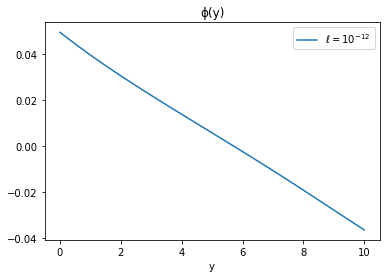

In [22]:
# plt.plot(y_grid, ϕ_1d, label="no constraint")
plt.plot(y_mat[:,0], v_dict[1e-12][:,-1], label="$ℓ = 10^{-12}$")
# plt.plot(y_mat[:,0], v_dict[1e-5][:,-1], label="$ℓ = 10^{-5}$")
plt.legend()
plt.xlabel('y')
plt.title('ϕ(y)')
# plt.savefig("phi.png", dpi=148, facecolor='w', edgecolor='w',
#         orientation='portrait', format=None,
#         transparent=False, bbox_inches="tight", pad_inches=0.1,)

Text(0.5, 1.0, '$\\tilde e(y)$')

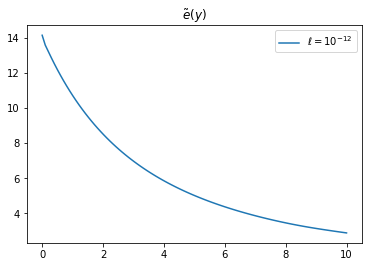

In [24]:
# plt.plot(y_grid, ems_1d, label="no contrainst")
plt.plot(y_mat[:,0], ems_dict[1e-12][:,-1], label="$ℓ = 10^{-12}$")
# plt.plot(y_mat[:,0], ems_dict[1e-5][:,-1], label="$ℓ = 10^{-5}$")
plt.legend()
plt.title('$\\tilde e(y)$')
# plt.savefig("e_tilde.png", dpi=148, facecolor='w', edgecolor='w',
#         orientation='portrait', format=None,
#         transparent=False, bbox_inches="tight", pad_inches=0.1,)

In [25]:
def compute_h_2d(ϕ, y_mat, b_mat, ems, args=(η, σy, γ1, γ2, ξₘ)):
    η, σy, γ1, γ2, ξₘ = args
    dΛ = γ1 + γ2*y_mat
    dy = y_mat[1,0] - y_mat[0,0]
    dϕdy = derivatives_2d(ϕ, 0, 1, dy)
    h_star = dϕdy + b_mat*(η-1)*dΛ
    h_star *= ems*σy
    h_star *= - 1/(b_mat*ξₘ)
    return h_star

In [26]:
args=(η, σy, γ1, γ2, ξₘ)
h_2d_dict = dict()
for ℓ in [1e-12, 1e-5]:
    h_2d_dict[ℓ] = compute_h_2d(v_dict[ℓ], y_mat, b_mat, ems_dict[ℓ], args)

Text(0.5, 1.0, 'h')

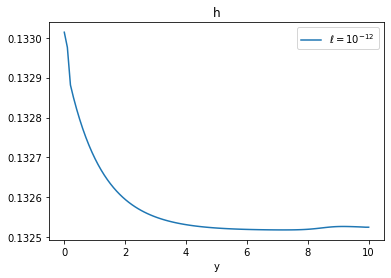

In [28]:
# plt.plot(y_grid[:], h_1d[:], label="no constraint")
plt.plot(y_mat[:,0], h_2d_dict[1e-12][:,-1], label="$ℓ = 10^{-12}$")
# plt.plot(y_mat[:,0], h_2d_dict[1e-5][:,-1], label="$ℓ = 10^{-5}$")
plt.legend()
plt.xlabel('y')
plt.title('h')
# plt.savefig("h_star.png", dpi=148, facecolor='w', edgecolor='w',
#         orientation='portrait', format=None,
#         transparent=False, bbox_inches="tight", pad_inches=0.1,)

In [90]:
# 2 state HJB with constraints
ℓ_step = 1e-20
dΛ = γ1 + γ2*y_mat
V_dict = dict()
E_dict = dict()
for ℓ in [1e-12, ℓ_step + 1e-12]:
    episode = 0
    lhs_error = 1
    ems = - δ*η/(b_mat*(η-1)*dΛ*θ)
    ems_old = ems
    while lhs_error > tol:
        if episode ==0:
            v0 =  - δ*η*y_mat**2
        else:
            vold = v0.copy()
        v0_dy = derivatives_2d(v0,0,1,hy)
        v0_dyy = derivatives_2d(v0,0,2,hy)
        v0_db = derivatives_2d(v0,1,1,hb)
        # updating controls

        print(np.min(ems))
        temp = v0_dy + b_mat*(η-1)*dΛ
        a = v0_dyy*σy**2 - temp**2/(b_mat*ξₘ)*σy**2
        b = temp*θ  - ℓ
        c = δ*η*b_mat
        Δ = b**2 - 4*c*a
        Δ[Δ<0] = 0
        ems_new =  -b/(2*a) - np.sqrt(Δ)/(2*a)
        ems_new[ems_new <= 0] = 1e-15
        ems = ems_new
        # HJB coefficient
        A =  np.zeros(y_mat.shape)
        B_y =  ems*θ
        B_b = - δ*b_mat
        C_yy = ems**2*σy**2/2
        C_bb = np.zeros(y_mat.shape)
        D = b_mat*δ*η*np.log(ems) + b_mat*(η-1)*dΛ*ems*θ - ℓ*ems - temp**2*ems**2*σy**2/(2*b_mat*ξₘ)
        # PDE solver
        solve_start = time.time()
        out = PDESolver_2d(stateSpace, A, B_y, B_b, C_yy, C_bb, D, v0, ϵ, solverType = 'False Transient')
        out_comp = out[2].reshape(v0.shape,order = "F")
        rhs = A*v0 + B_y*v0_dy + B_b*v0_db + C_yy*v0_dyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((out_comp - v0)))
        #     if episode % 1 == 0:
        print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode,
              rhs_error, lhs_error, out[0], out[1]))
        episode += 1
        v0 = out_comp
        ems_old = ems
        print("End of PDE solver, takes time: {}".format(time.time() - solve_start))
    
    V_dict[ℓ] = v0
    E_dict[ℓ] = ems

4.023165647291287
Episode 0: PDE Error: 0.001570491698; False Transient Error: 0.000473047417; Iterations: 330; CG Error: 0.000000000082
End of PDE solver, takes time: 0.037909507751464844
2.331103050065163e-09
Episode 1: PDE Error: 0.001425143088; False Transient Error: 0.000811705856; Iterations: 834; CG Error: 0.000000000070
End of PDE solver, takes time: 0.09104752540588379
2.3311030500726075e-09
Episode 2: PDE Error: 0.001952751715; False Transient Error: 0.000480379355; Iterations: 249; CG Error: 0.000000000055
End of PDE solver, takes time: 0.028876543045043945
2.3311030500674525e-09
Episode 3: PDE Error: 0.001681436271; False Transient Error: 0.000423184475; Iterations: 113; CG Error: 0.000000000075
End of PDE solver, takes time: 0.01427149772644043
2.3311030500610402e-09
Episode 4: PDE Error: 0.001459975175; False Transient Error: 0.000374731641; Iterations: 48; CG Error: 0.000000000090
End of PDE solver, takes time: 0.007264137268066406
2.3311030500581964e-09
Episode 5: PDE E

2.331103050059882e-09
Episode 56: PDE Error: 0.000647505155; False Transient Error: 0.000193019669; Iterations: 15; CG Error: 0.000000000073
End of PDE solver, takes time: 0.004457235336303711
2.331103050060888e-09
Episode 57: PDE Error: 0.000643065480; False Transient Error: 0.000191704129; Iterations: 15; CG Error: 0.000000000069
End of PDE solver, takes time: 0.0037949085235595703
2.331103050061846e-09
Episode 58: PDE Error: 0.000638686789; False Transient Error: 0.000190406402; Iterations: 15; CG Error: 0.000000000066
End of PDE solver, takes time: 0.004495859146118164
2.3311030500628236e-09
Episode 59: PDE Error: 0.000634367255; False Transient Error: 0.000189125962; Iterations: 15; CG Error: 0.000000000063
End of PDE solver, takes time: 0.0037903785705566406
2.331103050063731e-09
Episode 60: PDE Error: 0.000630105139; False Transient Error: 0.000187862309; Iterations: 15; CG Error: 0.000000000060
End of PDE solver, takes time: 0.0043528079986572266
2.331103050064559e-09
Episode 6

Episode 110: PDE Error: 0.000466837966; False Transient Error: 0.000139328169; Iterations: 14; CG Error: 0.000000000043
End of PDE solver, takes time: 0.004175662994384766
2.3311030500770602e-09
Episode 111: PDE Error: 0.000464276066; False Transient Error: 0.000138565126; Iterations: 14; CG Error: 0.000000000042
End of PDE solver, takes time: 0.0036673545837402344
2.33110305007711e-09
Episode 112: PDE Error: 0.000461734297; False Transient Error: 0.000137808046; Iterations: 14; CG Error: 0.000000000041
End of PDE solver, takes time: 0.004251241683959961
2.33110305007711e-09
Episode 113: PDE Error: 0.000459212375; False Transient Error: 0.000137056844; Iterations: 14; CG Error: 0.000000000040
End of PDE solver, takes time: 0.003651142120361328
2.3311030500771355e-09
Episode 114: PDE Error: 0.000456710017; False Transient Error: 0.000136311439; Iterations: 14; CG Error: 0.000000000039
End of PDE solver, takes time: 0.004306316375732422
2.33110305007711e-09
Episode 115: PDE Error: 0.0004

Episode 165: PDE Error: 0.000350047981; False Transient Error: 0.000104514258; Iterations: 13; CG Error: 0.000000000061
End of PDE solver, takes time: 0.003766298294067383
2.331103050032524e-09
Episode 166: PDE Error: 0.000348292386; False Transient Error: 0.000103990557; Iterations: 13; CG Error: 0.000000000061
End of PDE solver, takes time: 0.004149436950683594
2.3311030500313387e-09
Episode 167: PDE Error: 0.000346547462; False Transient Error: 0.000103470031; Iterations: 13; CG Error: 0.000000000060
End of PDE solver, takes time: 0.0035941600799560547
2.3311030500302335e-09
Episode 168: PDE Error: 0.000344813109; False Transient Error: 0.000102952649; Iterations: 13; CG Error: 0.000000000059
End of PDE solver, takes time: 0.004134654998779297
2.331103050029102e-09
Episode 169: PDE Error: 0.000343089228; False Transient Error: 0.000102438382; Iterations: 13; CG Error: 0.000000000058
End of PDE solver, takes time: 0.003551006317138672
2.33110305002802e-09
Episode 170: PDE Error: 0.00

2.3311030499830305e-09
Episode 221: PDE Error: 0.000265852912; False Transient Error: 0.000079389392; Iterations: 13; CG Error: 0.000000000032
End of PDE solver, takes time: 0.003553628921508789
2.3311030499823754e-09
Episode 222: PDE Error: 0.000264573644; False Transient Error: 0.000079007515; Iterations: 13; CG Error: 0.000000000032
End of PDE solver, takes time: 0.00412440299987793
2.3311030499816962e-09
Episode 223: PDE Error: 0.000263301120; False Transient Error: 0.000078627647; Iterations: 13; CG Error: 0.000000000032
End of PDE solver, takes time: 0.0035622119903564453
2.331103049981017e-09
Episode 224: PDE Error: 0.000262035292; False Transient Error: 0.000078249776; Iterations: 13; CG Error: 0.000000000031
End of PDE solver, takes time: 0.004184722900390625
2.3311030499803645e-09
Episode 225: PDE Error: 0.000260776113; False Transient Error: 0.000077873886; Iterations: 13; CG Error: 0.000000000031
End of PDE solver, takes time: 0.0035483837127685547
2.3311030499796854e-09
Ep

Episode 276: PDE Error: 0.000204394493; False Transient Error: 0.000061039848; Iterations: 12; CG Error: 0.000000000073
End of PDE solver, takes time: 0.004271507263183594
2.3311030499441017e-09
Episode 277: PDE Error: 0.000203425815; False Transient Error: 0.000060750579; Iterations: 12; CG Error: 0.000000000072
End of PDE solver, takes time: 0.0034661293029785156
2.3311030499434722e-09
Episode 278: PDE Error: 0.000202461833; False Transient Error: 0.000060462712; Iterations: 12; CG Error: 0.000000000071
End of PDE solver, takes time: 0.003938436508178711
2.3311030499427426e-09
Episode 279: PDE Error: 0.000201502517; False Transient Error: 0.000060176236; Iterations: 12; CG Error: 0.000000000071
End of PDE solver, takes time: 0.004057884216308594
2.331103049942115e-09
Episode 280: PDE Error: 0.000200547839; False Transient Error: 0.000059891145; Iterations: 12; CG Error: 0.000000000070
End of PDE solver, takes time: 0.003949880599975586
2.3311030499413844e-09
Episode 281: PDE Error: 0

Episode 332: PDE Error: 0.000156672422; False Transient Error: 0.000046787408; Iterations: 12; CG Error: 0.000000000048
End of PDE solver, takes time: 0.0039958953857421875
2.3311030499113338e-09
Episode 333: PDE Error: 0.000155928819; False Transient Error: 0.000046565304; Iterations: 12; CG Error: 0.000000000047
End of PDE solver, takes time: 0.004021167755126953
2.3311030499107547e-09
Episode 334: PDE Error: 0.000155188631; False Transient Error: 0.000046344219; Iterations: 12; CG Error: 0.000000000047
End of PDE solver, takes time: 0.00408625602722168
2.3311030499102014e-09
Episode 335: PDE Error: 0.000154451840; False Transient Error: 0.000046124147; Iterations: 12; CG Error: 0.000000000047
End of PDE solver, takes time: 0.003451108932495117
2.331103049909672e-09
Episode 336: PDE Error: 0.000153718426; False Transient Error: 0.000045905084; Iterations: 12; CG Error: 0.000000000046
End of PDE solver, takes time: 0.003854513168334961
2.3311030499092203e-09
Episode 337: PDE Error: 0.

Episode 388: PDE Error: 0.000119826538; False Transient Error: 0.000035781298; Iterations: 12; CG Error: 0.000000000033
End of PDE solver, takes time: 0.004224300384521484
2.3311030498852536e-09
Episode 389: PDE Error: 0.000119249239; False Transient Error: 0.000035608844; Iterations: 12; CG Error: 0.000000000033
End of PDE solver, takes time: 0.003456592559814453
2.3311030498849277e-09
Episode 390: PDE Error: 0.000118674502; False Transient Error: 0.000035437155; Iterations: 12; CG Error: 0.000000000032
End of PDE solver, takes time: 0.00400233268737793
2.331103049884524e-09
Episode 391: PDE Error: 0.000118102316; False Transient Error: 0.000035266228; Iterations: 12; CG Error: 0.000000000032
End of PDE solver, takes time: 0.003973245620727539
2.331103049884098e-09
Episode 392: PDE Error: 0.000117532668; False Transient Error: 0.000035096059; Iterations: 12; CG Error: 0.000000000032
End of PDE solver, takes time: 0.004020214080810547
2.3311030498836935e-09
Episode 393: PDE Error: 0.00

Episode 444: PDE Error: 0.000091123137; False Transient Error: 0.000027206552; Iterations: 11; CG Error: 0.000000000089
End of PDE solver, takes time: 0.0038831233978271484
2.3311030499074593e-09
Episode 445: PDE Error: 0.000090671982; False Transient Error: 0.000027071772; Iterations: 11; CG Error: 0.000000000088
End of PDE solver, takes time: 0.0033500194549560547
2.3311030499092203e-09
Episode 446: PDE Error: 0.000090222792; False Transient Error: 0.000026937579; Iterations: 11; CG Error: 0.000000000088
End of PDE solver, takes time: 0.003843545913696289
2.3311030499108796e-09
Episode 447: PDE Error: 0.000089775558; False Transient Error: 0.000026803969; Iterations: 11; CG Error: 0.000000000087
End of PDE solver, takes time: 0.0033540725708007812
2.331103049912539e-09
Episode 448: PDE Error: 0.000089330271; False Transient Error: 0.000026670941; Iterations: 11; CG Error: 0.000000000087
End of PDE solver, takes time: 0.0039141178131103516
2.3311030499142504e-09
Episode 449: PDE Error

2.331103049991228e-09
Episode 501: PDE Error: 0.000068297653; False Transient Error: 0.000020387448; Iterations: 11; CG Error: 0.000000000065
End of PDE solver, takes time: 0.0038695335388183594
2.331103049992486e-09
Episode 502: PDE Error: 0.000067945441; False Transient Error: 0.000020282224; Iterations: 11; CG Error: 0.000000000065
End of PDE solver, takes time: 0.003379344940185547
2.3311030499938186e-09
Episode 503: PDE Error: 0.000067594750; False Transient Error: 0.000020177454; Iterations: 11; CG Error: 0.000000000065
End of PDE solver, takes time: 0.0037848949432373047
2.3311030499951024e-09
Episode 504: PDE Error: 0.000067245574; False Transient Error: 0.000020073137; Iterations: 11; CG Error: 0.000000000064
End of PDE solver, takes time: 0.003786802291870117
2.331103049996334e-09
Episode 505: PDE Error: 0.000066897907; False Transient Error: 0.000019969271; Iterations: 11; CG Error: 0.000000000064
End of PDE solver, takes time: 0.0038115978240966797
2.331103049997592e-09
Epi

2.331103050054852e-09
Episode 558: PDE Error: 0.000050468611; False Transient Error: 0.000015061014; Iterations: 11; CG Error: 0.000000000049
End of PDE solver, takes time: 0.003869295120239258
2.3311030500557835e-09
Episode 559: PDE Error: 0.000050193459; False Transient Error: 0.000014978813; Iterations: 11; CG Error: 0.000000000049
End of PDE solver, takes time: 0.0033576488494873047
2.3311030500566644e-09
Episode 560: PDE Error: 0.000049919498; False Transient Error: 0.000014896968; Iterations: 11; CG Error: 0.000000000049
End of PDE solver, takes time: 0.0039043426513671875
2.3311030500576447e-09
Episode 561: PDE Error: 0.000049646723; False Transient Error: 0.000014815478; Iterations: 11; CG Error: 0.000000000049
End of PDE solver, takes time: 0.0033321380615234375
2.3311030500585496e-09
Episode 562: PDE Error: 0.000049375131; False Transient Error: 0.000014734341; Iterations: 11; CG Error: 0.000000000048
End of PDE solver, takes time: 0.0038950443267822266
2.3311030500595066e-09

2.331103050101477e-09
Episode 615: PDE Error: 0.000036549288; False Transient Error: 0.000010902762; Iterations: 11; CG Error: 0.000000000038
End of PDE solver, takes time: 0.0033431053161621094
2.3311030501021073e-09
Episode 616: PDE Error: 0.000036334719; False Transient Error: 0.000010838664; Iterations: 11; CG Error: 0.000000000038
End of PDE solver, takes time: 0.003951072692871094
2.3311030501028104e-09
Episode 617: PDE Error: 0.000036121091; False Transient Error: 0.000010774847; Iterations: 11; CG Error: 0.000000000038
End of PDE solver, takes time: 0.003408193588256836
2.331103050103438e-09
Episode 618: PDE Error: 0.000035908399; False Transient Error: 0.000010711310; Iterations: 11; CG Error: 0.000000000038
End of PDE solver, takes time: 0.003780364990234375
2.3311030501041686e-09
Episode 619: PDE Error: 0.000035696641; False Transient Error: 0.000010648052; Iterations: 11; CG Error: 0.000000000038
End of PDE solver, takes time: 0.00333404541015625
2.3311030501047716e-09
Epis

2.331103050135528e-09
Episode 672: PDE Error: 0.000025713986; False Transient Error: 0.000007666076; Iterations: 11; CG Error: 0.000000000030
End of PDE solver, takes time: 0.0033388137817382812
2.3311030501360316e-09
Episode 673: PDE Error: 0.000025547364; False Transient Error: 0.000007616305; Iterations: 11; CG Error: 0.000000000030
End of PDE solver, takes time: 0.0037658214569091797
2.331103050136508e-09
Episode 674: PDE Error: 0.000025381488; False Transient Error: 0.000007566758; Iterations: 11; CG Error: 0.000000000030
End of PDE solver, takes time: 0.003802776336669922
2.331103050137012e-09
Episode 675: PDE Error: 0.000025216355; False Transient Error: 0.000007517433; Iterations: 11; CG Error: 0.000000000030
End of PDE solver, takes time: 0.0038797855377197266
2.331103050137465e-09
Episode 676: PDE Error: 0.000025051963; False Transient Error: 0.000007468330; Iterations: 11; CG Error: 0.000000000030
End of PDE solver, takes time: 0.003360271453857422
2.3311030501379416e-09
Epi

2.3311030502227185e-09
Episode 729: PDE Error: 0.000020249349; False Transient Error: 0.000006073655; Iterations: 10; CG Error: 0.000000000082
End of PDE solver, takes time: 0.003612041473388672
2.331103050224301e-09
Episode 730: PDE Error: 0.000020245908; False Transient Error: 0.000006072593; Iterations: 10; CG Error: 0.000000000082
End of PDE solver, takes time: 0.003332853317260742
2.331103050225909e-09
Episode 731: PDE Error: 0.000020242365; False Transient Error: 0.000006071500; Iterations: 10; CG Error: 0.000000000081
End of PDE solver, takes time: 0.003742218017578125
2.331103050227546e-09
Episode 732: PDE Error: 0.000020238720; False Transient Error: 0.000006070377; Iterations: 10; CG Error: 0.000000000081
End of PDE solver, takes time: 0.0032432079315185547
2.3311030502291804e-09
Episode 733: PDE Error: 0.000020234973; False Transient Error: 0.000006069223; Iterations: 10; CG Error: 0.000000000081
End of PDE solver, takes time: 0.003676176071166992
2.3311030502307653e-09
Epis

2.3311030503052297e-09
Episode 786: PDE Error: 0.000019901041; False Transient Error: 0.000005967620; Iterations: 10; CG Error: 0.000000000068
End of PDE solver, takes time: 0.0032346248626708984
2.331103050306536e-09
Episode 787: PDE Error: 0.000019892370; False Transient Error: 0.000005964994; Iterations: 10; CG Error: 0.000000000068
End of PDE solver, takes time: 0.0037293434143066406
2.331103050307817e-09
Episode 788: PDE Error: 0.000019883617; False Transient Error: 0.000005962345; Iterations: 10; CG Error: 0.000000000068
End of PDE solver, takes time: 0.0032584667205810547
2.331103050309101e-09
Episode 789: PDE Error: 0.000019874784; False Transient Error: 0.000005959671; Iterations: 10; CG Error: 0.000000000068
End of PDE solver, takes time: 0.0036993026733398438
2.331103050310384e-09
Episode 790: PDE Error: 0.000019865869; False Transient Error: 0.000005956973; Iterations: 10; CG Error: 0.000000000068
End of PDE solver, takes time: 0.0037109851837158203
2.3311030503116156e-09
E

2.331103050371822e-09
Episode 843: PDE Error: 0.000019286765; False Transient Error: 0.000005782124; Iterations: 10; CG Error: 0.000000000061
End of PDE solver, takes time: 0.003245115280151367
2.3311030503728766e-09
Episode 844: PDE Error: 0.000019273984; False Transient Error: 0.000005778271; Iterations: 10; CG Error: 0.000000000061
End of PDE solver, takes time: 0.0036478042602539062
2.3311030503738824e-09
Episode 845: PDE Error: 0.000019261140; False Transient Error: 0.000005774399; Iterations: 10; CG Error: 0.000000000060
End of PDE solver, takes time: 0.0032584667205810547
2.331103050374862e-09
Episode 846: PDE Error: 0.000019248233; False Transient Error: 0.000005770509; Iterations: 10; CG Error: 0.000000000060
End of PDE solver, takes time: 0.00370025634765625
2.3311030503758693e-09
Episode 847: PDE Error: 0.000019235263; False Transient Error: 0.000005766599; Iterations: 10; CG Error: 0.000000000060
End of PDE solver, takes time: 0.0032227039337158203
2.331103050376851e-09
Epi

2.3311030504172887e-09
Episode 900: PDE Error: 0.000018465916; False Transient Error: 0.000005534943; Iterations: 10; CG Error: 0.000000000042
End of PDE solver, takes time: 0.0036933422088623047
2.3311030504178413e-09
Episode 901: PDE Error: 0.000018449989; False Transient Error: 0.000005530151; Iterations: 10; CG Error: 0.000000000042
End of PDE solver, takes time: 0.0032634735107421875
2.3311030504183425e-09
Episode 902: PDE Error: 0.000018434015; False Transient Error: 0.000005525344; Iterations: 10; CG Error: 0.000000000042
End of PDE solver, takes time: 0.0038101673126220703
2.331103050418848e-09
Episode 903: PDE Error: 0.000018417993; False Transient Error: 0.000005520524; Iterations: 10; CG Error: 0.000000000041
End of PDE solver, takes time: 0.003225088119506836
2.331103050419426e-09
Episode 904: PDE Error: 0.000018401925; False Transient Error: 0.000005515690; Iterations: 10; CG Error: 0.000000000041
End of PDE solver, takes time: 0.0036323070526123047
2.3311030504199043e-09


2.331103050448146e-09
Episode 957: PDE Error: 0.000017489573; False Transient Error: 0.000005241356; Iterations: 10; CG Error: 0.000000000049
End of PDE solver, takes time: 0.0032362937927246094
2.3311030504488e-09
Episode 958: PDE Error: 0.000017471330; False Transient Error: 0.000005235873; Iterations: 10; CG Error: 0.000000000049
End of PDE solver, takes time: 0.0038199424743652344
2.331103050449428e-09
Episode 959: PDE Error: 0.000017453052; False Transient Error: 0.000005230380; Iterations: 10; CG Error: 0.000000000049
End of PDE solver, takes time: 0.003246784210205078
2.331103050450031e-09
Episode 960: PDE Error: 0.000017434741; False Transient Error: 0.000005224877; Iterations: 10; CG Error: 0.000000000049
End of PDE solver, takes time: 0.003679990768432617
2.3311030504506597e-09
Episode 961: PDE Error: 0.000017416396; False Transient Error: 0.000005219363; Iterations: 10; CG Error: 0.000000000050
End of PDE solver, takes time: 0.0032241344451904297
2.3311030504512883e-09
Episo

2.331103050483454e-09
Episode 1014: PDE Error: 0.000016401659; False Transient Error: 0.000004914509; Iterations: 10; CG Error: 0.000000000053
End of PDE solver, takes time: 0.0032312870025634766
2.3311030504840563e-09
Episode 1015: PDE Error: 0.000016381812; False Transient Error: 0.000004908549; Iterations: 10; CG Error: 0.000000000053
End of PDE solver, takes time: 0.003755331039428711
2.331103050484685e-09
Episode 1016: PDE Error: 0.000016361942; False Transient Error: 0.000004902581; Iterations: 10; CG Error: 0.000000000053
End of PDE solver, takes time: 0.0033180713653564453
2.331103050485264e-09
Episode 1017: PDE Error: 0.000016342051; False Transient Error: 0.000004896608; Iterations: 10; CG Error: 0.000000000053
End of PDE solver, takes time: 0.003765583038330078
2.3311030504858165e-09
Episode 1018: PDE Error: 0.000016322137; False Transient Error: 0.000004890627; Iterations: 10; CG Error: 0.000000000053
End of PDE solver, takes time: 0.0032782554626464844
2.331103050486446e-0

2.3311030505165736e-09
Episode 1071: PDE Error: 0.000015240002; False Transient Error: 0.000004565723; Iterations: 10; CG Error: 0.000000000052
End of PDE solver, takes time: 0.003694295883178711
2.3311030505171005e-09
Episode 1072: PDE Error: 0.000015219167; False Transient Error: 0.000004559469; Iterations: 10; CG Error: 0.000000000052
End of PDE solver, takes time: 0.0037419795989990234
2.3311030505176555e-09
Episode 1073: PDE Error: 0.000015198320; False Transient Error: 0.000004553211; Iterations: 10; CG Error: 0.000000000052
End of PDE solver, takes time: 0.003245115280151367
2.331103050518156e-09
Episode 1074: PDE Error: 0.000015177460; False Transient Error: 0.000004546950; Iterations: 10; CG Error: 0.000000000052
End of PDE solver, takes time: 0.0035932064056396484
2.3311030505187598e-09
Episode 1075: PDE Error: 0.000015156589; False Transient Error: 0.000004540685; Iterations: 10; CG Error: 0.000000000052
End of PDE solver, takes time: 0.0036208629608154297
2.3311030505192644

2.331103050545869e-09
Episode 1128: PDE Error: 0.000014037375; False Transient Error: 0.000004204805; Iterations: 10; CG Error: 0.000000000050
End of PDE solver, takes time: 0.0032355785369873047
2.3311030505463984e-09
Episode 1129: PDE Error: 0.000014016088; False Transient Error: 0.000004198418; Iterations: 10; CG Error: 0.000000000050
End of PDE solver, takes time: 0.003574848175048828
2.3311030505468244e-09
Episode 1130: PDE Error: 0.000013994797; False Transient Error: 0.000004192029; Iterations: 10; CG Error: 0.000000000050
End of PDE solver, takes time: 0.0032782554626464844
2.331103050547304e-09
Episode 1131: PDE Error: 0.000013973503; False Transient Error: 0.000004185640; Iterations: 10; CG Error: 0.000000000050
End of PDE solver, takes time: 0.0036559104919433594
2.3311030505477318e-09
Episode 1132: PDE Error: 0.000013952205; False Transient Error: 0.000004179250; Iterations: 10; CG Error: 0.000000000050
End of PDE solver, takes time: 0.0032291412353515625
2.3311030505481843

2.3311030505706406e-09
Episode 1185: PDE Error: 0.000012822669; False Transient Error: 0.000003840298; Iterations: 10; CG Error: 0.000000000047
End of PDE solver, takes time: 0.0035784244537353516
2.3311030505710442e-09
Episode 1186: PDE Error: 0.000012801477; False Transient Error: 0.000003833917; Iterations: 10; CG Error: 0.000000000047
End of PDE solver, takes time: 0.0032989978790283203
2.331103050571447e-09
Episode 1187: PDE Error: 0.000012780287; False Transient Error: 0.000003827537; Iterations: 10; CG Error: 0.000000000047
End of PDE solver, takes time: 0.0037729740142822266
2.3311030505717994e-09
Episode 1188: PDE Error: 0.000012759102; False Transient Error: 0.000003821159; Iterations: 10; CG Error: 0.000000000047
End of PDE solver, takes time: 0.0033266544342041016
2.331103050572176e-09
Episode 1189: PDE Error: 0.000012737920; False Transient Error: 0.000003814782; Iterations: 10; CG Error: 0.000000000047
End of PDE solver, takes time: 0.0032362937927246094
2.331103050572578

2.3311030505923185e-09
Episode 1242: PDE Error: 0.000011625220; False Transient Error: 0.000003479612; Iterations: 10; CG Error: 0.000000000043
End of PDE solver, takes time: 0.0037050247192382812
2.331103050592671e-09
Episode 1243: PDE Error: 0.000011604484; False Transient Error: 0.000003473358; Iterations: 10; CG Error: 0.000000000043
End of PDE solver, takes time: 0.003225564956665039
2.3311030505929984e-09
Episode 1244: PDE Error: 0.000011583758; False Transient Error: 0.000003467107; Iterations: 10; CG Error: 0.000000000043
End of PDE solver, takes time: 0.0032567977905273438
2.3311030505933243e-09
Episode 1245: PDE Error: 0.000011563042; False Transient Error: 0.000003460860; Iterations: 10; CG Error: 0.000000000043
End of PDE solver, takes time: 0.0037674903869628906
2.3311030505936767e-09
Episode 1246: PDE Error: 0.000011542336; False Transient Error: 0.000003454615; Iterations: 10; CG Error: 0.000000000043
End of PDE solver, takes time: 0.003225564956665039
2.3311030505940034

2.331103050610299e-09
Episode 1299: PDE Error: 0.000010464621; False Transient Error: 0.000003129065; Iterations: 10; CG Error: 0.000000000040
End of PDE solver, takes time: 0.0032329559326171875
2.331103050610552e-09
Episode 1300: PDE Error: 0.000010444700; False Transient Error: 0.000003123039; Iterations: 10; CG Error: 0.000000000040
End of PDE solver, takes time: 0.003726482391357422
2.33110305061083e-09
Episode 1301: PDE Error: 0.000010424795; False Transient Error: 0.000003117017; Iterations: 10; CG Error: 0.000000000040
End of PDE solver, takes time: 0.003265380859375
2.3311030506111542e-09
Episode 1302: PDE Error: 0.000010404904; False Transient Error: 0.000003111000; Iterations: 10; CG Error: 0.000000000039
End of PDE solver, takes time: 0.0037543773651123047
2.3311030506114578e-09
Episode 1303: PDE Error: 0.000010385028; False Transient Error: 0.000003104988; Iterations: 10; CG Error: 0.000000000039
End of PDE solver, takes time: 0.0032236576080322266
2.3311030506117332e-09
E

2.3311030506253643e-09
Episode 1356: PDE Error: 0.000009356468; False Transient Error: 0.000002793852; Iterations: 10; CG Error: 0.000000000036
End of PDE solver, takes time: 0.0034863948822021484
2.3311030506256166e-09
Episode 1357: PDE Error: 0.000009337561; False Transient Error: 0.000002788134; Iterations: 10; CG Error: 0.000000000036
End of PDE solver, takes time: 0.0035173892974853516
2.331103050625892e-09
Episode 1358: PDE Error: 0.000009318674; False Transient Error: 0.000002782422; Iterations: 10; CG Error: 0.000000000036
End of PDE solver, takes time: 0.003673076629638672
2.331103050626142e-09
Episode 1359: PDE Error: 0.000009299805; False Transient Error: 0.000002776716; Iterations: 10; CG Error: 0.000000000036
End of PDE solver, takes time: 0.0032227039337158203
2.331103050626319e-09
Episode 1360: PDE Error: 0.000009280956; False Transient Error: 0.000002771016; Iterations: 10; CG Error: 0.000000000036
End of PDE solver, takes time: 0.0037581920623779297
2.3311030506265695e

2.331103050637939e-09
Episode 1413: PDE Error: 0.000008312242; False Transient Error: 0.000002478010; Iterations: 10; CG Error: 0.000000000032
End of PDE solver, takes time: 0.003781557083129883
2.331103050638089e-09
Episode 1414: PDE Error: 0.000008294547; False Transient Error: 0.000002472661; Iterations: 10; CG Error: 0.000000000032
End of PDE solver, takes time: 0.003276824951171875
2.3311030506383155e-09
Episode 1415: PDE Error: 0.000008276873; False Transient Error: 0.000002467319; Iterations: 10; CG Error: 0.000000000032
End of PDE solver, takes time: 0.003700733184814453
2.3311030506385165e-09
Episode 1416: PDE Error: 0.000008259222; False Transient Error: 0.000002461983; Iterations: 10; CG Error: 0.000000000032
End of PDE solver, takes time: 0.003220081329345703
2.3311030506387184e-09
Episode 1417: PDE Error: 0.000008241593; False Transient Error: 0.000002456655; Iterations: 10; CG Error: 0.000000000032
End of PDE solver, takes time: 0.003665924072265625
2.3311030506389194e-09

2.3311030506484245e-09
Episode 1470: PDE Error: 0.000007554773; False Transient Error: 0.000002184417; Iterations: 10; CG Error: 0.000000000028
End of PDE solver, takes time: 0.0033066272735595703
2.331103050648576e-09
Episode 1471: PDE Error: 0.000007548325; False Transient Error: 0.000002179477; Iterations: 10; CG Error: 0.000000000028
End of PDE solver, takes time: 0.003766298294067383
2.3311030506487024e-09
Episode 1472: PDE Error: 0.000007541869; False Transient Error: 0.000002174544; Iterations: 10; CG Error: 0.000000000028
End of PDE solver, takes time: 0.003329038619995117
2.3311030506488273e-09
Episode 1473: PDE Error: 0.000007535406; False Transient Error: 0.000002169619; Iterations: 10; CG Error: 0.000000000028
End of PDE solver, takes time: 0.0034635066986083984
2.331103050648977e-09
Episode 1474: PDE Error: 0.000007528935; False Transient Error: 0.000002164701; Iterations: 10; CG Error: 0.000000000028
End of PDE solver, takes time: 0.0032231807708740234
2.3311030506491557e

2.3311030506540584e-09
Episode 1527: PDE Error: 0.000007178465; False Transient Error: 0.000001914839; Iterations: 9; CG Error: 0.000000000098
End of PDE solver, takes time: 0.00359344482421875
2.3311030506535555e-09
Episode 1528: PDE Error: 0.000007171765; False Transient Error: 0.000001910330; Iterations: 9; CG Error: 0.000000000098
End of PDE solver, takes time: 0.003314971923828125
2.3311030506530013e-09
Episode 1529: PDE Error: 0.000007165064; False Transient Error: 0.000001905828; Iterations: 9; CG Error: 0.000000000098
End of PDE solver, takes time: 0.0035262107849121094
2.331103050652447e-09
Episode 1530: PDE Error: 0.000007158362; False Transient Error: 0.000001901334; Iterations: 9; CG Error: 0.000000000098
End of PDE solver, takes time: 0.0031218528747558594
2.331103050651945e-09
Episode 1531: PDE Error: 0.000007151658; False Transient Error: 0.000001896848; Iterations: 9; CG Error: 0.000000000098
End of PDE solver, takes time: 0.003566265106201172
2.3311030506514437e-09
Epi

Episode 1585: PDE Error: 0.000006790417; False Transient Error: 0.000001665971; Iterations: 9; CG Error: 0.000000000086
End of PDE solver, takes time: 0.0033452510833740234
2.3311030506254644e-09
Episode 1586: PDE Error: 0.000006783781; False Transient Error: 0.000001661905; Iterations: 9; CG Error: 0.000000000086
End of PDE solver, takes time: 0.003592252731323242
2.3311030506249863e-09
Episode 1587: PDE Error: 0.000006777147; False Transient Error: 0.000001657848; Iterations: 9; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0031664371490478516
2.331103050624534e-09
Episode 1588: PDE Error: 0.000006770517; False Transient Error: 0.000001653798; Iterations: 9; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0034492015838623047
2.3311030506240814e-09
Episode 1589: PDE Error: 0.000006763890; False Transient Error: 0.000001649755; Iterations: 9; CG Error: 0.000000000085
End of PDE solver, takes time: 0.003120899200439453
2.3311030506236794e-09
Episode 1590: PDE Error

Episode 1643: PDE Error: 0.000006412647; False Transient Error: 0.000001442671; Iterations: 9; CG Error: 0.000000000074
End of PDE solver, takes time: 0.0035436153411865234
2.3311030506019766e-09
Episode 1644: PDE Error: 0.000006406291; False Transient Error: 0.000001439041; Iterations: 9; CG Error: 0.000000000074
End of PDE solver, takes time: 0.0031557083129882812
2.33110305060155e-09
Episode 1645: PDE Error: 0.000006399942; False Transient Error: 0.000001435419; Iterations: 9; CG Error: 0.000000000074
End of PDE solver, takes time: 0.0031719207763671875
2.3311030506011213e-09
Episode 1646: PDE Error: 0.000006393599; False Transient Error: 0.000001431804; Iterations: 9; CG Error: 0.000000000074
End of PDE solver, takes time: 0.003547191619873047
2.3311030506007177e-09
Episode 1647: PDE Error: 0.000006387262; False Transient Error: 0.000001428196; Iterations: 9; CG Error: 0.000000000074
End of PDE solver, takes time: 0.0031490325927734375
2.331103050600342e-09
Episode 1648: PDE Error:

2.3311030505821094e-09
Episode 1702: PDE Error: 0.000006049551; False Transient Error: 0.000001240910; Iterations: 9; CG Error: 0.000000000064
End of PDE solver, takes time: 0.0035207271575927734
2.331103050581857e-09
Episode 1703: PDE Error: 0.000006043623; False Transient Error: 0.000001237703; Iterations: 9; CG Error: 0.000000000064
End of PDE solver, takes time: 0.003138303756713867
2.3311030505815056e-09
Episode 1704: PDE Error: 0.000006037704; False Transient Error: 0.000001234504; Iterations: 9; CG Error: 0.000000000064
End of PDE solver, takes time: 0.0035524368286132812
2.331103050581203e-09
Episode 1705: PDE Error: 0.000006031793; False Transient Error: 0.000001231311; Iterations: 9; CG Error: 0.000000000063
End of PDE solver, takes time: 0.0031824111938476562
2.3311030505809505e-09
Episode 1706: PDE Error: 0.000006025890; False Transient Error: 0.000001228125; Iterations: 9; CG Error: 0.000000000063
End of PDE solver, takes time: 0.0035719871520996094
2.331103050580675e-09
E

Episode 1760: PDE Error: 0.000005719718; False Transient Error: 0.000001066167; Iterations: 9; CG Error: 0.000000000055
End of PDE solver, takes time: 0.0034096240997314453
2.3311030505652597e-09
Episode 1761: PDE Error: 0.000005714289; False Transient Error: 0.000001063350; Iterations: 9; CG Error: 0.000000000055
End of PDE solver, takes time: 0.0034885406494140625
2.3311030505650075e-09
Episode 1762: PDE Error: 0.000005708869; False Transient Error: 0.000001060539; Iterations: 9; CG Error: 0.000000000055
End of PDE solver, takes time: 0.003166675567626953
2.331103050564732e-09
Episode 1763: PDE Error: 0.000005703459; False Transient Error: 0.000001057734; Iterations: 9; CG Error: 0.000000000055
End of PDE solver, takes time: 0.003616809844970703
2.331103050564454e-09
Episode 1764: PDE Error: 0.000005698057; False Transient Error: 0.000001054936; Iterations: 9; CG Error: 0.000000000054
End of PDE solver, takes time: 0.0031104087829589844
2.3311030505642034e-09
Episode 1765: PDE Error:

2.331103050551253e-09
Episode 1819: PDE Error: 0.000005415003; False Transient Error: 0.000000910666; Iterations: 9; CG Error: 0.000000000047
End of PDE solver, takes time: 0.0032346248626708984
2.3311030505510265e-09
Episode 1820: PDE Error: 0.000005410114; False Transient Error: 0.000000908212; Iterations: 9; CG Error: 0.000000000047
End of PDE solver, takes time: 0.00348663330078125
2.331103050550799e-09
Episode 1821: PDE Error: 0.000005405234; False Transient Error: 0.000000905765; Iterations: 9; CG Error: 0.000000000047
End of PDE solver, takes time: 0.0031354427337646484
2.3311030505505244e-09
Episode 1822: PDE Error: 0.000005400364; False Transient Error: 0.000000903323; Iterations: 9; CG Error: 0.000000000047
End of PDE solver, takes time: 0.0036771297454833984
2.3311030505502712e-09
Episode 1823: PDE Error: 0.000005395503; False Transient Error: 0.000000900887; Iterations: 9; CG Error: 0.000000000047
End of PDE solver, takes time: 0.003124237060546875
2.3311030505500694e-09
Ep

Episode 1876: PDE Error: 0.000005151020; False Transient Error: 0.000000779898; Iterations: 9; CG Error: 0.000000000040
End of PDE solver, takes time: 0.003397703170776367
2.331103050539408e-09
Episode 1877: PDE Error: 0.000005146654; False Transient Error: 0.000000777764; Iterations: 9; CG Error: 0.000000000040
End of PDE solver, takes time: 0.0037317276000976562
2.3311030505392317e-09
Episode 1878: PDE Error: 0.000005142296; False Transient Error: 0.000000775634; Iterations: 9; CG Error: 0.000000000040
End of PDE solver, takes time: 0.0032460689544677734
2.3311030505390547e-09
Episode 1879: PDE Error: 0.000005137948; False Transient Error: 0.000000773510; Iterations: 9; CG Error: 0.000000000040
End of PDE solver, takes time: 0.003345012664794922
2.331103050538905e-09
Episode 1880: PDE Error: 0.000005133609; False Transient Error: 0.000000771391; Iterations: 9; CG Error: 0.000000000040
End of PDE solver, takes time: 0.0035445690155029297
2.3311030505387023e-09
Episode 1881: PDE Error:

2.3311030505297993e-09
Episode 1935: PDE Error: 0.000004908635; False Transient Error: 0.000000662682; Iterations: 9; CG Error: 0.000000000034
End of PDE solver, takes time: 0.0035119056701660156
2.3311030505296496e-09
Episode 1936: PDE Error: 0.000004904789; False Transient Error: 0.000000660843; Iterations: 9; CG Error: 0.000000000034
End of PDE solver, takes time: 0.00347137451171875
2.3311030505294743e-09
Episode 1937: PDE Error: 0.000004900951; False Transient Error: 0.000000659008; Iterations: 9; CG Error: 0.000000000034
End of PDE solver, takes time: 0.003487825393676758
2.331103050529299e-09
Episode 1938: PDE Error: 0.000004897122; False Transient Error: 0.000000657178; Iterations: 9; CG Error: 0.000000000034
End of PDE solver, takes time: 0.0031175613403320312
2.3311030505291484e-09
Episode 1939: PDE Error: 0.000004893302; False Transient Error: 0.000000655353; Iterations: 9; CG Error: 0.000000000034
End of PDE solver, takes time: 0.0034830570220947266
2.331103050529022e-09
Ep

Episode 1993: PDE Error: 0.000004699368; False Transient Error: 0.000000563476; Iterations: 9; CG Error: 0.000000000029
End of PDE solver, takes time: 0.0032291412353515625
2.3311030505212256e-09
Episode 1994: PDE Error: 0.000004696000; False Transient Error: 0.000000561894; Iterations: 9; CG Error: 0.000000000029
End of PDE solver, takes time: 0.0035746097564697266
2.3311030505211247e-09
Episode 1995: PDE Error: 0.000004692640; False Transient Error: 0.000000560316; Iterations: 9; CG Error: 0.000000000029
End of PDE solver, takes time: 0.0031309127807617188
2.3311030505209493e-09
Episode 1996: PDE Error: 0.000004689288; False Transient Error: 0.000000558742; Iterations: 9; CG Error: 0.000000000029
End of PDE solver, takes time: 0.003509998321533203
2.3311030505208484e-09
Episode 1997: PDE Error: 0.000004685944; False Transient Error: 0.000000557172; Iterations: 9; CG Error: 0.000000000029
End of PDE solver, takes time: 0.0035037994384765625
2.3311030505206482e-09
Episode 1998: PDE Err

2.331103050513957e-09
Episode 2052: PDE Error: 0.000004513771; False Transient Error: 0.000000476924; Iterations: 8; CG Error: 0.000000000100
End of PDE solver, takes time: 0.003427743911743164
2.3311030505137057e-09
Episode 2053: PDE Error: 0.000004510846; False Transient Error: 0.000000475573; Iterations: 8; CG Error: 0.000000000099
End of PDE solver, takes time: 0.003026247024536133
2.3311030505134303e-09
Episode 2054: PDE Error: 0.000004507928; False Transient Error: 0.000000474224; Iterations: 8; CG Error: 0.000000000099
End of PDE solver, takes time: 0.003367900848388672
2.3311030505131027e-09
Episode 2055: PDE Error: 0.000004505017; False Transient Error: 0.000000472879; Iterations: 8; CG Error: 0.000000000099
End of PDE solver, takes time: 0.0030128955841064453
2.3311030505128248e-09
Episode 2056: PDE Error: 0.000004502114; False Transient Error: 0.000000471537; Iterations: 8; CG Error: 0.000000000099
End of PDE solver, takes time: 0.0033087730407714844
2.331103050512522e-09
Ep

Episode 2110: PDE Error: 0.000004355665; False Transient Error: 0.000000404202; Iterations: 8; CG Error: 0.000000000085
End of PDE solver, takes time: 0.003576993942260742
2.331103050500125e-09
Episode 2111: PDE Error: 0.000004353136; False Transient Error: 0.000000403046; Iterations: 8; CG Error: 0.000000000084
End of PDE solver, takes time: 0.003016948699951172
2.3311030504999497e-09
Episode 2112: PDE Error: 0.000004350613; False Transient Error: 0.000000401893; Iterations: 8; CG Error: 0.000000000084
End of PDE solver, takes time: 0.0033864974975585938
2.3311030504996494e-09
Episode 2113: PDE Error: 0.000004348097; False Transient Error: 0.000000400743; Iterations: 8; CG Error: 0.000000000084
End of PDE solver, takes time: 0.0034356117248535156
2.3311030504994228e-09
Episode 2114: PDE Error: 0.000004345587; False Transient Error: 0.000000399596; Iterations: 8; CG Error: 0.000000000084
End of PDE solver, takes time: 0.0034220218658447266
2.3311030504991465e-09
Episode 2115: PDE Error

2.3311030504883063e-09
Episode 2169: PDE Error: 0.000004216982; False Transient Error: 0.000000341147; Iterations: 8; CG Error: 0.000000000071
End of PDE solver, takes time: 0.0033693313598632812
2.3311030504881558e-09
Episode 2170: PDE Error: 0.000004214809; False Transient Error: 0.000000340164; Iterations: 8; CG Error: 0.000000000071
End of PDE solver, takes time: 0.0030412673950195312
2.3311030504880036e-09
Episode 2171: PDE Error: 0.000004212641; False Transient Error: 0.000000339184; Iterations: 8; CG Error: 0.000000000071
End of PDE solver, takes time: 0.0033779144287109375
2.3311030504878274e-09
Episode 2172: PDE Error: 0.000004210479; False Transient Error: 0.000000338207; Iterations: 8; CG Error: 0.000000000071
End of PDE solver, takes time: 0.0030145645141601562
2.3311030504876024e-09
Episode 2173: PDE Error: 0.000004208323; False Transient Error: 0.000000337233; Iterations: 8; CG Error: 0.000000000071
End of PDE solver, takes time: 0.0033953189849853516
2.331103050487426e-0

Episode 2227: PDE Error: 0.000004099912; False Transient Error: 0.000000288444; Iterations: 8; CG Error: 0.000000000060
End of PDE solver, takes time: 0.0035858154296875
2.3311030504784984e-09
Episode 2228: PDE Error: 0.000004098047; False Transient Error: 0.000000287608; Iterations: 8; CG Error: 0.000000000060
End of PDE solver, takes time: 0.0030944347381591797
2.3311030504783462e-09
Episode 2229: PDE Error: 0.000004096187; False Transient Error: 0.000000286774; Iterations: 8; CG Error: 0.000000000060
End of PDE solver, takes time: 0.0034732818603515625
2.331103050478247e-09
Episode 2230: PDE Error: 0.000004094332; False Transient Error: 0.000000285943; Iterations: 8; CG Error: 0.000000000060
End of PDE solver, takes time: 0.0030434131622314453
2.3311030504781477e-09
Episode 2231: PDE Error: 0.000004092482; False Transient Error: 0.000000285114; Iterations: 8; CG Error: 0.000000000060
End of PDE solver, takes time: 0.0033860206604003906
2.3311030504780203e-09
Episode 2232: PDE Error:

2.33110305047055e-09
Episode 2286: PDE Error: 0.000003998002; False Transient Error: 0.000000242947; Iterations: 8; CG Error: 0.000000000051
End of PDE solver, takes time: 0.0030188560485839844
2.3311030504703995e-09
Episode 2287: PDE Error: 0.000003996410; False Transient Error: 0.000000242240; Iterations: 8; CG Error: 0.000000000051
End of PDE solver, takes time: 0.0034401416778564453
2.3311030504702506e-09
Episode 2288: PDE Error: 0.000003994823; False Transient Error: 0.000000241534; Iterations: 8; CG Error: 0.000000000051
End of PDE solver, takes time: 0.0030295848846435547
2.3311030504701505e-09
Episode 2289: PDE Error: 0.000003993240; False Transient Error: 0.000000240831; Iterations: 8; CG Error: 0.000000000050
End of PDE solver, takes time: 0.003390789031982422
2.3311030504699983e-09
Episode 2290: PDE Error: 0.000003991662; False Transient Error: 0.000000240129; Iterations: 8; CG Error: 0.000000000050
End of PDE solver, takes time: 0.0030057430267333984
2.3311030504699222e-09


Episode 2344: PDE Error: 0.000003912515; False Transient Error: 0.000000205061; Iterations: 8; CG Error: 0.000000000043
End of PDE solver, takes time: 0.003473043441772461
2.3311030504635356e-09
Episode 2345: PDE Error: 0.000003911157; False Transient Error: 0.000000204462; Iterations: 8; CG Error: 0.000000000043
End of PDE solver, takes time: 0.003027677536010742
2.3311030504634586e-09
Episode 2346: PDE Error: 0.000003909802; False Transient Error: 0.000000203864; Iterations: 8; CG Error: 0.000000000043
End of PDE solver, takes time: 0.0033600330352783203
2.331103050463385e-09
Episode 2347: PDE Error: 0.000003908452; False Transient Error: 0.000000203267; Iterations: 8; CG Error: 0.000000000043
End of PDE solver, takes time: 0.0030260086059570312
2.331103050463309e-09
Episode 2348: PDE Error: 0.000003907105; False Transient Error: 0.000000202673; Iterations: 8; CG Error: 0.000000000043
End of PDE solver, takes time: 0.0033283233642578125
2.3311030504632336e-09
Episode 2349: PDE Error:

2.331103050458153e-09
Episode 2403: PDE Error: 0.000003838482; False Transient Error: 0.000000172462; Iterations: 8; CG Error: 0.000000000036
End of PDE solver, takes time: 0.003016948699951172
2.3311030504580795e-09
Episode 2404: PDE Error: 0.000003837329; False Transient Error: 0.000000171956; Iterations: 8; CG Error: 0.000000000036
End of PDE solver, takes time: 0.0033998489379882812
2.33110305045803e-09
Episode 2405: PDE Error: 0.000003836179; False Transient Error: 0.000000171451; Iterations: 8; CG Error: 0.000000000036
End of PDE solver, takes time: 0.0030105113983154297
2.331103050457953e-09
Episode 2406: PDE Error: 0.000003835032; False Transient Error: 0.000000170948; Iterations: 8; CG Error: 0.000000000036
End of PDE solver, takes time: 0.0033941268920898438
2.331103050457851e-09
Episode 2407: PDE Error: 0.000003833888; False Transient Error: 0.000000170446; Iterations: 8; CG Error: 0.000000000036
End of PDE solver, takes time: 0.0030303001403808594
2.3311030504577503e-09
Epi

Episode 2462: PDE Error: 0.000003775672; False Transient Error: 0.000000144963; Iterations: 8; CG Error: 0.000000000030
End of PDE solver, takes time: 0.0037055015563964844
2.3311030504538534e-09
Episode 2463: PDE Error: 0.000003774694; False Transient Error: 0.000000144537; Iterations: 8; CG Error: 0.000000000030
End of PDE solver, takes time: 0.0030083656311035156
2.3311030504538038e-09
Episode 2464: PDE Error: 0.000003773720; False Transient Error: 0.000000144111; Iterations: 8; CG Error: 0.000000000030
End of PDE solver, takes time: 0.0032799243927001953
2.331103050453703e-09
Episode 2465: PDE Error: 0.000003772748; False Transient Error: 0.000000143687; Iterations: 8; CG Error: 0.000000000030
End of PDE solver, takes time: 0.003019094467163086
2.3311030504535755e-09
Episode 2466: PDE Error: 0.000003771778; False Transient Error: 0.000000143264; Iterations: 8; CG Error: 0.000000000030
End of PDE solver, takes time: 0.0034515857696533203
2.3311030504535755e-09
Episode 2467: PDE Erro

2.331103050449754e-09
Episode 2521: PDE Error: 0.000003722474; False Transient Error: 0.000000121791; Iterations: 8; CG Error: 0.000000000026
End of PDE solver, takes time: 0.0032923221588134766
2.3311030504496786e-09
Episode 2522: PDE Error: 0.000003721647; False Transient Error: 0.000000121432; Iterations: 8; CG Error: 0.000000000026
End of PDE solver, takes time: 0.0031385421752929688
2.33110305044958e-09
Episode 2523: PDE Error: 0.000003720822; False Transient Error: 0.000000121074; Iterations: 8; CG Error: 0.000000000025
End of PDE solver, takes time: 0.0034513473510742188
2.331103050449528e-09
Episode 2524: PDE Error: 0.000003720000; False Transient Error: 0.000000120716; Iterations: 8; CG Error: 0.000000000025
End of PDE solver, takes time: 0.003026723861694336
2.3311030504494503e-09
Episode 2525: PDE Error: 0.000003719179; False Transient Error: 0.000000120360; Iterations: 8; CG Error: 0.000000000025
End of PDE solver, takes time: 0.003319263458251953
2.3311030504493784e-09
Epi

2.3311030504641377e-09
Episode 2581: PDE Error: 0.000003676781; False Transient Error: 0.000000101979; Iterations: 7; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0029969215393066406
2.331103050464414e-09
Episode 2582: PDE Error: 0.000003676084; False Transient Error: 0.000000101678; Iterations: 7; CG Error: 0.000000000085
End of PDE solver, takes time: 0.003144979476928711
2.331103050464667e-09
Episode 2583: PDE Error: 0.000003675390; False Transient Error: 0.000000101377; Iterations: 7; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0032935142517089844
2.3311030504649947e-09
Episode 2584: PDE Error: 0.000003674697; False Transient Error: 0.000000101077; Iterations: 7; CG Error: 0.000000000084
End of PDE solver, takes time: 0.0032396316528320312
2.3311030504652966e-09
Episode 2585: PDE Error: 0.000003674006; False Transient Error: 0.000000100778; Iterations: 7; CG Error: 0.000000000084
End of PDE solver, takes time: 0.002929210662841797
2.331103050465597e-09
Ep

2.3311030504791784e-09
Episode 2641: PDE Error: 0.000003638300; False Transient Error: 0.000000085360; Iterations: 7; CG Error: 0.000000000071
End of PDE solver, takes time: 0.0033135414123535156
2.331103050479453e-09
Episode 2642: PDE Error: 0.000003637713; False Transient Error: 0.000000085107; Iterations: 7; CG Error: 0.000000000071
End of PDE solver, takes time: 0.0029196739196777344
2.3311030504797045e-09
Episode 2643: PDE Error: 0.000003637128; False Transient Error: 0.000000084855; Iterations: 7; CG Error: 0.000000000071
End of PDE solver, takes time: 0.0031342506408691406
2.3311030504799328e-09
Episode 2644: PDE Error: 0.000003636545; False Transient Error: 0.000000084604; Iterations: 7; CG Error: 0.000000000071
End of PDE solver, takes time: 0.0029098987579345703
2.3311030504801338e-09
Episode 2645: PDE Error: 0.000003635963; False Transient Error: 0.000000084353; Iterations: 7; CG Error: 0.000000000071
End of PDE solver, takes time: 0.003228902816772461
2.3311030504803083e-09

2.3311030504911998e-09
Episode 2701: PDE Error: 0.000003605913; False Transient Error: 0.000000071430; Iterations: 7; CG Error: 0.000000000060
End of PDE solver, takes time: 0.0029337406158447266
2.3311030504914e-09
Episode 2702: PDE Error: 0.000003605419; False Transient Error: 0.000000071219; Iterations: 7; CG Error: 0.000000000060
End of PDE solver, takes time: 0.0033257007598876953
2.3311030504916266e-09
Episode 2703: PDE Error: 0.000003604927; False Transient Error: 0.000000071007; Iterations: 7; CG Error: 0.000000000059
End of PDE solver, takes time: 0.002933979034423828
2.3311030504917763e-09
Episode 2704: PDE Error: 0.000003604436; False Transient Error: 0.000000070797; Iterations: 7; CG Error: 0.000000000059
End of PDE solver, takes time: 0.0031919479370117188
2.331103050491979e-09
Episode 2705: PDE Error: 0.000003603947; False Transient Error: 0.000000070586; Iterations: 7; CG Error: 0.000000000059
End of PDE solver, takes time: 0.0029268264770507812
2.3311030504921287e-09
Ep

2.3311030505011334e-09
Episode 2761: PDE Error: 0.000003578687; False Transient Error: 0.000000059759; Iterations: 7; CG Error: 0.000000000050
End of PDE solver, takes time: 0.003211498260498047
2.331103050501308e-09
Episode 2762: PDE Error: 0.000003578272; False Transient Error: 0.000000059581; Iterations: 7; CG Error: 0.000000000050
End of PDE solver, takes time: 0.0029103755950927734
2.3311030505014585e-09
Episode 2763: PDE Error: 0.000003577859; False Transient Error: 0.000000059404; Iterations: 7; CG Error: 0.000000000050
End of PDE solver, takes time: 0.0032393932342529297
2.33110305050161e-09
Episode 2764: PDE Error: 0.000003577446; False Transient Error: 0.000000059228; Iterations: 7; CG Error: 0.000000000050
End of PDE solver, takes time: 0.0029058456420898438
2.3311030505017596e-09
Episode 2765: PDE Error: 0.000003577035; False Transient Error: 0.000000059052; Iterations: 7; CG Error: 0.000000000049
End of PDE solver, takes time: 0.0032320022583007812
2.3311030505019118e-09
E

2.3311030505098825e-09
Episode 2821: PDE Error: 0.000003555815; False Transient Error: 0.000000049983; Iterations: 7; CG Error: 0.000000000042
End of PDE solver, takes time: 0.002907276153564453
2.331103050510033e-09
Episode 2822: PDE Error: 0.000003555467; False Transient Error: 0.000000049834; Iterations: 7; CG Error: 0.000000000042
End of PDE solver, takes time: 0.0031518936157226562
2.331103050510134e-09
Episode 2823: PDE Error: 0.000003555119; False Transient Error: 0.000000049686; Iterations: 7; CG Error: 0.000000000042
End of PDE solver, takes time: 0.0029251575469970703
2.331103050510286e-09
Episode 2824: PDE Error: 0.000003554773; False Transient Error: 0.000000049538; Iterations: 7; CG Error: 0.000000000041
End of PDE solver, takes time: 0.0031194686889648438
2.3311030505103854e-09
Episode 2825: PDE Error: 0.000003554427; False Transient Error: 0.000000049391; Iterations: 7; CG Error: 0.000000000041
End of PDE solver, takes time: 0.0031807422637939453
2.3311030505105368e-09
E

2.3311030505169507e-09
Episode 2881: PDE Error: 0.000003536609; False Transient Error: 0.000000041797; Iterations: 7; CG Error: 0.000000000035
End of PDE solver, takes time: 0.003171682357788086
2.331103050517075e-09
Episode 2882: PDE Error: 0.000003536317; False Transient Error: 0.000000041673; Iterations: 7; CG Error: 0.000000000035
End of PDE solver, takes time: 0.0032486915588378906
2.3311030505171518e-09
Episode 2883: PDE Error: 0.000003536025; False Transient Error: 0.000000041548; Iterations: 7; CG Error: 0.000000000035
End of PDE solver, takes time: 0.002907276153564453
2.331103050517252e-09
Episode 2884: PDE Error: 0.000003535734; False Transient Error: 0.000000041425; Iterations: 7; CG Error: 0.000000000035
End of PDE solver, takes time: 0.0032148361206054688
2.3311030505174297e-09
Episode 2885: PDE Error: 0.000003535445; False Transient Error: 0.000000041301; Iterations: 7; CG Error: 0.000000000035
End of PDE solver, takes time: 0.0029294490814208984
2.3311030505175033e-09
E

2.3311030505234127e-09
Episode 2941: PDE Error: 0.000003520490; False Transient Error: 0.000000034946; Iterations: 7; CG Error: 0.000000000029
End of PDE solver, takes time: 0.003178834915161133
2.3311030505235392e-09
Episode 2942: PDE Error: 0.000003520244; False Transient Error: 0.000000034842; Iterations: 7; CG Error: 0.000000000029
End of PDE solver, takes time: 0.003178834915161133
2.331103050523665e-09
Episode 2943: PDE Error: 0.000003520000; False Transient Error: 0.000000034738; Iterations: 7; CG Error: 0.000000000029
End of PDE solver, takes time: 0.0031435489654541016
2.3311030505237386e-09
Episode 2944: PDE Error: 0.000003519756; False Transient Error: 0.000000034635; Iterations: 7; CG Error: 0.000000000029
End of PDE solver, takes time: 0.0029392242431640625
2.331103050523814e-09
Episode 2945: PDE Error: 0.000003519513; False Transient Error: 0.000000034531; Iterations: 7; CG Error: 0.000000000029
End of PDE solver, takes time: 0.0029053688049316406
2.3311030505239644e-09
E

2.3311030505282666e-09
Episode 3001: PDE Error: 0.000003506966; False Transient Error: 0.000000029213; Iterations: 6; CG Error: 0.000000000099
End of PDE solver, takes time: 0.0032672882080078125
2.3311030505283427e-09
Episode 3002: PDE Error: 0.000003506760; False Transient Error: 0.000000029127; Iterations: 6; CG Error: 0.000000000099
End of PDE solver, takes time: 0.0030069351196289062
2.3311030505284428e-09
Episode 3003: PDE Error: 0.000003506554; False Transient Error: 0.000000029041; Iterations: 6; CG Error: 0.000000000099
End of PDE solver, takes time: 0.0031287670135498047
2.3311030505285445e-09
Episode 3004: PDE Error: 0.000003506348; False Transient Error: 0.000000028955; Iterations: 6; CG Error: 0.000000000098
End of PDE solver, takes time: 0.0028562545776367188
2.3311030505286454e-09
Episode 3005: PDE Error: 0.000003506143; False Transient Error: 0.000000028869; Iterations: 6; CG Error: 0.000000000098
End of PDE solver, takes time: 0.0030519962310791016
2.3311030505287447e-

2.331103050533045e-09
Episode 3060: PDE Error: 0.000003495798; False Transient Error: 0.000000024494; Iterations: 6; CG Error: 0.000000000083
End of PDE solver, takes time: 0.0028188228607177734
2.331103050533146e-09
Episode 3061: PDE Error: 0.000003495625; False Transient Error: 0.000000024421; Iterations: 6; CG Error: 0.000000000083
End of PDE solver, takes time: 0.0032587051391601562
2.3311030505332214e-09
Episode 3062: PDE Error: 0.000003495453; False Transient Error: 0.000000024348; Iterations: 6; CG Error: 0.000000000083
End of PDE solver, takes time: 0.002881288528442383
2.3311030505332975e-09
Episode 3063: PDE Error: 0.000003495281; False Transient Error: 0.000000024276; Iterations: 6; CG Error: 0.000000000083
End of PDE solver, takes time: 0.0030868053436279297
2.3311030505333728e-09
Episode 3064: PDE Error: 0.000003495110; False Transient Error: 0.000000024203; Iterations: 6; CG Error: 0.000000000082
End of PDE solver, takes time: 0.0028076171875
2.331103050533448e-09
Episode

2.3311030505371422e-09
Episode 3120: PDE Error: 0.000003486268; False Transient Error: 0.000000020473; Iterations: 6; CG Error: 0.000000000070
End of PDE solver, takes time: 0.003189563751220703
2.331103050537219e-09
Episode 3121: PDE Error: 0.000003486123; False Transient Error: 0.000000020412; Iterations: 6; CG Error: 0.000000000069
End of PDE solver, takes time: 0.0030710697174072266
2.3311030505372944e-09
Episode 3122: PDE Error: 0.000003485978; False Transient Error: 0.000000020351; Iterations: 6; CG Error: 0.000000000069
End of PDE solver, takes time: 0.0030639171600341797
2.3311030505373705e-09
Episode 3123: PDE Error: 0.000003485834; False Transient Error: 0.000000020290; Iterations: 6; CG Error: 0.000000000069
End of PDE solver, takes time: 0.0028433799743652344
2.3311030505374706e-09
Episode 3124: PDE Error: 0.000003485690; False Transient Error: 0.000000020229; Iterations: 6; CG Error: 0.000000000069
End of PDE solver, takes time: 0.0031998157501220703
2.3311030505374954e-09

2.3311030505404394e-09
Episode 3180: PDE Error: 0.000003478273; False Transient Error: 0.000000017112; Iterations: 6; CG Error: 0.000000000058
End of PDE solver, takes time: 0.003135204315185547
2.3311030505405146e-09
Episode 3181: PDE Error: 0.000003478152; False Transient Error: 0.000000017061; Iterations: 6; CG Error: 0.000000000058
End of PDE solver, takes time: 0.002974271774291992
2.3311030505405634e-09
Episode 3182: PDE Error: 0.000003478031; False Transient Error: 0.000000017010; Iterations: 6; CG Error: 0.000000000058
End of PDE solver, takes time: 0.003084897994995117
2.3311030505406156e-09
Episode 3183: PDE Error: 0.000003477910; False Transient Error: 0.000000016959; Iterations: 6; CG Error: 0.000000000058
End of PDE solver, takes time: 0.0028069019317626953
2.331103050540714e-09
Episode 3184: PDE Error: 0.000003477789; False Transient Error: 0.000000016909; Iterations: 6; CG Error: 0.000000000058
End of PDE solver, takes time: 0.0031464099884033203
2.331103050540766e-09
Ep

2.331103050543432e-09
Episode 3240: PDE Error: 0.000003471576; False Transient Error: 0.000000014303; Iterations: 6; CG Error: 0.000000000049
End of PDE solver, takes time: 0.0031633377075195312
2.3311030505435057e-09
Episode 3241: PDE Error: 0.000003471475; False Transient Error: 0.000000014261; Iterations: 6; CG Error: 0.000000000049
End of PDE solver, takes time: 0.0030107498168945312
2.3311030505436066e-09
Episode 3242: PDE Error: 0.000003471373; False Transient Error: 0.000000014218; Iterations: 6; CG Error: 0.000000000048
End of PDE solver, takes time: 0.002956390380859375
2.3311030505436066e-09
Episode 3243: PDE Error: 0.000003471272; False Transient Error: 0.000000014176; Iterations: 6; CG Error: 0.000000000048
End of PDE solver, takes time: 0.002804279327392578
2.3311030505436066e-09
Episode 3244: PDE Error: 0.000003471171; False Transient Error: 0.000000014134; Iterations: 6; CG Error: 0.000000000048
End of PDE solver, takes time: 0.002994537353515625
2.3311030505436066e-09
E

2.3311030505461213e-09
Episode 3300: PDE Error: 0.000003465968; False Transient Error: 0.000000011955; Iterations: 6; CG Error: 0.000000000041
End of PDE solver, takes time: 0.0028984546661376953
2.3311030505461717e-09
Episode 3301: PDE Error: 0.000003465883; False Transient Error: 0.000000011920; Iterations: 6; CG Error: 0.000000000041
End of PDE solver, takes time: 0.0032236576080322266
2.3311030505461717e-09
Episode 3302: PDE Error: 0.000003465798; False Transient Error: 0.000000011884; Iterations: 6; CG Error: 0.000000000041
End of PDE solver, takes time: 0.0029296875
2.331103050546223e-09
Episode 3303: PDE Error: 0.000003465713; False Transient Error: 0.000000011849; Iterations: 6; CG Error: 0.000000000040
End of PDE solver, takes time: 0.0029878616333007812
2.331103050546248e-09
Episode 3304: PDE Error: 0.000003465628; False Transient Error: 0.000000011813; Iterations: 6; CG Error: 0.000000000040
End of PDE solver, takes time: 0.002794981002807617
2.331103050546275e-09
Episode 33

2.3311030505481843e-09
Episode 3360: PDE Error: 0.000003461271; False Transient Error: 0.000000009992; Iterations: 6; CG Error: 0.000000000034
End of PDE solver, takes time: 0.002913236618041992
4.023165647291287
Episode 0: PDE Error: 0.001570491698; False Transient Error: 0.000473047404; Iterations: 328; CG Error: 0.000000000097
End of PDE solver, takes time: 0.03754472732543945
2.331103050065162e-09
Episode 1: PDE Error: 0.001425143156; False Transient Error: 0.000811747671; Iterations: 835; CG Error: 0.000000000077
End of PDE solver, takes time: 0.09142804145812988
2.3311030500574933e-09
Episode 2: PDE Error: 0.001952826783; False Transient Error: 0.000480394472; Iterations: 248; CG Error: 0.000000000090
End of PDE solver, takes time: 0.02887892723083496
2.331103050064459e-09
Episode 3: PDE Error: 0.001681493645; False Transient Error: 0.000423196147; Iterations: 113; CG Error: 0.000000000083
End of PDE solver, takes time: 0.014503002166748047
2.33110305006242e-09
Episode 4: PDE Err

2.3311030500627723e-09
Episode 57: PDE Error: 0.000643065483; False Transient Error: 0.000191704130; Iterations: 15; CG Error: 0.000000000069
End of PDE solver, takes time: 0.003887653350830078
2.3311030500637277e-09
Episode 58: PDE Error: 0.000638686792; False Transient Error: 0.000190406403; Iterations: 15; CG Error: 0.000000000066
End of PDE solver, takes time: 0.0038843154907226562
2.3311030500646583e-09
Episode 59: PDE Error: 0.000634367258; False Transient Error: 0.000189125962; Iterations: 15; CG Error: 0.000000000063
End of PDE solver, takes time: 0.0038077831268310547
2.331103050065564e-09
Episode 60: PDE Error: 0.000630105142; False Transient Error: 0.000187862310; Iterations: 15; CG Error: 0.000000000060
End of PDE solver, takes time: 0.0037746429443359375
2.3311030500663954e-09
Episode 61: PDE Error: 0.000625898790; False Transient Error: 0.000186614970; Iterations: 15; CG Error: 0.000000000057
End of PDE solver, takes time: 0.003781557083129883
2.3311030500671978e-09
Episo

Episode 112: PDE Error: 0.000461734298; False Transient Error: 0.000137808046; Iterations: 14; CG Error: 0.000000000041
End of PDE solver, takes time: 0.003998994827270508
2.3311030500787402e-09
Episode 113: PDE Error: 0.000459212375; False Transient Error: 0.000137056844; Iterations: 14; CG Error: 0.000000000040
End of PDE solver, takes time: 0.00382232666015625
2.3311030500787402e-09
Episode 114: PDE Error: 0.000456710017; False Transient Error: 0.000136311439; Iterations: 14; CG Error: 0.000000000039
End of PDE solver, takes time: 0.003854990005493164
2.331103050078717e-09
Episode 115: PDE Error: 0.000454226952; False Transient Error: 0.000135571750; Iterations: 14; CG Error: 0.000000000039
End of PDE solver, takes time: 0.003949642181396484
2.331103050078794e-09
Episode 116: PDE Error: 0.000451762912; False Transient Error: 0.000134837698; Iterations: 14; CG Error: 0.000000000038
End of PDE solver, takes time: 0.003681659698486328
2.3311030500788685e-09
Episode 117: PDE Error: 0.00

2.3311030500306595e-09
Episode 169: PDE Error: 0.000343089228; False Transient Error: 0.000102438382; Iterations: 13; CG Error: 0.000000000058
End of PDE solver, takes time: 0.0036194324493408203
2.3311030500295784e-09
Episode 170: PDE Error: 0.000341375722; False Transient Error: 0.000101927202; Iterations: 13; CG Error: 0.000000000058
End of PDE solver, takes time: 0.0037305355072021484
2.331103050028446e-09
Episode 171: PDE Error: 0.000339672497; False Transient Error: 0.000101419080; Iterations: 13; CG Error: 0.000000000057
End of PDE solver, takes time: 0.0036046504974365234
2.33110305002734e-09
Episode 172: PDE Error: 0.000337979457; False Transient Error: 0.000100913989; Iterations: 13; CG Error: 0.000000000056
End of PDE solver, takes time: 0.003543376922607422
2.3311030500263334e-09
Episode 173: PDE Error: 0.000336296511; False Transient Error: 0.000100411901; Iterations: 13; CG Error: 0.000000000055
End of PDE solver, takes time: 0.003591775894165039
2.3311030500253035e-09
Ep

2.3311030499812926e-09
Episode 226: PDE Error: 0.000259523534; False Transient Error: 0.000077499963; Iterations: 13; CG Error: 0.000000000031
End of PDE solver, takes time: 0.0037071704864501953
2.3311030499806135e-09
Episode 227: PDE Error: 0.000258277509; False Transient Error: 0.000077127994; Iterations: 13; CG Error: 0.000000000031
End of PDE solver, takes time: 0.0036787986755371094
2.3311030499800353e-09
Episode 228: PDE Error: 0.000257037992; False Transient Error: 0.000076757964; Iterations: 13; CG Error: 0.000000000030
End of PDE solver, takes time: 0.0035970211029052734
2.3311030499793553e-09
Episode 229: PDE Error: 0.000255804937; False Transient Error: 0.000076389860; Iterations: 13; CG Error: 0.000000000030
End of PDE solver, takes time: 0.003598928451538086
2.3311030499787523e-09
Episode 230: PDE Error: 0.000254578298; False Transient Error: 0.000076023669; Iterations: 13; CG Error: 0.000000000030
End of PDE solver, takes time: 0.0035839080810546875
2.33110304997815e-09


2.3311030499418104e-09
Episode 283: PDE Error: 0.000197711360; False Transient Error: 0.000059044090; Iterations: 12; CG Error: 0.000000000069
End of PDE solver, takes time: 0.003520965576171875
2.3311030499411313e-09
Episode 284: PDE Error: 0.000196774960; False Transient Error: 0.000058764451; Iterations: 12; CG Error: 0.000000000068
End of PDE solver, takes time: 0.003666400909423828
2.331103049940476e-09
Episode 285: PDE Error: 0.000195843062; False Transient Error: 0.000058486155; Iterations: 12; CG Error: 0.000000000068
End of PDE solver, takes time: 0.003565549850463867
2.331103049939849e-09
Episode 286: PDE Error: 0.000194915638; False Transient Error: 0.000058209195; Iterations: 12; CG Error: 0.000000000067
End of PDE solver, takes time: 0.0035784244537353516
2.3311030499392213e-09
Episode 287: PDE Error: 0.000193992663; False Transient Error: 0.000057933561; Iterations: 12; CG Error: 0.000000000067
End of PDE solver, takes time: 0.003528594970703125
2.331103049938591e-09
Epis

2.3311030499092683e-09
Episode 340: PDE Error: 0.000150818195; False Transient Error: 0.000045038810; Iterations: 12; CG Error: 0.000000000045
End of PDE solver, takes time: 0.0034716129302978516
2.331103049908843e-09
Episode 341: PDE Error: 0.000150101405; False Transient Error: 0.000044824709; Iterations: 12; CG Error: 0.000000000045
End of PDE solver, takes time: 0.0034835338592529297
2.331103049908364e-09
Episode 342: PDE Error: 0.000149387886; False Transient Error: 0.000044611585; Iterations: 12; CG Error: 0.000000000044
End of PDE solver, takes time: 0.0034513473510742188
2.33110304990791e-09
Episode 343: PDE Error: 0.000148677623; False Transient Error: 0.000044399432; Iterations: 12; CG Error: 0.000000000044
End of PDE solver, takes time: 0.0034308433532714844
2.3311030499074336e-09
Episode 344: PDE Error: 0.000147970597; False Transient Error: 0.000044188246; Iterations: 12; CG Error: 0.000000000044
End of PDE solver, takes time: 0.0034334659576416016
2.331103049906906e-09
Ep

2.3311030498837175e-09
Episode 397: PDE Error: 0.000114722062; False Transient Error: 0.000034256452; Iterations: 12; CG Error: 0.000000000031
End of PDE solver, takes time: 0.003457307815551758
2.3311030498833163e-09
Episode 398: PDE Error: 0.000114167383; False Transient Error: 0.000034090753; Iterations: 12; CG Error: 0.000000000031
End of PDE solver, takes time: 0.0034644603729248047
2.331103049882891e-09
Episode 399: PDE Error: 0.000113615157; False Transient Error: 0.000033925787; Iterations: 12; CG Error: 0.000000000031
End of PDE solver, takes time: 0.003443002700805664
2.3311030498824354e-09
Episode 400: PDE Error: 0.000113065371; False Transient Error: 0.000033761549; Iterations: 12; CG Error: 0.000000000030
End of PDE solver, takes time: 0.0034508705139160156
2.331103049882035e-09
Episode 401: PDE Error: 0.000112518015; False Transient Error: 0.000033598037; Iterations: 12; CG Error: 0.000000000030
End of PDE solver, takes time: 0.003451108932495117
2.331103049881605e-09
Epi

Episode 454: PDE Error: 0.000086698932; False Transient Error: 0.000025884837; Iterations: 11; CG Error: 0.000000000084
End of PDE solver, takes time: 0.003383636474609375
2.3311030499258417e-09
Episode 455: PDE Error: 0.000086267024; False Transient Error: 0.000025755806; Iterations: 11; CG Error: 0.000000000084
End of PDE solver, takes time: 0.0033435821533203125
2.331103049927501e-09
Episode 456: PDE Error: 0.000085836993; False Transient Error: 0.000025627335; Iterations: 11; CG Error: 0.000000000083
End of PDE solver, takes time: 0.0033593177795410156
2.3311030499291603e-09
Episode 457: PDE Error: 0.000085408831; False Transient Error: 0.000025499423; Iterations: 11; CG Error: 0.000000000083
End of PDE solver, takes time: 0.0037772655487060547
2.331103049930795e-09
Episode 458: PDE Error: 0.000084982528; False Transient Error: 0.000025372065; Iterations: 11; CG Error: 0.000000000082
End of PDE solver, takes time: 0.003366231918334961
2.3311030499324294e-09
Episode 459: PDE Error: 

Episode 512: PDE Error: 0.000064505928; False Transient Error: 0.000019254662; Iterations: 11; CG Error: 0.000000000062
End of PDE solver, takes time: 0.0033407211303710938
2.331103050007974e-09
Episode 513: PDE Error: 0.000064170096; False Transient Error: 0.000019154332; Iterations: 11; CG Error: 0.000000000061
End of PDE solver, takes time: 0.003345012664794922
2.331103050009134e-09
Episode 514: PDE Error: 0.000063835714; False Transient Error: 0.000019054435; Iterations: 11; CG Error: 0.000000000061
End of PDE solver, takes time: 0.0033919811248779297
2.3311030500103647e-09
Episode 515: PDE Error: 0.000063502776; False Transient Error: 0.000018954969; Iterations: 11; CG Error: 0.000000000061
End of PDE solver, takes time: 0.0033533573150634766
2.3311030500115707e-09
Episode 516: PDE Error: 0.000063171277; False Transient Error: 0.000018855933; Iterations: 11; CG Error: 0.000000000060
End of PDE solver, takes time: 0.003336668014526367
2.3311030500127544e-09
Episode 517: PDE Error: 

2.3311030500684303e-09
Episode 571: PDE Error: 0.000046983168; False Transient Error: 0.000014019754; Iterations: 11; CG Error: 0.000000000046
End of PDE solver, takes time: 0.0033621788024902344
2.331103050069335e-09
Episode 572: PDE Error: 0.000046723124; False Transient Error: 0.000013942067; Iterations: 11; CG Error: 0.000000000046
End of PDE solver, takes time: 0.0033447742462158203
2.3311030500702186e-09
Episode 573: PDE Error: 0.000046464209; False Transient Error: 0.000013864718; Iterations: 11; CG Error: 0.000000000046
End of PDE solver, takes time: 0.00335693359375
2.3311030500710723e-09
Episode 574: PDE Error: 0.000046206417; False Transient Error: 0.000013787705; Iterations: 11; CG Error: 0.000000000046
End of PDE solver, takes time: 0.0033731460571289062
2.331103050071901e-09
Episode 575: PDE Error: 0.000045949745; False Transient Error: 0.000013711026; Iterations: 11; CG Error: 0.000000000046
End of PDE solver, takes time: 0.0033228397369384766
2.3311030500727572e-09
Epis

Episode 629: PDE Error: 0.000033629537; False Transient Error: 0.000010030554; Iterations: 11; CG Error: 0.000000000036
End of PDE solver, takes time: 0.0035588741302490234
2.331103050113045e-09
Episode 630: PDE Error: 0.000033427793; False Transient Error: 0.000009970289; Iterations: 11; CG Error: 0.000000000036
End of PDE solver, takes time: 0.0033838748931884766
2.331103050113673e-09
Episode 631: PDE Error: 0.000033226937; False Transient Error: 0.000009910288; Iterations: 11; CG Error: 0.000000000036
End of PDE solver, takes time: 0.0034089088439941406
2.331103050114328e-09
Episode 632: PDE Error: 0.000033026966; False Transient Error: 0.000009850552; Iterations: 11; CG Error: 0.000000000036
End of PDE solver, takes time: 0.0033376216888427734
2.331103050115007e-09
Episode 633: PDE Error: 0.000032827876; False Transient Error: 0.000009791080; Iterations: 11; CG Error: 0.000000000036
End of PDE solver, takes time: 0.0033473968505859375
2.331103050115635e-09
Episode 634: PDE Error: 0

2.3311030501509167e-09
Episode 688: PDE Error: 0.000023135936; False Transient Error: 0.000006896022; Iterations: 10; CG Error: 0.000000000098
End of PDE solver, takes time: 0.003282785415649414
2.3311030501528043e-09
Episode 689: PDE Error: 0.000022980903; False Transient Error: 0.000006849715; Iterations: 10; CG Error: 0.000000000097
End of PDE solver, takes time: 0.0032362937927246094
2.3311030501547656e-09
Episode 690: PDE Error: 0.000022826569; False Transient Error: 0.000006803617; Iterations: 10; CG Error: 0.000000000097
End of PDE solver, takes time: 0.0032510757446289062
2.33110305015675e-09
Episode 691: PDE Error: 0.000022672932; False Transient Error: 0.000006757727; Iterations: 10; CG Error: 0.000000000096
End of PDE solver, takes time: 0.003270387649536133
2.331103050158737e-09
Episode 692: PDE Error: 0.000022519990; False Transient Error: 0.000006712046; Iterations: 10; CG Error: 0.000000000096
End of PDE solver, takes time: 0.0032405853271484375
2.3311030501606758e-09
Ep

Episode 746: PDE Error: 0.000020177197; False Transient Error: 0.000006051512; Iterations: 10; CG Error: 0.000000000077
End of PDE solver, takes time: 0.0034818649291992188
2.3311030502524895e-09
Episode 747: PDE Error: 0.000020172069; False Transient Error: 0.000006049945; Iterations: 10; CG Error: 0.000000000077
End of PDE solver, takes time: 0.0032935142517089844
2.3311030502540496e-09
Episode 748: PDE Error: 0.000020166845; False Transient Error: 0.000006048350; Iterations: 10; CG Error: 0.000000000076
End of PDE solver, takes time: 0.00323486328125
2.33110305025556e-09
Episode 749: PDE Error: 0.000020161525; False Transient Error: 0.000006046726; Iterations: 10; CG Error: 0.000000000076
End of PDE solver, takes time: 0.0032241344451904297
2.3311030502569935e-09
Episode 750: PDE Error: 0.000020156111; False Transient Error: 0.000006045074; Iterations: 10; CG Error: 0.000000000076
End of PDE solver, takes time: 0.0032525062561035156
2.331103050258475e-09
Episode 751: PDE Error: 0.00

2.331103050330399e-09
Episode 805: PDE Error: 0.000019722717; False Transient Error: 0.000005913684; Iterations: 10; CG Error: 0.000000000066
End of PDE solver, takes time: 0.003245830535888672
2.331103050331683e-09
Episode 806: PDE Error: 0.000019712560; False Transient Error: 0.000005910614; Iterations: 10; CG Error: 0.000000000066
End of PDE solver, takes time: 0.0032608509063720703
2.331103050332888e-09
Episode 807: PDE Error: 0.000019702327; False Transient Error: 0.000005907523; Iterations: 10; CG Error: 0.000000000065
End of PDE solver, takes time: 0.003225088119506836
2.3311030503340975e-09
Episode 808: PDE Error: 0.000019692020; False Transient Error: 0.000005904409; Iterations: 10; CG Error: 0.000000000065
End of PDE solver, takes time: 0.0034034252166748047
2.331103050335302e-09
Episode 809: PDE Error: 0.000019681638; False Transient Error: 0.000005901272; Iterations: 10; CG Error: 0.000000000065
End of PDE solver, takes time: 0.0032608509063720703
2.3311030503365112e-09
Epi

Episode 863: PDE Error: 0.000019019489; False Transient Error: 0.000005701586; Iterations: 10; CG Error: 0.000000000056
End of PDE solver, takes time: 0.003468036651611328
2.3311030503935974e-09
Episode 864: PDE Error: 0.000019005502; False Transient Error: 0.000005697373; Iterations: 10; CG Error: 0.000000000056
End of PDE solver, takes time: 0.0032396316528320312
2.331103050394503e-09
Episode 865: PDE Error: 0.000018991457; False Transient Error: 0.000005693142; Iterations: 10; CG Error: 0.000000000056
End of PDE solver, takes time: 0.0032532215118408203
2.3311030503953585e-09
Episode 866: PDE Error: 0.000018977355; False Transient Error: 0.000005688895; Iterations: 10; CG Error: 0.000000000055
End of PDE solver, takes time: 0.0032205581665039062
2.3311030503961625e-09
Episode 867: PDE Error: 0.000018963197; False Transient Error: 0.000005684631; Iterations: 10; CG Error: 0.000000000055
End of PDE solver, takes time: 0.003245830535888672
2.331103050396993e-09
Episode 868: PDE Error: 

2.3311030504300877e-09
Episode 922: PDE Error: 0.000018104957; False Transient Error: 0.000005426364; Iterations: 10; CG Error: 0.000000000042
End of PDE solver, takes time: 0.003253459930419922
2.3311030504306386e-09
Episode 923: PDE Error: 0.000018088044; False Transient Error: 0.000005421278; Iterations: 10; CG Error: 0.000000000042
End of PDE solver, takes time: 0.0032663345336914062
2.331103050431144e-09
Episode 924: PDE Error: 0.000018071090; False Transient Error: 0.000005416179; Iterations: 10; CG Error: 0.000000000043
End of PDE solver, takes time: 0.003307342529296875
2.3311030504316204e-09
Episode 925: PDE Error: 0.000018054094; False Transient Error: 0.000005411068; Iterations: 10; CG Error: 0.000000000043
End of PDE solver, takes time: 0.0032646656036376953
2.331103050432149e-09
Episode 926: PDE Error: 0.000018037056; False Transient Error: 0.000005405945; Iterations: 10; CG Error: 0.000000000043
End of PDE solver, takes time: 0.0032312870025634766
2.331103050432728e-09
Ep

Episode 980: PDE Error: 0.000017061762; False Transient Error: 0.000005112798; Iterations: 10; CG Error: 0.000000000051
End of PDE solver, takes time: 0.0034859180450439453
2.3311030504644397e-09
Episode 981: PDE Error: 0.000017042791; False Transient Error: 0.000005107099; Iterations: 10; CG Error: 0.000000000051
End of PDE solver, takes time: 0.003270387649536133
2.3311030504650427e-09
Episode 982: PDE Error: 0.000017023792; False Transient Error: 0.000005101390; Iterations: 10; CG Error: 0.000000000052
End of PDE solver, takes time: 0.003228425979614258
2.331103050465672e-09
Episode 983: PDE Error: 0.000017004764; False Transient Error: 0.000005095673; Iterations: 10; CG Error: 0.000000000052
End of PDE solver, takes time: 0.0032532215118408203
2.331103050466276e-09
Episode 984: PDE Error: 0.000016985707; False Transient Error: 0.000005089948; Iterations: 10; CG Error: 0.000000000052
End of PDE solver, takes time: 0.0032453536987304688
2.331103050466878e-09
Episode 985: PDE Error: 0

2.3311030504998455e-09
Episode 1039: PDE Error: 0.000015899199; False Transient Error: 0.000004763623; Iterations: 10; CG Error: 0.000000000053
End of PDE solver, takes time: 0.0032427310943603516
2.3311030505004766e-09
Episode 1040: PDE Error: 0.000015878848; False Transient Error: 0.000004757513; Iterations: 10; CG Error: 0.000000000053
End of PDE solver, takes time: 0.0032584667205810547
2.33110305050103e-09
Episode 1041: PDE Error: 0.000015858479; False Transient Error: 0.000004751397; Iterations: 10; CG Error: 0.000000000053
End of PDE solver, takes time: 0.003267526626586914
2.3311030505015577e-09
Episode 1042: PDE Error: 0.000015838092; False Transient Error: 0.000004745276; Iterations: 10; CG Error: 0.000000000053
End of PDE solver, takes time: 0.0032377243041992188
2.3311030505021616e-09
Episode 1043: PDE Error: 0.000015817689; False Transient Error: 0.000004739150; Iterations: 10; CG Error: 0.000000000053
End of PDE solver, takes time: 0.0032684803009033203
2.3311030505027646

Episode 1097: PDE Error: 0.000014694707; False Transient Error: 0.000004402057; Iterations: 10; CG Error: 0.000000000051
End of PDE solver, takes time: 0.003469705581665039
2.331103050532667e-09
Episode 1098: PDE Error: 0.000014673604; False Transient Error: 0.000004395723; Iterations: 10; CG Error: 0.000000000051
End of PDE solver, takes time: 0.0032465457916259766
2.331103050533194e-09
Episode 1099: PDE Error: 0.000014652492; False Transient Error: 0.000004389388; Iterations: 10; CG Error: 0.000000000051
End of PDE solver, takes time: 0.003237009048461914
2.331103050533672e-09
Episode 1100: PDE Error: 0.000014631373; False Transient Error: 0.000004383050; Iterations: 10; CG Error: 0.000000000051
End of PDE solver, takes time: 0.0032432079315185547
2.3311030505342e-09
Episode 1101: PDE Error: 0.000014610245; False Transient Error: 0.000004376709; Iterations: 10; CG Error: 0.000000000051
End of PDE solver, takes time: 0.003238201141357422
2.3311030505347277e-09
Episode 1102: PDE Error:

2.331103050560128e-09
Episode 1156: PDE Error: 0.000013440436; False Transient Error: 0.000004025711; Iterations: 10; CG Error: 0.000000000049
End of PDE solver, takes time: 0.003239870071411133
2.3311030505605804e-09
Episode 1157: PDE Error: 0.000013419101; False Transient Error: 0.000004019311; Iterations: 10; CG Error: 0.000000000049
End of PDE solver, takes time: 0.003245115280151367
2.3311030505610593e-09
Episode 1158: PDE Error: 0.000013397767; False Transient Error: 0.000004012911; Iterations: 10; CG Error: 0.000000000049
End of PDE solver, takes time: 0.0032477378845214844
2.3311030505614845e-09
Episode 1159: PDE Error: 0.000013376432; False Transient Error: 0.000004006511; Iterations: 10; CG Error: 0.000000000048
End of PDE solver, takes time: 0.0032587051391601562
2.3311030505619386e-09
Episode 1160: PDE Error: 0.000013355099; False Transient Error: 0.000004000111; Iterations: 10; CG Error: 0.000000000048
End of PDE solver, takes time: 0.0032262802124023438
2.331103050562367e

Episode 1214: PDE Error: 0.000012209994; False Transient Error: 0.000003655891; Iterations: 10; CG Error: 0.000000000045
End of PDE solver, takes time: 0.0034532546997070312
2.331103050583893e-09
Episode 1215: PDE Error: 0.000012188955; False Transient Error: 0.000003649561; Iterations: 10; CG Error: 0.000000000045
End of PDE solver, takes time: 0.0032622814178466797
2.3311030505843196e-09
Episode 1216: PDE Error: 0.000012167924; False Transient Error: 0.000003643233; Iterations: 10; CG Error: 0.000000000045
End of PDE solver, takes time: 0.003223419189453125
2.3311030505846985e-09
Episode 1217: PDE Error: 0.000012146900; False Transient Error: 0.000003636907; Iterations: 10; CG Error: 0.000000000045
End of PDE solver, takes time: 0.0032286643981933594
2.3311030505850997e-09
Episode 1218: PDE Error: 0.000012125883; False Transient Error: 0.000003630584; Iterations: 10; CG Error: 0.000000000045
End of PDE solver, takes time: 0.0032393932342529297
2.331103050585504e-09
Episode 1219: PDE 

2.3311030506040868e-09
Episode 1273: PDE Error: 0.000010988379; False Transient Error: 0.000003287348; Iterations: 10; CG Error: 0.000000000041
End of PDE solver, takes time: 0.003236055374145508
2.3311030506043647e-09
Episode 1274: PDE Error: 0.000010968049; False Transient Error: 0.000003281207; Iterations: 10; CG Error: 0.000000000041
End of PDE solver, takes time: 0.0032622814178466797
2.331103050604666e-09
Episode 1275: PDE Error: 0.000010947733; False Transient Error: 0.000003275069; Iterations: 10; CG Error: 0.000000000041
End of PDE solver, takes time: 0.0032415390014648438
2.331103050604967e-09
Episode 1276: PDE Error: 0.000010927430; False Transient Error: 0.000003268936; Iterations: 10; CG Error: 0.000000000041
End of PDE solver, takes time: 0.003225564956665039
2.33110305060522e-09
Episode 1277: PDE Error: 0.000010907139; False Transient Error: 0.000003262806; Iterations: 10; CG Error: 0.000000000041
End of PDE solver, takes time: 0.003226757049560547
2.3311030506055724e-09

Episode 1331: PDE Error: 0.000009835150; False Transient Error: 0.000002938702; Iterations: 10; CG Error: 0.000000000037
End of PDE solver, takes time: 0.0034694671630859375
2.331103050620785e-09
Episode 1332: PDE Error: 0.000009815788; False Transient Error: 0.000002932840; Iterations: 10; CG Error: 0.000000000037
End of PDE solver, takes time: 0.00324249267578125
2.331103050621011e-09
Episode 1333: PDE Error: 0.000009796443; False Transient Error: 0.000002926983; Iterations: 10; CG Error: 0.000000000037
End of PDE solver, takes time: 0.0032472610473632812
2.331103050621265e-09
Episode 1334: PDE Error: 0.000009777116; False Transient Error: 0.000002921132; Iterations: 10; CG Error: 0.000000000037
End of PDE solver, takes time: 0.003261566162109375
2.3311030506215146e-09
Episode 1335: PDE Error: 0.000009757806; False Transient Error: 0.000002915287; Iterations: 10; CG Error: 0.000000000037
End of PDE solver, takes time: 0.003249645233154297
2.3311030506218166e-09
Episode 1336: PDE Erro

2.3311030506345403e-09
Episode 1390: PDE Error: 0.000008725242; False Transient Error: 0.000002602914; Iterations: 10; CG Error: 0.000000000034
End of PDE solver, takes time: 0.003241300582885742
2.331103050634743e-09
Episode 1391: PDE Error: 0.000008707051; False Transient Error: 0.000002597410; Iterations: 10; CG Error: 0.000000000033
End of PDE solver, takes time: 0.0032889842987060547
2.331103050634968e-09
Episode 1392: PDE Error: 0.000008688880; False Transient Error: 0.000002591912; Iterations: 10; CG Error: 0.000000000033
End of PDE solver, takes time: 0.0032377243041992188
2.331103050635121e-09
Episode 1393: PDE Error: 0.000008670730; False Transient Error: 0.000002586422; Iterations: 10; CG Error: 0.000000000033
End of PDE solver, takes time: 0.003223896026611328
2.3311030506353203e-09
Episode 1394: PDE Error: 0.000008652602; False Transient Error: 0.000002580937; Iterations: 10; CG Error: 0.000000000033
End of PDE solver, takes time: 0.0032334327697753906
2.3311030506355966e-

Episode 1448: PDE Error: 0.000007706360; False Transient Error: 0.000002294961; Iterations: 10; CG Error: 0.000000000030
End of PDE solver, takes time: 0.0034401416778564453
2.3311030506464128e-09
Episode 1449: PDE Error: 0.000007689464; False Transient Error: 0.000002289860; Iterations: 10; CG Error: 0.000000000030
End of PDE solver, takes time: 0.0032737255096435547
2.3311030506466113e-09
Episode 1450: PDE Error: 0.000007681905; False Transient Error: 0.000002284765; Iterations: 10; CG Error: 0.000000000030
End of PDE solver, takes time: 0.0032176971435546875
2.3311030506467395e-09
Episode 1451: PDE Error: 0.000007675640; False Transient Error: 0.000002279678; Iterations: 10; CG Error: 0.000000000030
End of PDE solver, takes time: 0.0032529830932617188
2.3311030506468884e-09
Episode 1452: PDE Error: 0.000007669364; False Transient Error: 0.000002274599; Iterations: 10; CG Error: 0.000000000030
End of PDE solver, takes time: 0.003247976303100586
2.331103050647038e-09
Episode 1453: PDE

2.3311030506558666e-09
Episode 1507: PDE Error: 0.000007312024; False Transient Error: 0.000002006626; Iterations: 10; CG Error: 0.000000000026
End of PDE solver, takes time: 0.003232717514038086
2.331103050656017e-09
Episode 1508: PDE Error: 0.000007305372; False Transient Error: 0.000002001964; Iterations: 10; CG Error: 0.000000000026
End of PDE solver, takes time: 0.003288745880126953
2.3311030506562207e-09
Episode 1509: PDE Error: 0.000007298717; False Transient Error: 0.000001997310; Iterations: 10; CG Error: 0.000000000026
End of PDE solver, takes time: 0.003259420394897461
2.3311030506563696e-09
Episode 1510: PDE Error: 0.000007292058; False Transient Error: 0.000001992663; Iterations: 10; CG Error: 0.000000000026
End of PDE solver, takes time: 0.003223896026611328
2.331103050656496e-09
Episode 1511: PDE Error: 0.000007285397; False Transient Error: 0.000001988024; Iterations: 10; CG Error: 0.000000000026
End of PDE solver, takes time: 0.0032286643981933594
2.331103050656596e-09

2.3311030506361748e-09
Episode 1566: PDE Error: 0.000006917041; False Transient Error: 0.000001744660; Iterations: 9; CG Error: 0.000000000090
End of PDE solver, takes time: 0.0031404495239257812
2.331103050635672e-09
Episode 1567: PDE Error: 0.000006910355; False Transient Error: 0.000001740449; Iterations: 9; CG Error: 0.000000000090
End of PDE solver, takes time: 0.0031282901763916016
2.3311030506351962e-09
Episode 1568: PDE Error: 0.000006903672; False Transient Error: 0.000001736246; Iterations: 9; CG Error: 0.000000000089
End of PDE solver, takes time: 0.003136873245239258
2.3311030506347165e-09
Episode 1569: PDE Error: 0.000006896990; False Transient Error: 0.000001732051; Iterations: 9; CG Error: 0.000000000089
End of PDE solver, takes time: 0.003139495849609375
2.331103050634265e-09
Episode 1570: PDE Error: 0.000006890311; False Transient Error: 0.000001727864; Iterations: 9; CG Error: 0.000000000089
End of PDE solver, takes time: 0.0031299591064453125
2.3311030506337875e-09
E

2.3311030506103494e-09
Episode 1626: PDE Error: 0.000006521611; False Transient Error: 0.000001505508; Iterations: 9; CG Error: 0.000000000078
End of PDE solver, takes time: 0.0031299591064453125
2.3311030506099457e-09
Episode 1627: PDE Error: 0.000006515156; False Transient Error: 0.000001501752; Iterations: 9; CG Error: 0.000000000077
End of PDE solver, takes time: 0.0031218528747558594
2.3311030506095933e-09
Episode 1628: PDE Error: 0.000006508706; False Transient Error: 0.000001498004; Iterations: 9; CG Error: 0.000000000077
End of PDE solver, takes time: 0.0031538009643554688
2.3311030506091665e-09
Episode 1629: PDE Error: 0.000006502261; False Transient Error: 0.000001494263; Iterations: 9; CG Error: 0.000000000077
End of PDE solver, takes time: 0.0031630992889404297
2.331103050608815e-09
Episode 1630: PDE Error: 0.000006495822; False Transient Error: 0.000001490530; Iterations: 9; CG Error: 0.000000000077
End of PDE solver, takes time: 0.0031173229217529297
2.331103050608436e-09

2.331103050588797e-09
Episode 1686: PDE Error: 0.000006145472; False Transient Error: 0.000001293166; Iterations: 9; CG Error: 0.000000000067
End of PDE solver, takes time: 0.0031490325927734375
2.3311030505884464e-09
Episode 1687: PDE Error: 0.000006139418; False Transient Error: 0.000001289847; Iterations: 9; CG Error: 0.000000000066
End of PDE solver, takes time: 0.003129720687866211
2.3311030505881437e-09
Episode 1688: PDE Error: 0.000006133372; False Transient Error: 0.000001286535; Iterations: 9; CG Error: 0.000000000066
End of PDE solver, takes time: 0.003135204315185547
2.3311030505878145e-09
Episode 1689: PDE Error: 0.000006127334; False Transient Error: 0.000001283231; Iterations: 9; CG Error: 0.000000000066
End of PDE solver, takes time: 0.003140687942504883
2.3311030505875647e-09
Episode 1690: PDE Error: 0.000006121303; False Transient Error: 0.000001279933; Iterations: 9; CG Error: 0.000000000066
End of PDE solver, takes time: 0.0031337738037109375
2.3311030505871883e-09
E

2.331103050570891e-09
Episode 1746: PDE Error: 0.000005796660; False Transient Error: 0.000001106291; Iterations: 9; CG Error: 0.000000000057
End of PDE solver, takes time: 0.0031409263610839844
2.3311030505705893e-09
Episode 1747: PDE Error: 0.000005791107; False Transient Error: 0.000001103383; Iterations: 9; CG Error: 0.000000000057
End of PDE solver, takes time: 0.0031270980834960938
2.3311030505702865e-09
Episode 1748: PDE Error: 0.000005785562; False Transient Error: 0.000001100481; Iterations: 9; CG Error: 0.000000000057
End of PDE solver, takes time: 0.0031392574310302734
2.3311030505699854e-09
Episode 1749: PDE Error: 0.000005780026; False Transient Error: 0.000001097585; Iterations: 9; CG Error: 0.000000000057
End of PDE solver, takes time: 0.0031538009643554688
2.331103050569709e-09
Episode 1750: PDE Error: 0.000005774499; False Transient Error: 0.000001094697; Iterations: 9; CG Error: 0.000000000056
End of PDE solver, takes time: 0.0031175613403320312
2.331103050569432e-09


2.331103050555676e-09
Episode 1806: PDE Error: 0.000005479398; False Transient Error: 0.000000943099; Iterations: 9; CG Error: 0.000000000049
End of PDE solver, takes time: 0.0031290054321289062
2.3311030505554494e-09
Episode 1807: PDE Error: 0.000005474389; False Transient Error: 0.000000940568; Iterations: 9; CG Error: 0.000000000049
End of PDE solver, takes time: 0.0031175613403320312
2.331103050555174e-09
Episode 1808: PDE Error: 0.000005469390; False Transient Error: 0.000000938044; Iterations: 9; CG Error: 0.000000000048
End of PDE solver, takes time: 0.003124713897705078
2.331103050554973e-09
Episode 1809: PDE Error: 0.000005464399; False Transient Error: 0.000000935525; Iterations: 9; CG Error: 0.000000000048
End of PDE solver, takes time: 0.0031430721282958984
2.3311030505547455e-09
Episode 1810: PDE Error: 0.000005459418; False Transient Error: 0.000000933012; Iterations: 9; CG Error: 0.000000000048
End of PDE solver, takes time: 0.0031158924102783203
2.3311030505545445e-09
E

2.3311030505430516e-09
Episode 1866: PDE Error: 0.000005195182; False Transient Error: 0.000000801540; Iterations: 9; CG Error: 0.000000000041
End of PDE solver, takes time: 0.0031452178955078125
2.3311030505428514e-09
Episode 1867: PDE Error: 0.000005190725; False Transient Error: 0.000000799352; Iterations: 9; CG Error: 0.000000000041
End of PDE solver, takes time: 0.003118276596069336
2.3311030505426496e-09
Episode 1868: PDE Error: 0.000005186277; False Transient Error: 0.000000797169; Iterations: 9; CG Error: 0.000000000041
End of PDE solver, takes time: 0.0031201839447021484
2.331103050542447e-09
Episode 1869: PDE Error: 0.000005181838; False Transient Error: 0.000000794991; Iterations: 9; CG Error: 0.000000000041
End of PDE solver, takes time: 0.003136157989501953
2.3311030505422476e-09
Episode 1870: PDE Error: 0.000005177408; False Transient Error: 0.000000792819; Iterations: 9; CG Error: 0.000000000041
End of PDE solver, takes time: 0.003108978271484375
2.3311030505420706e-09
E

2.3311030505327913e-09
Episode 1926: PDE Error: 0.000004943636; False Transient Error: 0.000000679451; Iterations: 9; CG Error: 0.000000000035
End of PDE solver, takes time: 0.0031366348266601562
2.331103050532667e-09
Episode 1927: PDE Error: 0.000004939712; False Transient Error: 0.000000677568; Iterations: 9; CG Error: 0.000000000035
End of PDE solver, takes time: 0.0031201839447021484
2.3311030505324653e-09
Episode 1928: PDE Error: 0.000004935797; False Transient Error: 0.000000675691; Iterations: 9; CG Error: 0.000000000035
End of PDE solver, takes time: 0.0031585693359375
2.331103050532314e-09
Episode 1929: PDE Error: 0.000004931891; False Transient Error: 0.000000673818; Iterations: 9; CG Error: 0.000000000035
End of PDE solver, takes time: 0.0031321048736572266
2.3311030505321386e-09
Episode 1930: PDE Error: 0.000004927994; False Transient Error: 0.000000671950; Iterations: 9; CG Error: 0.000000000035
End of PDE solver, takes time: 0.0031156539916992188
2.3311030505319864e-09
Ep

2.331103050523765e-09
Episode 1986: PDE Error: 0.000004723167; False Transient Error: 0.000000574670; Iterations: 9; CG Error: 0.000000000030
End of PDE solver, takes time: 0.003154754638671875
2.3311030505236377e-09
Episode 1987: PDE Error: 0.000004719743; False Transient Error: 0.000000573058; Iterations: 9; CG Error: 0.000000000030
End of PDE solver, takes time: 0.0031273365020751953
2.331103050523511e-09
Episode 1988: PDE Error: 0.000004716327; False Transient Error: 0.000000571451; Iterations: 9; CG Error: 0.000000000030
End of PDE solver, takes time: 0.003122568130493164
2.331103050523387e-09
Episode 1989: PDE Error: 0.000004712920; False Transient Error: 0.000000569847; Iterations: 9; CG Error: 0.000000000029
End of PDE solver, takes time: 0.003137350082397461
2.331103050523211e-09
Episode 1990: PDE Error: 0.000004709520; False Transient Error: 0.000000568248; Iterations: 9; CG Error: 0.000000000029
End of PDE solver, takes time: 0.0031397342681884766
2.33110305052311e-09
Episod

2.3311030505160425e-09
Episode 2046: PDE Error: 0.000004531463; False Transient Error: 0.000000485120; Iterations: 9; CG Error: 0.000000000025
End of PDE solver, takes time: 0.0031402111053466797
2.3311030505159672e-09
Episode 2047: PDE Error: 0.000004528497; False Transient Error: 0.000000483745; Iterations: 9; CG Error: 0.000000000025
End of PDE solver, takes time: 0.003123044967651367
2.331103050515892e-09
Episode 2048: PDE Error: 0.000004525538; False Transient Error: 0.000000482374; Iterations: 9; CG Error: 0.000000000025
End of PDE solver, takes time: 0.0031499862670898438
2.3311030505157662e-09
Episode 2049: PDE Error: 0.000004522586; False Transient Error: 0.000000481007; Iterations: 9; CG Error: 0.000000000025
End of PDE solver, takes time: 0.003142833709716797
2.3311030505156413e-09
Episode 2050: PDE Error: 0.000004519641; False Transient Error: 0.000000479643; Iterations: 9; CG Error: 0.000000000025
End of PDE solver, takes time: 0.003126382827758789
2.331103050515566e-09
Ep

2.33110305050249e-09
Episode 2106: PDE Error: 0.000004365845; False Transient Error: 0.000000408858; Iterations: 8; CG Error: 0.000000000086
End of PDE solver, takes time: 0.003042936325073242
2.331103050502288e-09
Episode 2107: PDE Error: 0.000004363290; False Transient Error: 0.000000407689; Iterations: 8; CG Error: 0.000000000085
End of PDE solver, takes time: 0.003017425537109375
2.3311030505021616e-09
Episode 2108: PDE Error: 0.000004360742; False Transient Error: 0.000000406524; Iterations: 8; CG Error: 0.000000000085
End of PDE solver, takes time: 0.003014087677001953
2.3311030505020094e-09
Episode 2109: PDE Error: 0.000004358200; False Transient Error: 0.000000405361; Iterations: 8; CG Error: 0.000000000085
End of PDE solver, takes time: 0.003020763397216797
2.331103050501809e-09
Episode 2110: PDE Error: 0.000004355665; False Transient Error: 0.000000404202; Iterations: 8; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0030100345611572266
2.3311030505015577e-09
Episo

2.331103050490318e-09
Episode 2166: PDE Error: 0.000004223536; False Transient Error: 0.000000344112; Iterations: 8; CG Error: 0.000000000072
End of PDE solver, takes time: 0.003062725067138672
2.3311030504900905e-09
Episode 2167: PDE Error: 0.000004221345; False Transient Error: 0.000000343121; Iterations: 8; CG Error: 0.000000000072
End of PDE solver, takes time: 0.003046274185180664
2.331103050489941e-09
Episode 2168: PDE Error: 0.000004219161; False Transient Error: 0.000000342132; Iterations: 8; CG Error: 0.000000000072
End of PDE solver, takes time: 0.003047466278076172
2.331103050489763e-09
Episode 2169: PDE Error: 0.000004216982; False Transient Error: 0.000000341147; Iterations: 8; CG Error: 0.000000000071
End of PDE solver, takes time: 0.003072023391723633
2.3311030504896124e-09
Episode 2170: PDE Error: 0.000004214809; False Transient Error: 0.000000340164; Iterations: 8; CG Error: 0.000000000071
End of PDE solver, takes time: 0.003010272979736328
2.331103050489461e-09
Episod

2.3311030504801305e-09
Episode 2226: PDE Error: 0.000004101782; False Transient Error: 0.000000289282; Iterations: 8; CG Error: 0.000000000061
End of PDE solver, takes time: 0.0030841827392578125
2.3311030504800304e-09
Episode 2227: PDE Error: 0.000004099912; False Transient Error: 0.000000288444; Iterations: 8; CG Error: 0.000000000060
End of PDE solver, takes time: 0.0030121803283691406
2.331103050479931e-09
Episode 2228: PDE Error: 0.000004098047; False Transient Error: 0.000000287608; Iterations: 8; CG Error: 0.000000000060
End of PDE solver, takes time: 0.0030198097229003906
2.3311030504797806e-09
Episode 2229: PDE Error: 0.000004096187; False Transient Error: 0.000000286774; Iterations: 8; CG Error: 0.000000000060
End of PDE solver, takes time: 0.0030303001403808594
2.331103050479678e-09
Episode 2230: PDE Error: 0.000004094332; False Transient Error: 0.000000285943; Iterations: 8; CG Error: 0.000000000060
End of PDE solver, takes time: 0.0030138492584228516
2.331103050479578e-09


2.3311030504720084e-09
Episode 2286: PDE Error: 0.000003998002; False Transient Error: 0.000000242947; Iterations: 8; CG Error: 0.000000000051
End of PDE solver, takes time: 0.0030443668365478516
2.3311030504718587e-09
Episode 2287: PDE Error: 0.000003996410; False Transient Error: 0.000000242240; Iterations: 8; CG Error: 0.000000000051
End of PDE solver, takes time: 0.0030126571655273438
2.331103050471708e-09
Episode 2288: PDE Error: 0.000003994823; False Transient Error: 0.000000241534; Iterations: 8; CG Error: 0.000000000051
End of PDE solver, takes time: 0.0030150413513183594
2.331103050471607e-09
Episode 2289: PDE Error: 0.000003993240; False Transient Error: 0.000000240831; Iterations: 8; CG Error: 0.000000000050
End of PDE solver, takes time: 0.00302886962890625
2.331103050471456e-09
Episode 2290: PDE Error: 0.000003991662; False Transient Error: 0.000000240129; Iterations: 8; CG Error: 0.000000000050
End of PDE solver, takes time: 0.0030100345611572266
2.3311030504713797e-09
Ep

2.331103050464893e-09
Episode 2346: PDE Error: 0.000003909802; False Transient Error: 0.000000203864; Iterations: 8; CG Error: 0.000000000043
End of PDE solver, takes time: 0.003063678741455078
2.331103050464816e-09
Episode 2347: PDE Error: 0.000003908452; False Transient Error: 0.000000203267; Iterations: 8; CG Error: 0.000000000043
End of PDE solver, takes time: 0.0030257701873779297
2.3311030504647408e-09
Episode 2348: PDE Error: 0.000003907105; False Transient Error: 0.000000202673; Iterations: 8; CG Error: 0.000000000043
End of PDE solver, takes time: 0.003010272979736328
2.3311030504646647e-09
Episode 2349: PDE Error: 0.000003905762; False Transient Error: 0.000000202080; Iterations: 8; CG Error: 0.000000000042
End of PDE solver, takes time: 0.0030307769775390625
2.3311030504645406e-09
Episode 2350: PDE Error: 0.000003904422; False Transient Error: 0.000000201489; Iterations: 8; CG Error: 0.000000000042
End of PDE solver, takes time: 0.003003835678100586
2.331103050464414e-09
Epi

2.3311030504594352e-09
Episode 2406: PDE Error: 0.000003835032; False Transient Error: 0.000000170948; Iterations: 8; CG Error: 0.000000000036
End of PDE solver, takes time: 0.003026723861694336
2.3311030504593343e-09
Episode 2407: PDE Error: 0.000003833888; False Transient Error: 0.000000170446; Iterations: 8; CG Error: 0.000000000036
End of PDE solver, takes time: 0.0030145645141601562
2.3311030504592342e-09
Episode 2408: PDE Error: 0.000003832748; False Transient Error: 0.000000169946; Iterations: 8; CG Error: 0.000000000036
End of PDE solver, takes time: 0.003017425537109375
2.3311030504591333e-09
Episode 2409: PDE Error: 0.000003831611; False Transient Error: 0.000000169447; Iterations: 8; CG Error: 0.000000000036
End of PDE solver, takes time: 0.0030465126037597656
2.3311030504590307e-09
Episode 2410: PDE Error: 0.000003830477; False Transient Error: 0.000000168949; Iterations: 8; CG Error: 0.000000000035
End of PDE solver, takes time: 0.003008127212524414
2.3311030504589083e-09


2.33110305045501e-09
Episode 2466: PDE Error: 0.000003771778; False Transient Error: 0.000000143264; Iterations: 8; CG Error: 0.000000000030
End of PDE solver, takes time: 0.003045320510864258
2.33110305045501e-09
Episode 2467: PDE Error: 0.000003770812; False Transient Error: 0.000000142842; Iterations: 8; CG Error: 0.000000000030
End of PDE solver, takes time: 0.0030274391174316406
2.3311030504549585e-09
Episode 2468: PDE Error: 0.000003769848; False Transient Error: 0.000000142421; Iterations: 8; CG Error: 0.000000000030
End of PDE solver, takes time: 0.0030422210693359375
2.3311030504548833e-09
Episode 2469: PDE Error: 0.000003768887; False Transient Error: 0.000000142002; Iterations: 8; CG Error: 0.000000000030
End of PDE solver, takes time: 0.003014087677001953
2.3311030504548336e-09
Episode 2470: PDE Error: 0.000003767929; False Transient Error: 0.000000141584; Iterations: 8; CG Error: 0.000000000030
End of PDE solver, takes time: 0.0030014514923095703
2.3311030504547567e-09
Epi

2.3311030504508077e-09
Episode 2526: PDE Error: 0.000003718362; False Transient Error: 0.000000120005; Iterations: 8; CG Error: 0.000000000025
End of PDE solver, takes time: 0.003047943115234375
2.331103050450759e-09
Episode 2527: PDE Error: 0.000003717546; False Transient Error: 0.000000119655; Iterations: 7; CG Error: 0.000000000100
End of PDE solver, takes time: 0.002904653549194336
2.3311030504507085e-09
Episode 2528: PDE Error: 0.000003716732; False Transient Error: 0.000000119300; Iterations: 7; CG Error: 0.000000000100
End of PDE solver, takes time: 0.002902984619140625
2.331103050451035e-09
Episode 2529: PDE Error: 0.000003715920; False Transient Error: 0.000000118946; Iterations: 7; CG Error: 0.000000000099
End of PDE solver, takes time: 0.0029418468475341797
2.3311030504513115e-09
Episode 2530: PDE Error: 0.000003715110; False Transient Error: 0.000000118595; Iterations: 7; CG Error: 0.000000000099
End of PDE solver, takes time: 0.002916097640991211
2.3311030504516407e-09
Epi

2.3311030504670784e-09
Episode 2586: PDE Error: 0.000003673317; False Transient Error: 0.000000100480; Iterations: 7; CG Error: 0.000000000084
End of PDE solver, takes time: 0.0029392242431640625
2.331103050467382e-09
Episode 2587: PDE Error: 0.000003672630; False Transient Error: 0.000000100183; Iterations: 7; CG Error: 0.000000000084
End of PDE solver, takes time: 0.0029222965240478516
2.3311030504676574e-09
Episode 2588: PDE Error: 0.000003671945; False Transient Error: 0.000000099886; Iterations: 7; CG Error: 0.000000000083
End of PDE solver, takes time: 0.0029213428497314453
2.3311030504679105e-09
Episode 2589: PDE Error: 0.000003671262; False Transient Error: 0.000000099591; Iterations: 7; CG Error: 0.000000000083
End of PDE solver, takes time: 0.0029265880584716797
2.331103050468161e-09
Episode 2590: PDE Error: 0.000003670581; False Transient Error: 0.000000099296; Iterations: 7; CG Error: 0.000000000083
End of PDE solver, takes time: 0.002905130386352539
2.331103050468387e-09
E

2.331103050481793e-09
Episode 2646: PDE Error: 0.000003635382; False Transient Error: 0.000000084103; Iterations: 7; CG Error: 0.000000000070
End of PDE solver, takes time: 0.0029268264770507812
2.3311030504819924e-09
Episode 2647: PDE Error: 0.000003634804; False Transient Error: 0.000000083854; Iterations: 7; CG Error: 0.000000000070
End of PDE solver, takes time: 0.002917051315307617
2.331103050482219e-09
Episode 2648: PDE Error: 0.000003634227; False Transient Error: 0.000000083605; Iterations: 7; CG Error: 0.000000000070
End of PDE solver, takes time: 0.0029137134552001953
2.331103050482421e-09
Episode 2649: PDE Error: 0.000003633652; False Transient Error: 0.000000083358; Iterations: 7; CG Error: 0.000000000070
End of PDE solver, takes time: 0.0029218196868896484
2.3311030504826476e-09
Episode 2650: PDE Error: 0.000003633078; False Transient Error: 0.000000083111; Iterations: 7; CG Error: 0.000000000069
End of PDE solver, takes time: 0.002898693084716797
2.3311030504828974e-09
Ep

2.331103050493586e-09
Episode 2706: PDE Error: 0.000003603459; False Transient Error: 0.000000070377; Iterations: 7; CG Error: 0.000000000059
End of PDE solver, takes time: 0.0029311180114746094
2.3311030504937368e-09
Episode 2707: PDE Error: 0.000003602972; False Transient Error: 0.000000070168; Iterations: 7; CG Error: 0.000000000059
End of PDE solver, takes time: 0.002910614013671875
2.3311030504938633e-09
Episode 2708: PDE Error: 0.000003602487; False Transient Error: 0.000000069960; Iterations: 7; CG Error: 0.000000000059
End of PDE solver, takes time: 0.0029304027557373047
2.3311030504940627e-09
Episode 2709: PDE Error: 0.000003602004; False Transient Error: 0.000000069752; Iterations: 7; CG Error: 0.000000000058
End of PDE solver, takes time: 0.0029213428497314453
2.331103050494238e-09
Episode 2710: PDE Error: 0.000003601521; False Transient Error: 0.000000069545; Iterations: 7; CG Error: 0.000000000058
End of PDE solver, takes time: 0.002896547317504883
2.331103050494391e-09
Ep

2.3311030505033693e-09
Episode 2766: PDE Error: 0.000003576625; False Transient Error: 0.000000058876; Iterations: 7; CG Error: 0.000000000049
End of PDE solver, takes time: 0.0029439926147460938
2.3311030505034933e-09
Episode 2767: PDE Error: 0.000003576216; False Transient Error: 0.000000058702; Iterations: 7; CG Error: 0.000000000049
End of PDE solver, takes time: 0.0028994083404541016
2.3311030505036704e-09
Episode 2768: PDE Error: 0.000003575809; False Transient Error: 0.000000058527; Iterations: 7; CG Error: 0.000000000049
End of PDE solver, takes time: 0.0029070377349853516
2.3311030505038466e-09
Episode 2769: PDE Error: 0.000003575402; False Transient Error: 0.000000058353; Iterations: 7; CG Error: 0.000000000049
End of PDE solver, takes time: 0.002904176712036133
2.3311030505040244e-09
Episode 2770: PDE Error: 0.000003574997; False Transient Error: 0.000000058180; Iterations: 7; CG Error: 0.000000000049
End of PDE solver, takes time: 0.0028913021087646484
2.3311030505041725e-0

2.3311030505119943e-09
Episode 2826: PDE Error: 0.000003554083; False Transient Error: 0.000000049244; Iterations: 7; CG Error: 0.000000000041
End of PDE solver, takes time: 0.0029430389404296875
2.331103050512095e-09
Episode 2827: PDE Error: 0.000003553740; False Transient Error: 0.000000049097; Iterations: 7; CG Error: 0.000000000041
End of PDE solver, takes time: 0.0029239654541015625
2.3311030505121953e-09
Episode 2828: PDE Error: 0.000003553397; False Transient Error: 0.000000048951; Iterations: 7; CG Error: 0.000000000041
End of PDE solver, takes time: 0.0029456615447998047
2.331103050512296e-09
Episode 2829: PDE Error: 0.000003553056; False Transient Error: 0.000000048805; Iterations: 7; CG Error: 0.000000000041
End of PDE solver, takes time: 0.002913951873779297
2.331103050512422e-09
Episode 2830: PDE Error: 0.000003552716; False Transient Error: 0.000000048660; Iterations: 7; CG Error: 0.000000000041
End of PDE solver, takes time: 0.0028972625732421875
2.331103050512546e-09
Ep

2.3311030505189103e-09
Episode 2886: PDE Error: 0.000003535155; False Transient Error: 0.000000041178; Iterations: 7; CG Error: 0.000000000035
End of PDE solver, takes time: 0.002937793731689453
2.331103050519036e-09
Episode 2887: PDE Error: 0.000003534867; False Transient Error: 0.000000041056; Iterations: 7; CG Error: 0.000000000034
End of PDE solver, takes time: 0.0029053688049316406
2.331103050519137e-09
Episode 2888: PDE Error: 0.000003534580; False Transient Error: 0.000000040933; Iterations: 7; CG Error: 0.000000000034
End of PDE solver, takes time: 0.0029342174530029297
2.331103050519237e-09
Episode 2889: PDE Error: 0.000003534293; False Transient Error: 0.000000040812; Iterations: 7; CG Error: 0.000000000034
End of PDE solver, takes time: 0.002920866012573242
2.331103050519338e-09
Episode 2890: PDE Error: 0.000003534008; False Transient Error: 0.000000040690; Iterations: 7; CG Error: 0.000000000034
End of PDE solver, takes time: 0.002907276153564453
2.331103050519438e-09
Episo

2.3311030505253987e-09
Episode 2946: PDE Error: 0.000003519270; False Transient Error: 0.000000034429; Iterations: 7; CG Error: 0.000000000029
End of PDE solver, takes time: 0.002919912338256836
2.3311030505254475e-09
Episode 2947: PDE Error: 0.000003519028; False Transient Error: 0.000000034326; Iterations: 7; CG Error: 0.000000000029
End of PDE solver, takes time: 0.0029141902923583984
2.3311030505254997e-09
Episode 2948: PDE Error: 0.000003518787; False Transient Error: 0.000000034224; Iterations: 7; CG Error: 0.000000000029
End of PDE solver, takes time: 0.0029120445251464844
2.3311030505255997e-09
Episode 2949: PDE Error: 0.000003518547; False Transient Error: 0.000000034122; Iterations: 7; CG Error: 0.000000000029
End of PDE solver, takes time: 0.002918720245361328
2.3311030505256494e-09
Episode 2950: PDE Error: 0.000003518307; False Transient Error: 0.000000034020; Iterations: 7; CG Error: 0.000000000029
End of PDE solver, takes time: 0.0028977394104003906
2.3311030505258016e-09

Episode 3006: PDE Error: 0.000003505939; False Transient Error: 0.000000028783; Iterations: 6; CG Error: 0.000000000098
End of PDE solver, takes time: 0.002833843231201172
2.3311030505302535e-09
Episode 3007: PDE Error: 0.000003505735; False Transient Error: 0.000000028697; Iterations: 6; CG Error: 0.000000000098
End of PDE solver, takes time: 0.0028328895568847656
2.331103050530403e-09
Episode 3008: PDE Error: 0.000003505531; False Transient Error: 0.000000028612; Iterations: 6; CG Error: 0.000000000097
End of PDE solver, takes time: 0.002797365188598633
2.3311030505304785e-09
Episode 3009: PDE Error: 0.000003505329; False Transient Error: 0.000000028526; Iterations: 6; CG Error: 0.000000000097
End of PDE solver, takes time: 0.002809286117553711
2.3311030505305537e-09
Episode 3010: PDE Error: 0.000003505127; False Transient Error: 0.000000028441; Iterations: 6; CG Error: 0.000000000097
End of PDE solver, takes time: 0.00279998779296875
2.331103050530628e-09
Episode 3011: PDE Error: 0.

2.3311030505351057e-09
Episode 3068: PDE Error: 0.000003494430; False Transient Error: 0.000000023916; Iterations: 6; CG Error: 0.000000000081
End of PDE solver, takes time: 0.002811908721923828
2.3311030505351305e-09
Episode 3069: PDE Error: 0.000003494261; False Transient Error: 0.000000023844; Iterations: 6; CG Error: 0.000000000081
End of PDE solver, takes time: 0.0028324127197265625
2.331103050535181e-09
Episode 3070: PDE Error: 0.000003494092; False Transient Error: 0.000000023773; Iterations: 6; CG Error: 0.000000000081
End of PDE solver, takes time: 0.0027964115142822266
2.3311030505352066e-09
Episode 3071: PDE Error: 0.000003493925; False Transient Error: 0.000000023702; Iterations: 6; CG Error: 0.000000000081
End of PDE solver, takes time: 0.0028076171875
2.3311030505352563e-09
Episode 3072: PDE Error: 0.000003493757; False Transient Error: 0.000000023631; Iterations: 6; CG Error: 0.000000000080
End of PDE solver, takes time: 0.002821207046508789
2.3311030505353315e-09
Episod

Episode 3129: PDE Error: 0.000003484977; False Transient Error: 0.000000019929; Iterations: 6; CG Error: 0.000000000068
End of PDE solver, takes time: 0.0028231143951416016
2.331103050539254e-09
Episode 3130: PDE Error: 0.000003484836; False Transient Error: 0.000000019870; Iterations: 6; CG Error: 0.000000000068
End of PDE solver, takes time: 0.0028171539306640625
2.3311030505393053e-09
Episode 3131: PDE Error: 0.000003484695; False Transient Error: 0.000000019810; Iterations: 6; CG Error: 0.000000000067
End of PDE solver, takes time: 0.0028219223022460938
2.3311030505393558e-09
Episode 3132: PDE Error: 0.000003484554; False Transient Error: 0.000000019751; Iterations: 6; CG Error: 0.000000000067
End of PDE solver, takes time: 0.002810955047607422
2.3311030505394062e-09
Episode 3133: PDE Error: 0.000003484414; False Transient Error: 0.000000019692; Iterations: 6; CG Error: 0.000000000067
End of PDE solver, takes time: 0.002790212631225586
2.331103050539456e-09
Episode 3134: PDE Error:

2.3311030505425e-09
Episode 3191: PDE Error: 0.000003476955; False Transient Error: 0.000000016559; Iterations: 6; CG Error: 0.000000000056
End of PDE solver, takes time: 0.002862691879272461
2.3311030505425743e-09
Episode 3192: PDE Error: 0.000003476837; False Transient Error: 0.000000016509; Iterations: 6; CG Error: 0.000000000056
End of PDE solver, takes time: 0.0028285980224609375
2.3311030505426248e-09
Episode 3193: PDE Error: 0.000003476720; False Transient Error: 0.000000016460; Iterations: 6; CG Error: 0.000000000056
End of PDE solver, takes time: 0.002805471420288086
2.3311030505427e-09
Episode 3194: PDE Error: 0.000003476603; False Transient Error: 0.000000016411; Iterations: 6; CG Error: 0.000000000056
End of PDE solver, takes time: 0.0028009414672851562
2.331103050542776e-09
Episode 3195: PDE Error: 0.000003476486; False Transient Error: 0.000000016362; Iterations: 6; CG Error: 0.000000000056
End of PDE solver, takes time: 0.002817869186401367
2.3311030505428258e-09
Episode

Episode 3252: PDE Error: 0.000003470374; False Transient Error: 0.000000013800; Iterations: 6; CG Error: 0.000000000047
End of PDE solver, takes time: 0.003020048141479492
2.3311030505454165e-09
Episode 3253: PDE Error: 0.000003470275; False Transient Error: 0.000000013758; Iterations: 6; CG Error: 0.000000000047
End of PDE solver, takes time: 0.0028061866760253906
2.331103050545491e-09
Episode 3254: PDE Error: 0.000003470177; False Transient Error: 0.000000013717; Iterations: 6; CG Error: 0.000000000047
End of PDE solver, takes time: 0.002820253372192383
2.3311030505455166e-09
Episode 3255: PDE Error: 0.000003470080; False Transient Error: 0.000000013676; Iterations: 6; CG Error: 0.000000000047
End of PDE solver, takes time: 0.0028061866760253906
2.3311030505455662e-09
Episode 3256: PDE Error: 0.000003469982; False Transient Error: 0.000000013636; Iterations: 6; CG Error: 0.000000000047
End of PDE solver, takes time: 0.002806425094604492
2.3311030505455927e-09
Episode 3257: PDE Error:

Episode 3313: PDE Error: 0.000003464878; False Transient Error: 0.000000011500; Iterations: 6; CG Error: 0.000000000039
End of PDE solver, takes time: 0.0030355453491210938
2.3311030505479287e-09
Episode 3314: PDE Error: 0.000003464796; False Transient Error: 0.000000011465; Iterations: 6; CG Error: 0.000000000039
End of PDE solver, takes time: 0.002855539321899414
2.3311030505479287e-09
Episode 3315: PDE Error: 0.000003464715; False Transient Error: 0.000000011431; Iterations: 6; CG Error: 0.000000000039
End of PDE solver, takes time: 0.0028498172760009766
2.3311030505479808e-09
Episode 3316: PDE Error: 0.000003464633; False Transient Error: 0.000000011397; Iterations: 6; CG Error: 0.000000000039
End of PDE solver, takes time: 0.002825498580932617
2.331103050548032e-09
Episode 3317: PDE Error: 0.000003464552; False Transient Error: 0.000000011363; Iterations: 6; CG Error: 0.000000000039
End of PDE solver, takes time: 0.0028073787689208984
2.3311030505480825e-09
Episode 3318: PDE Error

$$
 - \frac{\partial V}{\partial \ell} (y,1;\ell) = r
$$

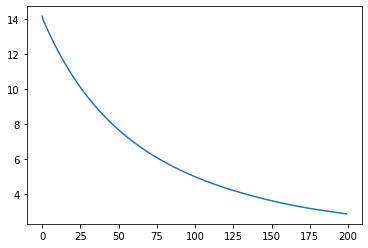

In [80]:
plt.plot(E_dict[1e-12][:,-1])

In [47]:
y_mat.shape

(200, 100)

In [87]:
(V_dict[1e-12][:,-1] -  V_dict[1e-12+ℓ_step][:,-1])/ℓ_step

array([ 1.49949497e+06,  1.52308721e+06,  1.54598556e+06,  1.56680224e+06,
        1.59317004e+06,  1.61606839e+06,  1.63896674e+06,  1.66464065e+06,
        1.68823289e+06,  1.70974346e+06,  1.73402959e+06,  1.75831572e+06,
        1.78190795e+06,  1.80758186e+06,  1.82839854e+06,  1.85060300e+06,
        1.87558302e+06,  1.89362415e+06,  1.91721639e+06,  1.93803307e+06,
        1.96023753e+06,  1.98036032e+06,  1.99978922e+06,  2.01921813e+06,
        2.03448369e+06,  2.04836148e+06,  2.06779038e+06,  2.08236206e+06,
        2.09346429e+06,  2.10456652e+06,  2.11705653e+06,  2.12468931e+06,
        2.13370988e+06,  2.13787321e+06,  2.13995488e+06,  2.13995488e+06,
        2.13926099e+06,  2.13509765e+06,  2.13093432e+06,  2.11983209e+06,
        2.10907680e+06,  2.09693374e+06,  2.08028039e+06,  2.05876982e+06,
        2.03656536e+06,  2.00985062e+06,  1.98278893e+06,  1.94948224e+06,
        1.91097138e+06,  1.87141969e+06,  1.82319437e+06,  1.77670378e+06,
        1.72639680e+06,  

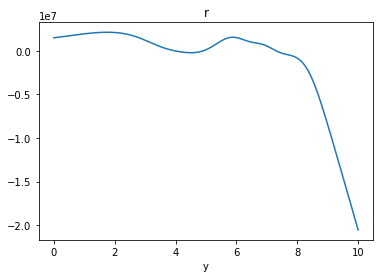

In [88]:
plt.plot(y_mat[:,0], - (V_dict[1e-12+ℓ_step][:,-1] - V_dict[1e-12][:,-1])/ℓ_step)
plt.title('r')
plt.xlabel('y')
plt.savefig("r.png", dpi=148, facecolor='w', edgecolor='w',
        orientation='portrait', format=None,
        transparent=False, bbox_inches="tight", pad_inches=0.1,)